# Анализ столкновений птиц с воздушными судами

## Загрузка и предобработка данных

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import stats as st

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import re

#!pip install phik
from phik import significance_matrix, phik_matrix

In [2]:
sns.set_style('darkgrid')
plt.style.use('ggplot')
sns.set_palette("Set1")

In [3]:
def primary_info(df):
    
    line = '\n'+'_' * 80 + '\n'
    print('\033[34m' +  '10 случайных записей таблицы:', end=line + '\033[0m')
    display(df.sample(10))
    print('\033[34m' +  'Общая информация о таблице:', end=line + '\033[0m')
    display(df.info())
    print('\033[34m' +  'Общие статистические данные:', end=line + '\033[0m')
    display(df.describe())
    print('\033[34m' +  'Корреляция между столбцами:', end=line + '\033[0m')
    display(df.corr().style.background_gradient())
    print('\033[34m' +  'Пропуски и их доля:', end=line)
    display(pd.concat([df.isna().sum().rename('number'), round(100 * df.isna().mean(), 2).rename('percent')], axis=1))
   
    df.isna().mean().to_frame().plot(kind = 'barh', figsize = (15, 6), legend = False, fontsize = 16)\
             .set_title('Доля пропущенных данных' + "\n", fontsize = 22, color = 'SteelBlue')
    plt.show();
             
    print('\033[34m' +  'Наличие дубликатов в таблице:', end=line + '\033[0m')
    print('Количество дубликатов в датасете:', df.duplicated().sum())
    print('Процентное содержание дубликатов в датасете:', '{0:.2%}'.format(df.duplicated().sum() / df.shape[0]))

### Информация о полетах за период с 2002 по 2023 год

In [4]:
flights = pd.read_csv('flights_data_DE.csv', sep='|')
flights

Year  Month  DOMESTIC  INTERNATIONAL   TOTAL airport    direction
0      2002     10   18939.0          497.0   19436     DEN       Origin
1      2002     11   17683.0          469.0   18152     DEN       Origin
2      2002     12   19168.0          510.0   19678     DEN       Origin
3      2002  TOTAL  190251.0         5090.0  195341     DEN       Origin
4      2003      1   19163.0          531.0   19694     DEN       Origin
...     ...    ...       ...            ...     ...     ...          ...
11456  2023      2   12274.0         1242.0   13516     SEA  Destination
11457  2023      3   14045.0         1419.0   15464     SEA  Destination
11458  2023      4   14098.0         1521.0   15619     SEA  Destination
11459  2023      5   15247.0         1614.0   16861     SEA  Destination
11460  2023  TOTAL   69214.0         7183.0   76397     SEA  Destination

[11461 rows x 7 columns]

Приведем названия колонок к единому виду

In [5]:
flights.columns = flights.columns.str.lower()

10 случайных записей таблицы:
________________________________________________________________________________


year  month  domestic  international   total airport    direction
3282   2005  TOTAL  105237.0        50783.0  156020     JFK       Origin
4354   2005      5   19257.0          627.0   19884     CVG       Origin
5325   2017     10    2165.0            NaN    2165     SDF  Destination
5164   2005      5    3200.0            1.0    3201     SDF  Destination
7019   2023  TOTAL   78283.0        20899.0   99182     LAX  Destination
10260  2002     10    3926.0            NaN    3926     DAL       Origin
3093   2012      3   16905.0         1230.0   18135     DTW  Destination
1713   2009     12   35211.0         2680.0   37891     ATL       Origin
5422   2004      6   12053.0          225.0   12278     SLC       Origin
2727   2004     11   19144.0         1155.0   20299     DTW       Origin

Общая информация о таблице:
________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11461 entries, 0 to 11460
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           11461 non-null  int64  
 1   month          11461 non-null  object 
 2   domestic       11447 non-null  float64
 3   international  10202 non-null  float64
 4   total          11461 non-null  int64  
 5   airport        11461 non-null  object 
 6   direction      11461 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 626.9+ KB


None

Общие статистические данные:
________________________________________________________________________________


year       domestic  international          total
count  11461.000000   11447.000000   10202.000000   11461.000000
mean    2012.551610   23528.987944    2861.978338   26047.834220
std        5.997736   48800.347159    7228.728028   54002.972976
min     2002.000000       0.000000       0.000000       1.000000
25%     2007.000000    5423.500000     172.000000    5515.000000
50%     2013.000000   11277.000000    1091.500000   13074.000000
75%     2018.000000   20769.500000    2972.000000   23418.000000
max     2023.000000  437161.000000   86478.000000  472369.000000

Корреляция между столбцами:
________________________________________________________________________________


Пропуски и их доля:
________________________________________________________________________________


number  percent
year                0     0.00
month               0     0.00
domestic           14     0.12
international    1259    10.99
total               0     0.00
airport             0     0.00
direction           0     0.00

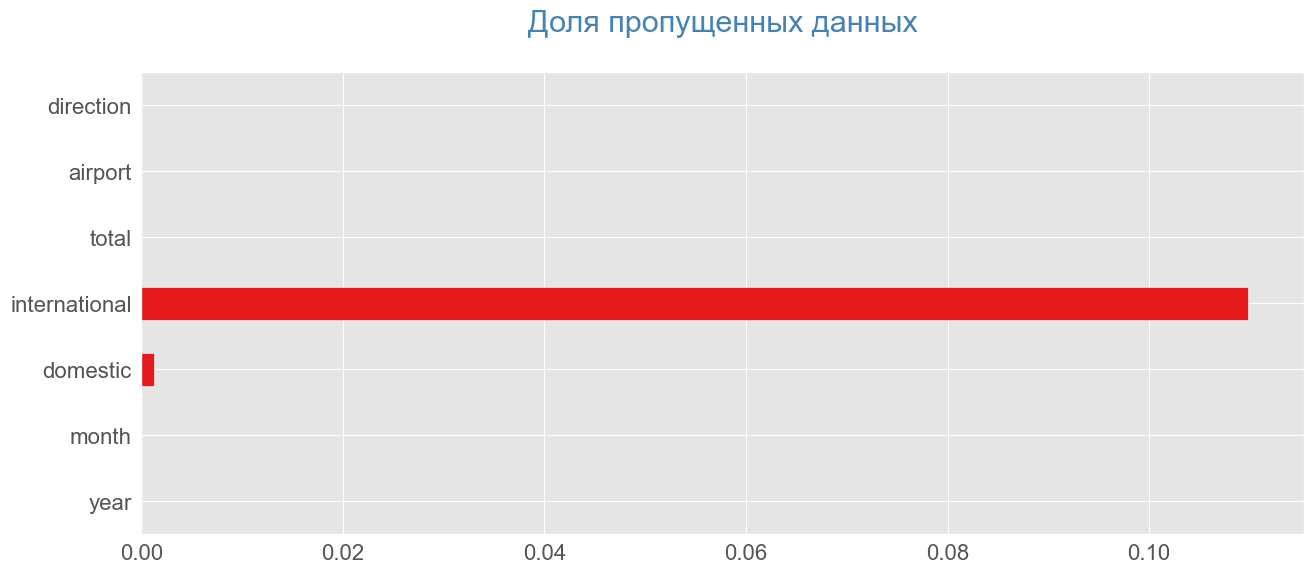

Наличие дубликатов в таблице:
________________________________________________________________________________
Количество дубликатов в датасете: 0
Процентное содержание дубликатов в датасете: 0.00%


In [6]:
primary_info(flights)

В таблице есть пропуски:

In [7]:
flights.query('international.isna()')

year month  domestic  international  total airport    direction
229    2020     5    8703.0            NaN   8703     DEN       Origin
499    2020     5    8715.0            NaN   8715     DEN  Destination
2290   2012    10    4286.0            NaN   4286     MEM       Origin
2291   2012    11    3887.0            NaN   3887     MEM       Origin
2298   2013     5    3590.0            NaN   3590     MEM       Origin
...     ...   ...       ...            ...    ...     ...          ...
10914  2018     6       1.0            NaN      1     TEB  Destination
10915  2018     9      75.0            NaN     75     TEB  Destination
10916  2018    10      23.0            NaN     23     TEB  Destination
10917  2018    11      16.0            NaN     16     TEB  Destination
10919  2019     4       7.0            NaN      7     TEB  Destination

[1259 rows x 7 columns]

In [8]:
flights.query('international.isna()')['year'].value_counts()

2020    120
2021     75
2003     72
2022     70
2014     64
2016     62
2007     62
2006     62
2015     59
2004     59
2010     57
2011     56
2018     53
2013     52
2005     51
2017     51
2008     51
2012     49
2019     47
2009     44
2023     27
2002     16
Name: year, dtype: int64

In [9]:
flights.query('international.isna()')['airport'].value_counts()

DAL    473
SDF    450
MEM    119
AUS     87
TEB     71
MCI     24
CVG     18
RSW      9
TPA      6
DEN      2
Name: airport, dtype: int64

В списке международные аэропорты, у которых не может не быть международных полетов. Пропуски распределены по годам довольно равномерно. Заполним пропущенные данные медианным значением по году и аэропорту.

Сначала удалим строки с годовыми итогами, чтобы они не искажали медианное значение:

In [10]:
flights = flights.query('month != "TOTAL"')
flights

year month  domestic  international  total airport    direction
0      2002    10   18939.0          497.0  19436     DEN       Origin
1      2002    11   17683.0          469.0  18152     DEN       Origin
2      2002    12   19168.0          510.0  19678     DEN       Origin
4      2003     1   19163.0          531.0  19694     DEN       Origin
5      2003     2   16948.0          502.0  17450     DEN       Origin
...     ...   ...       ...            ...    ...     ...          ...
11455  2023     1   13550.0         1387.0  14937     SEA  Destination
11456  2023     2   12274.0         1242.0  13516     SEA  Destination
11457  2023     3   14045.0         1419.0  15464     SEA  Destination
11458  2023     4   14098.0         1521.0  15619     SEA  Destination
11459  2023     5   15247.0         1614.0  16861     SEA  Destination

[10510 rows x 7 columns]

Измучим распределение до заполнения пропусков медианой

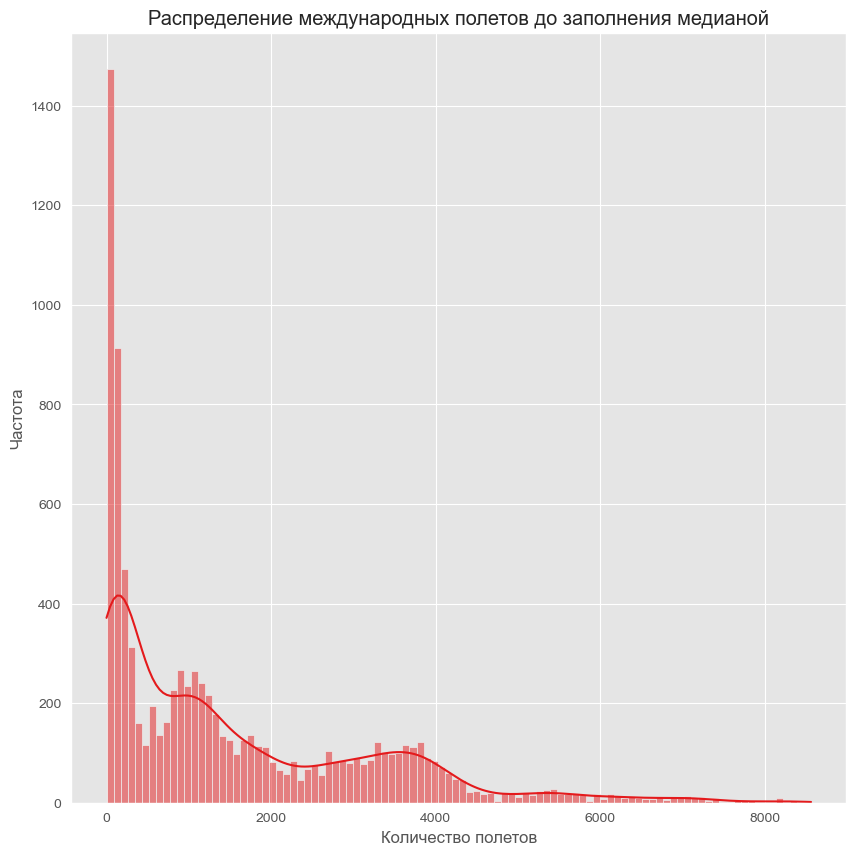

In [11]:
plt.figure(figsize=(10, 10))
sns.histplot(flights['international'], bins = 100, kde=True)
plt.title('Распределение международных полетов до заполнения медианой')
plt.xlabel('Количество полетов')
plt.ylabel('Частота');

In [12]:
flights.international = flights.groupby(['airport', 'year']).international.apply(lambda x: x.fillna(x.median()))

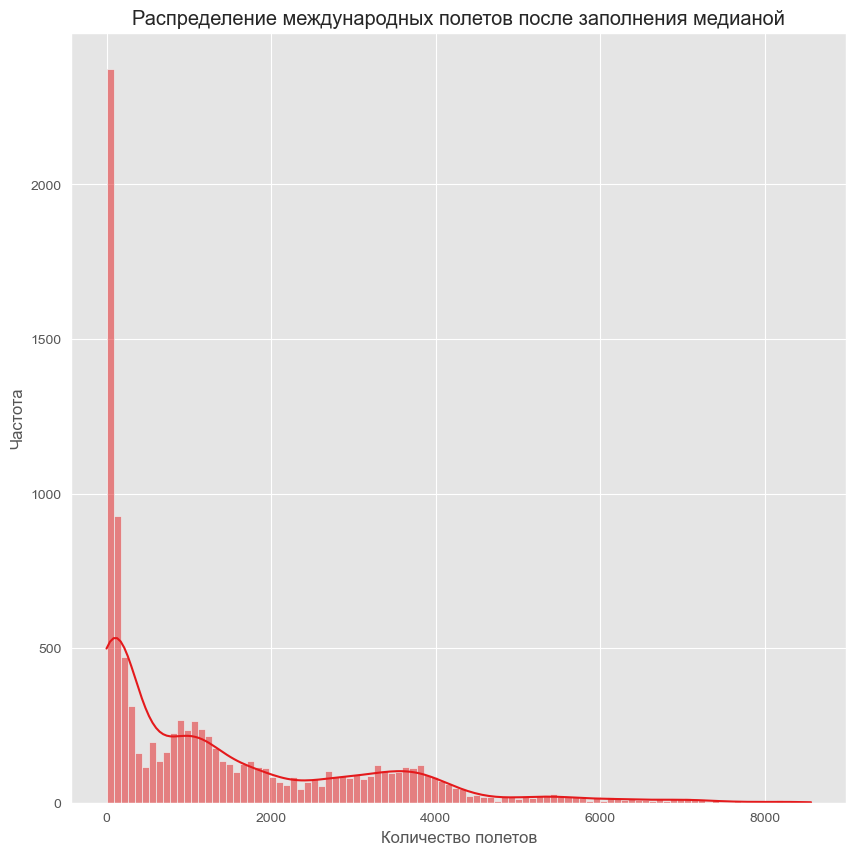

In [13]:
plt.figure(figsize=(10, 10))
sns.histplot(flights['international'], bins = 100, kde=True)
plt.title('Распределение международных полетов после заполнения медианой')
plt.xlabel('Количество полетов')
plt.ylabel('Частота');

In [14]:
flights.domestic = flights.groupby(['airport', 'year']).domestic.apply(lambda x: x.fillna(x.median()))

In [15]:
pd.concat([flights.isna().sum().rename('number'), round(100 * flights.isna().mean(), 2).rename('percent')], axis=1)

number  percent
year                0     0.00
month               0     0.00
domestic            2     0.02
international     342     3.25
total               0     0.00
airport             0     0.00
direction           0     0.00

Удалим, пропуски, которые не удалось заполнить, их доля невелика:

In [16]:
flights = flights.dropna().reset_index(drop=True)

Изменим типы данных в колонках:

In [17]:
flights['month'] = flights['month'].astype('int8')
flights['year'] = flights['year'].astype('int16')

In [18]:
flights[['domestic', 'international']] = flights[['domestic', 'international']].astype('int')

In [19]:
flights

year  month  domestic  international  total airport    direction
0      2002     10     18939            497  19436     DEN       Origin
1      2002     11     17683            469  18152     DEN       Origin
2      2002     12     19168            510  19678     DEN       Origin
3      2003      1     19163            531  19694     DEN       Origin
4      2003      2     16948            502  17450     DEN       Origin
...     ...    ...       ...            ...    ...     ...          ...
10161  2023      1     13550           1387  14937     SEA  Destination
10162  2023      2     12274           1242  13516     SEA  Destination
10163  2023      3     14045           1419  15464     SEA  Destination
10164  2023      4     14098           1521  15619     SEA  Destination
10165  2023      5     15247           1614  16861     SEA  Destination

[10166 rows x 7 columns]

In [20]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10166 entries, 0 to 10165
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year           10166 non-null  int16 
 1   month          10166 non-null  int8  
 2   domestic       10166 non-null  int32 
 3   international  10166 non-null  int32 
 4   total          10166 non-null  int64 
 5   airport        10166 non-null  object
 6   direction      10166 non-null  object
dtypes: int16(1), int32(2), int64(1), int8(1), object(2)
memory usage: 347.6+ KB


Проверим наличие неявных дубликатов:

In [21]:
sorted(flights.airport.unique())

['ATL',
 'AUS',
 'CLT',
 'CVG',
 'DAL',
 'DEN',
 'DFW',
 'DTW',
 'FLL',
 'IAH',
 'JFK',
 'LAX',
 'MCI',
 'MCO',
 'MEM',
 'ORD',
 'RSW',
 'SDF',
 'SEA',
 'SLC',
 'TEB',
 'TPA']

In [22]:
flights.direction.unique()

array(['Origin', 'Destination'], dtype=object)

In [23]:
flights.corr().style.background_gradient()

У столбца total сильная корреляция со столбцом domestic и умеренная со столбцом international. Количество внутренних рейсов больше, чем международных.

Потенциальная проблема - в датасете только американские аэропорты, и внутренний рейс может фиксироваться дважды: для аэропорта вылета (Origin) и аэропорта прилета (Destination), что вносит искажение в данные о количестве внутренних полетов и, соответственно, в данные об общем числе полетов. Возможно, стоит оставить только информацию о вылетах (Origin), удалив данные о рейсах прилета.

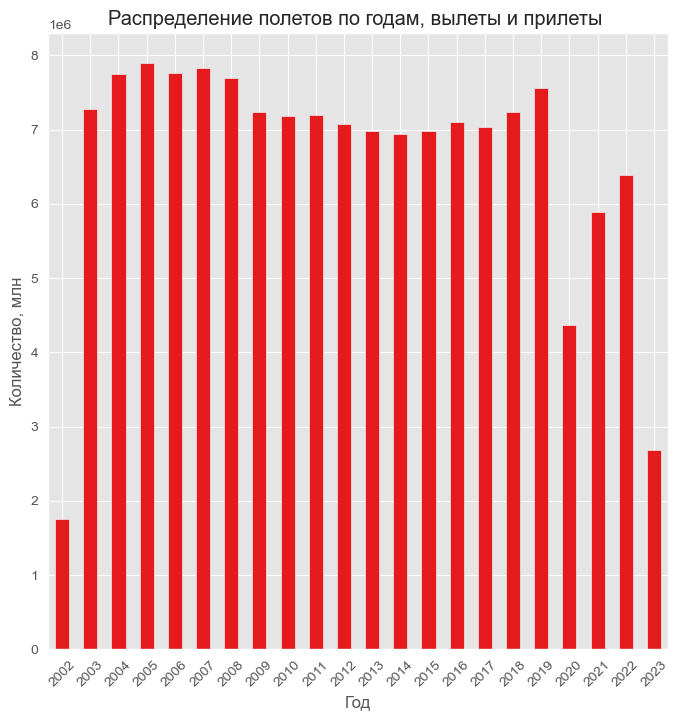

In [24]:
flights.groupby('year')['total'].agg('sum').reset_index().plot(kind='bar', x='year', rot=45, legend=False, figsize=(8, 8))
plt.title('Распределение полетов по годам, вылеты и прилеты ')
plt.xlabel('Год')
plt.ylabel('Количество, млн')
plt.show();

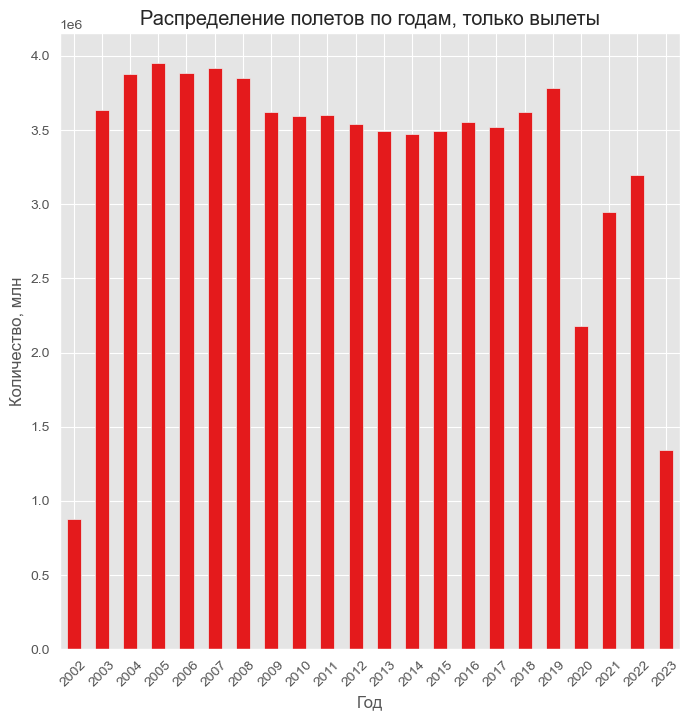

In [25]:
flights.query('direction == "Origin"')\
      .groupby('year')['total'].agg('sum').reset_index()\
      .plot(kind='bar', x='year', rot=45, legend=False, figsize=(8, 8))
plt.title('Распределение полетов по годам, только вылеты')
plt.xlabel('Год')
plt.ylabel('Количество, млн')
plt.show();

In [26]:
flights = flights.query('direction == "Origin"')

In [27]:
flights = flights.reset_index(drop=True)

In [28]:
flights.drop('direction', axis=1, inplace=True)

В датасете используется трехсимвольная кодировка аэропортов FAA, заменим ее на международную четерхсимвольную ICAO:

In [29]:
airports_code = pd.read_html('https://en.wikipedia.org/wiki/List_of_airports_in_the_United_States')[2][['FAA', 'ICAO']]
airports_code.dropna(inplace=True)

In [30]:
air_code_dict = dict(zip(airports_code['FAA'], airports_code['ICAO']))
air_code_dict['TEB'] = 'KTEB'
air_code_dict

{'BHM': 'KBHM',
 'DHN': 'KDHN',
 'HSV': 'KHSV',
 'MOB': 'KMOB',
 'MGM': 'KMGM',
 'MRI': 'PAMR',
 'ANC': 'PANC',
 'BET': 'PABE',
 'CDV': 'PACV',
 'SCC': 'PASC',
 'DLG': 'PADL',
 'FAI': 'PAFA',
 'GST': 'PAGS',
 'HOM': 'PAHO',
 'JNU': 'PAJN',
 'ENA': 'PAEN',
 'KTN': 'PAKT',
 'AKN': 'PAKN',
 'AKW': 'PAKW',
 'ADQ': 'PADQ',
 'OTZ': 'PAOT',
 'OME': 'PAOM',
 'PSG': 'PAPG',
 'SIT': 'PASI',
 'DUT': 'PADU',
 'BRW': 'PABR',
 'WRG': 'PAWG',
 'YAK': 'PAYA',
 'FLG': 'KFLG',
 'IWA': 'KIWA',
 'PGA': 'KPGA',
 'PHX': 'KPHX',
 'PRC': 'KPRC',
 'TUS': 'KTUS',
 'NYL': 'KNYL',
 'XNA': 'KXNA',
 'FSM': 'KFSM',
 'LIT': 'KLIT',
 'TXK': 'KTXK',
 'ACV': 'KACV',
 'BFL': 'KBFL',
 'BUR': 'KBUR',
 'FAT': 'KFAT',
 'LGB': 'KLGB',
 'LAX': 'KLAX',
 'MRY': 'KMRY',
 'OAK': 'KOAK',
 'ONT': 'KONT',
 'SNA': 'KSNA',
 'PSP': 'KPSP',
 'RDD': 'KRDD',
 'SMF': 'KSMF',
 'SAN': 'KSAN',
 'SFO': 'KSFO',
 'SJC': 'KSJC',
 'SBP': 'KSBP',
 'SBA': 'KSBA',
 'SMX': 'KSMX',
 'STS': 'KSTS',
 'SCK': 'KSCK',
 'ALS': 'KALS',
 'ASE': 'KASE',
 'COS': 

In [31]:
flights['airport'].unique()

array(['DEN', 'DFW', 'ORD', 'ATL', 'MEM', 'DTW', 'JFK', 'MCO', 'CVG',
       'SDF', 'SLC', 'CLT', 'LAX', 'TPA', 'AUS', 'MCI', 'FLL', 'RSW',
       'IAH', 'DAL', 'TEB', 'SEA'], dtype=object)

In [32]:
flights['airport'] = flights['airport'].map(air_code_dict)

In [33]:
flights['airport'].unique()

array(['KDEN', 'KDFW', 'KORD', 'KATL', 'KMEM', 'KDTW', 'KJFK', 'KMCO',
       'KCVG', 'KSDF', 'KSLC', 'KCLT', 'KLAX', 'KTPA', 'KAUS', 'KMCI',
       'KFLL', 'KRSW', 'KIAH', 'KDAL', 'KTEB', 'KSEA'], dtype=object)

In [34]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5083 entries, 0 to 5082
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   year           5083 non-null   int16 
 1   month          5083 non-null   int8  
 2   domestic       5083 non-null   int32 
 3   international  5083 non-null   int32 
 4   total          5083 non-null   int64 
 5   airport        5083 non-null   object
dtypes: int16(1), int32(2), int64(1), int8(1), object(1)
memory usage: 134.1+ KB


После пандемии количество перелетов снизилось. Данные за 2002 и 2023 год неполные.

<div class="alert alert-info">
<b>Промежуточный вывод:</b>
    
Загруженный датасет размером 626.9+ KB состоял из 7 стоблцов и 11461 строки.<br><br>

В датасете были пропуски (больше 10%), но не было дубликатов. В ходе первичного знакомства часть пропусков была заменена медианным значением по группе "аэропорт - год", оставшиеся пропуски (меньше 4%) были удалены.<br><br>
    
Был изменен тип данных для столбцов year, month, domestic, international.
    
Были удалены рейсы прилета, чтобы избежать удвоения числа рейсов. Размер датасета сократился до 134.1+ KB (6 колонок, 5083  строки).<br><br>
    
Данные за 2002 и 2023 год неполные.<br><br>
    
</div>    

### Топ-10 аэропортов по количеству вылетов (2018 - 2022 гг.)

In [35]:
top_10 = pd.read_csv('full_top_10.csv')
top_10

airport_id              airport  incident_count  year  month  domestic  \
0         KDEN  DENVER INTL AIRPORT            2888  2018      1     20983   
1         KDEN  DENVER INTL AIRPORT            2888  2018      2     18857   
2         KDEN  DENVER INTL AIRPORT            2888  2018      3     22034   
3         KDEN  DENVER INTL AIRPORT            2888  2018      4     21759   
4         KDEN  DENVER INTL AIRPORT            2888  2018      5     22816   
..         ...                  ...             ...   ...    ...       ...   
595       KSLC  SALT LAKE CITY INTL             949  2022      8      9872   
596       KSLC  SALT LAKE CITY INTL             949  2022      9      9291   
597       KSLC  SALT LAKE CITY INTL             949  2022     10      9079   
598       KSLC  SALT LAKE CITY INTL             949  2022     11      8550   
599       KSLC  SALT LAKE CITY INTL             949  2022     12      8503   

     international  total  
0             1006  21989  
1              878  19735  
2             1080  23114  
3              987  22746  
4              991  23807  
..             ...    ...  
595            354  10226  
596            318   9609  
597            300   9379  
598            277   8827  
599            326   8829  

[600 rows x 8 columns]

10 случайных записей таблицы:
________________________________________________________________________________


airport_id                          airport  incident_count  year  month  \
452       KMCO                     ORLANDO INTL             976  2020      9   
38        KDEN              DENVER INTL AIRPORT            2888  2021      3   
447       KMCO                     ORLANDO INTL             976  2020      4   
449       KMCO                     ORLANDO INTL             976  2020      6   
516       KCLT      CHARLOTTE/DOUGLAS INTL ARPT             958  2021      1   
280       KDTW  DETROIT METRO WAYNE COUNTY ARPT            1284  2021      5   
46        KDEN              DENVER INTL AIRPORT            2888  2021     11   
64        KDFW      DALLAS/FORT WORTH INTL ARPT            1820  2018      5   
510       KCLT      CHARLOTTE/DOUGLAS INTL ARPT             958  2020      7   
343       KMEM                     MEMPHIS INTL            1224  2021      8   

     domestic  international  total  
452      5349             77   5426  
38      19332            484  19816  
447      3605             30   3635  
449      4885             13   4898  
516     14757            772  15529  
280     11003            336  11339  
46      22979            837  23816  
64      23905           2790  26695  
510     13495            249  13744  
343      1860              0   1860

Общая информация о таблице:
________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   airport_id      600 non-null    object
 1   airport         600 non-null    object
 2   incident_count  600 non-null    int64 
 3   year            600 non-null    int64 
 4   month           600 non-null    int64 
 5   domestic        600 non-null    int64 
 6   international   600 non-null    int64 
 7   total           600 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 37.6+ KB


None

Общие статистические данные:
________________________________________________________________________________


incident_count         year       month      domestic  international  \
count      600.000000   600.000000  600.000000    600.000000     600.000000   
mean      1405.400000  2020.000000    6.500000  15922.145000    1694.798333   
std        557.785246     1.415394    3.454933   9010.905069    1765.606535   
min        949.000000  2018.000000    1.000000    601.000000       0.000000   
25%        976.000000  2019.000000    3.750000   9773.000000     348.000000   
50%       1254.000000  2020.000000    6.500000  13991.500000    1102.000000   
75%       1478.000000  2021.000000    9.250000  23058.500000    2622.250000   
max       2888.000000  2022.000000   12.000000  35699.000000    8239.000000   

              total  
count    600.000000  
mean   17616.943333  
std     9763.516979  
min      601.000000  
25%    10406.750000  
50%    16969.000000  
75%    25084.750000  
max    39495.000000

Корреляция между столбцами:
________________________________________________________________________________


Пропуски и их доля:
________________________________________________________________________________


number  percent
airport_id           0      0.0
airport              0      0.0
incident_count       0      0.0
year                 0      0.0
month                0      0.0
domestic             0      0.0
international        0      0.0
total                0      0.0

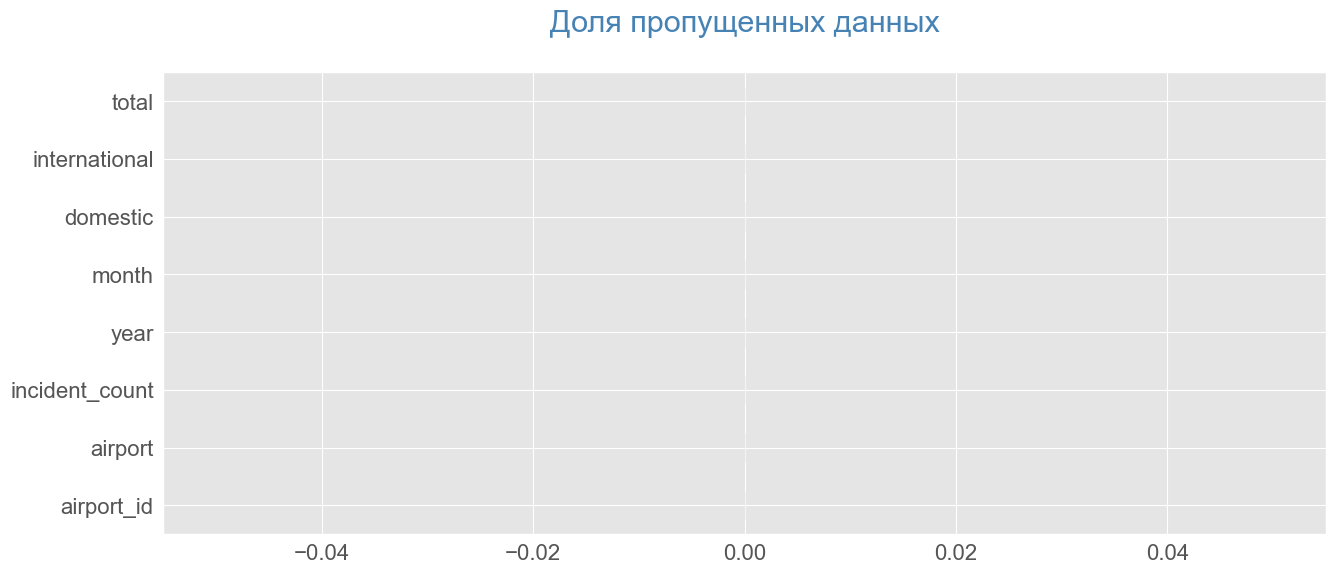

Наличие дубликатов в таблице:
________________________________________________________________________________
Количество дубликатов в датасете: 0
Процентное содержание дубликатов в датасете: 0.00%


In [36]:
primary_info(top_10)

Данные чистые, пропусков нет, дубликатов нет.

In [37]:
top_10.describe(include='object')

airport_id              airport
count         600                  600
unique         10                   10
top          KDEN  DENVER INTL AIRPORT
freq           60                   60

Неявных дубликатов в датасете нет. Чаще всего встречаются записи о DENVER INTL AIRPORT.

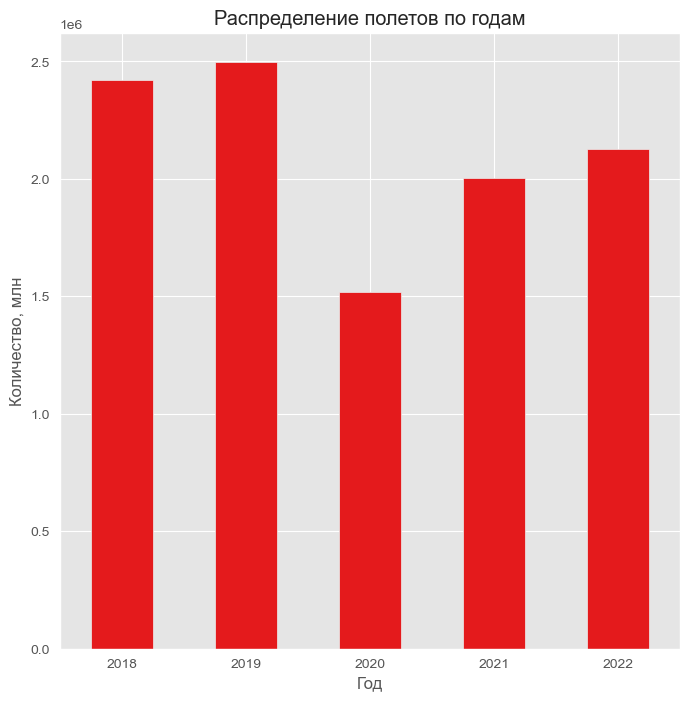

In [38]:
top_10.groupby('year')['total'].agg('sum').reset_index().plot(kind='bar', x='year',
                                                              legend=False, rot=0, figsize = (8, 8));
plt.title('Распределение полетов по годам')
plt.xlabel('Год')
plt.ylabel('Количество, млн')
plt.show();

Заменим тип данных, чтобы сократить размер датасета:

In [39]:
top_10['month'] = top_10['month'].astype('int8')
top_10['year'] = top_10['year'].astype('int16')

In [40]:
top_10[['domestic', 'international', 'total']] = top_10[['domestic', 'international', 'total']].astype('int32')

In [41]:
top_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   airport_id      600 non-null    object
 1   airport         600 non-null    object
 2   incident_count  600 non-null    int64 
 3   year            600 non-null    int16 
 4   month           600 non-null    int8  
 5   domestic        600 non-null    int32 
 6   international   600 non-null    int32 
 7   total           600 non-null    int32 
dtypes: int16(1), int32(3), int64(1), int8(1), object(2)
memory usage: 23.0+ KB


<div class="alert alert-info">
<b>Промежуточный вывод:</b>
    
Загруженный датасет размером 37.6+ KB состоял из 8 стоблцов и 600 строк.<br><br>

Данные чистые, пропусков нет, дубликатов нет.<br><br>
    
Был изменен тип данных для столбцов year, month, domestic, international, total. Размер датасета сократился до 23.0+ KB.<br><br>
    
Данные за период с 2018 по 2022 год.
</div>    

### Данные о столкновениях и погоде

In [42]:
strike = pd.read_csv('file_full.csv')
strike

index_nr      st_code  st_distance report_type call_sign  \
0        802071  72259003927     1.426905         NaN       NaN   
1        802074  72243012960     2.090543         NaN       NaN   
2        802081  72502594741     1.069298       FM-15     KTEB    
3        802082  72203412812     0.421513         NaN       NaN   
4        802083  72314013881     1.405067         NaN       NaN   
...         ...          ...          ...         ...       ...   
77622   1446634          NaN          NaN         NaN       NaN   
77623   1448553          NaN          NaN         NaN       NaN   
77624   1449537          NaN          NaN         NaN       NaN   
77625   1449554          NaN          NaN         NaN       NaN   
77626   1450917          NaN          NaN         NaN       NaN   

      quality_control          cig      dew      slp      tmp  ...    size  \
0                 NaN          NaN      NaN      NaN      NaN  ...   Small   
1                 NaN          NaN      NaN      NaN      NaN  ...   Small   
2                V020  22000,5,9,N  -0044,5  10197,5  -0011,5  ...     NaN   
3                 NaN          NaN      NaN      NaN      NaN  ...   Small   
4                 NaN          NaN      NaN      NaN      NaN  ...   Small   
...               ...          ...      ...      ...      ...  ...     ...   
77622             NaN          NaN      NaN      NaN      NaN  ...   Small   
77623             NaN          NaN      NaN      NaN      NaN  ...  Medium   
77624             NaN          NaN      NaN      NaN      NaN  ...   Small   
77625             NaN          NaN      NaN      NaN      NaN  ...   Small   
77626             NaN          NaN      NaN      NaN      NaN  ...     NaN   

      nr_injuries nr_fatalities  \
0             NaN           NaN   
1             NaN           NaN   
2             NaN           NaN   
3             NaN           NaN   
4             NaN           NaN   
...           ...           ...   
77622         NaN           NaN   
77623         NaN           NaN   
77624         NaN           NaN   
77625         NaN           NaN   
77626         NaN           NaN   

                                                comments  reported_name  \
0      2018-1-6-094630,2018-1-6-091820 /Legacy Record...       REDACTED   
1                2018-1-22-171957 /Legacy Record=401276/       REDACTED   
2       2018-1-10-074748, EXEAIRE /Legacy Record=401283/       REDACTED   
3                2018-1-10-090821 /Legacy Record=401284/       REDACTED   
4            2018-1-19-134518, R1 /Legacy Record=401285/       REDACTED   
...                                                  ...            ...   
77622  *** Strike Report: 2020-07-26-150716-R3( Repor...       REDACTED   
77623                                     removed runway       REDACTED   
77624                                                NaN       REDACTED   
77625                                                NaN       REDACTED   
77626                                                NaN       REDACTED   

      reported_title             source              person  \
0           REDACTED  FAA Form 5200-7-E               Pilot   
1           REDACTED  FAA Form 5200-7-E       Carcass Found   
2           REDACTED  FAA Form 5200-7-E  Airport Operations   
3           REDACTED  FAA Form 5200-7-E       Carcass Found   
4           REDACTED  FAA Form 5200-7-E       Carcass Found   
...              ...                ...                 ...   
77622       REDACTED  FAA Form 5200-7-E  Airport Operations   
77623       REDACTED           Multiple  Airport Operations   
77624       REDACTED           Multiple               Tower   
77625       REDACTED           Multiple               Tower   
77626       REDACTED    FAA Form 5200-7               Other   

                   lupdate  transfer  
0               2018-06-30     False  
1               2018-06-30     False  
2               2018-06-30     False  
3               2018-06-30    

#### Коррекция столбцов time и time_of_day

In [43]:
strike[['time', 'time_of_day']].isna().sum()

time           14088
time_of_day    39351
dtype: int64

Сначала заменим пропуски в столбце time на 12:00 (по ТЗ):

In [44]:
pd.crosstab(strike['time'], strike['time_of_day']).sample(60)

time_of_day  Dawn  Day  Dusk  Night
time                               
18:55           0   26    12     17
13:36           0   15     0      0
14:24           0   16     0      0
07:35          10   61     0      3
02:11           0    2     0      1
02:15           0    5     0      8
12:37           0   13     0      1
00:51           0    0     0      4
12:36           0   25     0      0
23:04           0    0     0     11
10:08           0   19     0      0
14:45           0   70     0      0
20:33           0    0     1     14
03:48           0    0     0      3
13:13           0   20     0      0
18:27           0   10     2      4
22:43           0    0     0      9
08:43           0   20     0      0
04:17           0    2     0      3
19:04           0    9     2      4
15:54           0   13     0      0
10:24           0   15     0      0
13:17           0   19     0      0
19:40           0   20    24     29
22:46           0    0     0     15
02:17           0    1     0      3
06:46           3    3     0      0
23:51           0    0     0     10
04:08           0    0     0      1
02:12           1    0     0      3
16:50           0   50     6      0
22:11           0    1     0     14
03:00           0   16     0     36
08:18           0   28     0      1
03:27           0    0     0      2
07:09           4   15     2      0
05:27           1    2     0      1
04:32           1    0     0      0
18:36           0   11     3      2
13:05           0   58     0      0
12:59           0   11     0      0
06:57           7   14     0      1
04:21           0    0     0      1
05:29           1    0     0      3
03:20           0    3     0      6
00:50           0    0     0     23
03:41           0    2     0      1
07:17           8   10     0      0
20:58           0    0     2     23
17:17           1   10     0      2
16:31           0   13     0      0
22:29           0    0     0     14
13:11           0   13     0      0
02:26           0    0     0      6
10:31           0   14     0      0
07:41           1   14     0      1
05:04           1    1     0      2
14:50           0   48     0      0
20:21           0    1     1      7
04:31           0    0     0      1

Есть проблема несоответствия часа и значения в столбце time_of_day, фиксирующего интенсивность естественного освещения. Исправим это после изменений в столбце time.

In [45]:
strike['time'].fillna('12:00', inplace=True)

In [46]:
strike['time'].value_counts()

12:00     14577
08:00       849
09:00       762
10:00       636
08:30       567
          ...  
19:9:5        1
03:52         1
14:4:0        1
17:7:5        1
23:3:8        1
Name: time, Length: 1483, dtype: int64

In [47]:
strike[strike['time'].str.contains('(.*:){2}.*', regex=True)]['time']

68984    21:1:0
68987    12:12:
68990     06:0:
68993    17:17:
68999    15:5:0
          ...  
77164    21:21:
77169    16:6:0
77187    19:9:0
77362     06:0:
77462    23:3:8
Name: time, Length: 90, dtype: object

In [48]:
strike[strike['time'].str.contains('[^\d:]', regex=True)]['time']

72074    %07:1
72097    %15:3
72098    %09:0
Name: time, dtype: object

Исправим ошибки в столбце time:

In [49]:
strike['time'] = strike['time'].str.replace('%', '')

In [50]:
strike['time'] = strike['time'].str.replace('(.*:)(.*)(:.*)', '\g<1>\g<2>', regex=True)

In [51]:
strike['time'] = strike['time'].replace(r'^ +| +$', r'', regex=True)

Проверим, есть ли неправильные записи в часах:

In [52]:
strike[strike['time'].str.contains('^([3-9]\d:|([2][5-9]:))', regex=True)]['time']

Series([], Name: time, dtype: object)

In [53]:
strike[strike['time'].str.contains('^(\d{3,}:)|^(\d{1}:)', regex=True)]['time']

Series([], Name: time, dtype: object)

Поищем неправильные записи в минутах:

In [54]:
strike[strike['time'].str.contains('(:[6-9]\d*)', regex=True)]['time']

69023    17:7
69037    19:9
69048    19:9
69049    19:9
69064    17:7
69076    16:6
69114    18:8
69131    17:7
69136    17:7
70263    17:7
70435    19:9
70470    18:8
70505    17:7
70653    17:7
71659    16:6
72330    17:7
77169    16:6
77187    19:9
Name: time, dtype: object

In [55]:
strike[strike['time'].str.contains('(:\d{3,})', regex=True)]['time']

Series([], Name: time, dtype: object)

In [56]:
strike[strike['time'].str.contains('(:\d{1}$)', regex=True)]['time']

68984    21:1
68990    06:0
68999    15:5
69008    22:2
69011    10:0
         ... 
77161    23:3
77169    16:6
77187    19:9
77362    06:0
77462    23:3
Name: time, Length: 69, dtype: object

Исправим записи в минутах, добавив в начало 0:

In [57]:
strike['time'] = strike['time'].str.replace(r'^(\d{2}:)(\d)$', r'\g<1>0\g<2>', regex=True)

Так как нам не нужна минутая точность, округлим время до ближайшего часа:

In [58]:
strike['time'].value_counts()

12:00    14577
08:00      852
09:00      764
10:00      639
08:30      567
         ...  
03:39        2
04:22        1
04:46        1
03:52        1
04:02        1
Name: time, Length: 1438, dtype: int64

In [59]:
strike['time'] = strike['time'].str.replace(r'^(\d{2}:)([0-2]\d)', '\g<1>00', regex=True)

In [60]:
strike['time'] = strike['time'].apply(lambda x: re.sub(r'(\d{2})(:[3-5]\d)', 
                                                       lambda m: str((int(m.group(1)) + 1)) + ':00', x))

In [61]:
strike['time'] = strike['time'].str.replace(r'^(\d{1})(:\d{2})$', r'0\g<1>\g<2>', regex=True)

In [62]:
strike['time'] = strike['time'].str.replace(r'^(24)(:\d{2})$', r'00\g<2>', regex=True)

In [63]:
strike['time'].value_counts()

12:00    17566
08:00     5830
09:00     5411
10:00     4922
07:00     4014
11:00     3985
22:00     2856
21:00     2799
23:00     2590
18:00     2488
13:00     2480
20:00     2455
17:00     2391
16:00     2385
19:00     2377
15:00     2252
14:00     2249
00:00     2080
06:00     1908
01:00     1196
02:00     1044
05:00      915
03:00      730
04:00      704
Name: time, dtype: int64

In [64]:
strike['time'].unique()

array(['12:00', '13:00', '02:00', '09:00', '18:00', '07:00', '08:00',
       '05:00', '20:00', '21:00', '14:00', '16:00', '17:00', '03:00',
       '10:00', '11:00', '15:00', '04:00', '19:00', '06:00', '22:00',
       '23:00', '00:00', '01:00'], dtype=object)

In [65]:
strike['time'].isna().sum()

0

Исправим ошибки в кодировке данных в столбце time_of_day:

In [66]:
pd.crosstab(strike['time'], strike['time_of_day'])

time_of_day  Dawn   Day  Dusk  Night
time                                
00:00           3    10    12   1349
01:00           1    57     1    544
02:00           4   134     2    314
03:00           2   125     0    185
04:00          13   102     5    212
05:00          92   104    14    246
06:00         473   284    29    183
07:00         550  1135    45     46
08:00         203  2021    28     57
09:00          32  2379    18    116
10:00          16  2339     2    159
11:00           5  2119     0    136
12:00          97  2604   104    660
13:00           2  1459     1     53
14:00           3  1455     0      0
15:00           0  1389     3      1
16:00           4  1485    33      3
17:00           2  1338   215     88
18:00           3  1221   336    309
19:00           2   823   411    491
20:00           2   376   443    969
21:00           1    34   132   1850
22:00           1    18    15   2021
23:00           4     8    10   1891

Ночные часы записаны как Day. Возможно, это белые ночи, тогда это не ошибки. Белые ночи в США бывают только на Аляске.

In [67]:
pd.crosstab(strike.query('state == "AL"')['time'], strike.query('state == "AL"')['time_of_day'])

time_of_day  Dawn  Day  Dusk  Night
time                               
00:00           0    1     0      3
02:00           0    1     0      0
03:00           0    0     0      1
04:00           0    1     0      0
05:00           2    2     1      1
06:00           5    2     0      0
07:00           4   12     2      1
08:00           1   19     0      1
09:00           0   17     0      0
10:00           0   15     0      0
11:00           0   16     0      0
12:00           0   15     0      1
13:00           0    9     0      0
14:00           0    5     0      0
15:00           0    7     0      0
16:00           0   12     0      0
17:00           0   17     2      1
18:00           0    7     7      2
19:00           0    6     5      2
20:00           0    6     4      5
21:00           0    1     1     22
22:00           0    0     0     14
23:00           0    0     1     15

Таких данных по Аляске немного, а значит, это в колонках времени есть ошибки записи, когда, например, 14:00 фиксируется как 2:00 (или ошибка вследствие смешения 12- и 24-часового формата времени). Исправим эти записи. Согласно  источнику - https://time-in.ru/sun/united-states и закат, и рассвет в США наступают в пределах 6-8 часов.

In [68]:
pd.crosstab(strike['time'], strike['time_of_day'])

time_of_day  Dawn   Day  Dusk  Night
time                                
00:00           3    10    12   1349
01:00           1    57     1    544
02:00           4   134     2    314
03:00           2   125     0    185
04:00          13   102     5    212
05:00          92   104    14    246
06:00         473   284    29    183
07:00         550  1135    45     46
08:00         203  2021    28     57
09:00          32  2379    18    116
10:00          16  2339     2    159
11:00           5  2119     0    136
12:00          97  2604   104    660
13:00           2  1459     1     53
14:00           3  1455     0      0
15:00           0  1389     3      1
16:00           4  1485    33      3
17:00           2  1338   215     88
18:00           3  1221   336    309
19:00           2   823   411    491
20:00           2   376   443    969
21:00           1    34   132   1850
22:00           1    18    15   2021
23:00           4     8    10   1891

In [69]:
strike.loc[(strike['time']  == '00:00') & (strike['time_of_day'] == 'Day'), 'time'] = '12:00'
strike.loc[(strike['time']  == '01:00') & (strike['time_of_day'] == 'Day'), 'time'] = '13:00'
strike.loc[(strike['time']  == '02:00') & (strike['time_of_day'] == 'Day'), 'time'] = '14:00'
strike.loc[(strike['time']  == '03:00') & (strike['time_of_day'] == 'Day'), 'time'] = '15:00'
strike.loc[(strike['time']  == '04:00') & (strike['time_of_day'] == 'Day'), 'time'] = '16:00'
strike.loc[(strike['time']  == '05:00') & (strike['time_of_day'] == 'Day'), 'time'] = '17:00'
strike.loc[(strike['time']  == '06:00') & (strike['time_of_day'] == 'Day'), 'time'] = '18:00'
strike.loc[(strike['time']  == '09:00') & (strike['time_of_day'] == 'Night'), 'time'] = '21:00'
strike.loc[(strike['time']  == '10:00') & (strike['time_of_day'] == 'Night'), 'time'] = '22:00'
strike.loc[(strike['time']  == '11:00') & (strike['time_of_day'] == 'Night'), 'time'] = '23:00'

In [70]:
strike.loc[(strike['time']  == '12:00') & (strike['time_of_day'] == 'Night'), 'time'] = '00:00'
strike.loc[(strike['time']  == '13:00') & (strike['time_of_day'] == 'Night'), 'time'] = '01:00'
strike.loc[(strike['time']  == '14:00') & (strike['time_of_day'] == 'Night'), 'time'] = '02:00'
strike.loc[(strike['time']  == '15:00') & (strike['time_of_day'] == 'Night'), 'time'] = '03:00'
strike.loc[(strike['time']  == '16:00') & (strike['time_of_day'] == 'Night'), 'time'] = '04:00'
strike.loc[(strike['time']  == '17:00') & (strike['time_of_day'] == 'Night'), 'time'] = '05:00'
strike.loc[(strike['time']  == '18:00') & (strike['time_of_day'] == 'Night'), 'time'] = '06:00'
strike.loc[(strike['time']  == '21:00') & (strike['time_of_day'] == 'Day'), 'time'] = '09:00'
strike.loc[(strike['time']  == '22:00') & (strike['time_of_day'] == 'Day'), 'time'] = '10:00'
strike.loc[(strike['time']  == '23:00') & (strike['time_of_day'] == 'Day'), 'time'] = '11:00'

In [71]:
strike.loc[(strike['time']  == '04:00') & (strike['time_of_day'] == 'Dusk'), 'time'] = '16:00'
strike.loc[(strike['time']  == '05:00') & (strike['time_of_day'] == 'Dusk'), 'time'] = '17:00'
strike.loc[(strike['time']  == '06:00') & (strike['time_of_day'] == 'Dusk'), 'time'] = '18:00'
strike.loc[(strike['time']  == '07:00') & (strike['time_of_day'] == 'Dusk'), 'time'] = '19:00'
strike.loc[(strike['time']  == '08:00') & (strike['time_of_day'] == 'Dusk'), 'time'] = '20:00'
strike.loc[(strike['time']  == '09:00') & (strike['time_of_day'] == 'Dusk'), 'time'] = '21:00'
strike.loc[(strike['time']  == '10:00') & (strike['time_of_day'] == 'Dusk'), 'time'] = '22:00'

In [72]:
strike.loc[(strike['time']  == '16:00') & (strike['time_of_day'] == 'Dawn'), 'time'] = '04:00'
strike.loc[(strike['time']  == '17:00') & (strike['time_of_day'] == 'Dawn'), 'time'] = '05:00'
strike.loc[(strike['time']  == '18:00') & (strike['time_of_day'] == 'Dawn'), 'time'] = '06:00'
strike.loc[(strike['time']  == '19:00') & (strike['time_of_day'] == 'Dawn'), 'time'] = '09:00'
strike.loc[(strike['time']  == '20:00') & (strike['time_of_day'] == 'Dawn'), 'time'] = '10:00'
strike.loc[(strike['time']  == '21:00') & (strike['time_of_day'] == 'Dawn'), 'time'] = '09:00'
strike.loc[(strike['time']  == '22:00') & (strike['time_of_day'] == 'Dawn'), 'time'] = '10:00'
strike.loc[(strike['time']  == '23:00') & (strike['time_of_day'] == 'Dawn'), 'time'] = '11:00'

In [73]:
pd.crosstab(strike['time'], strike['time_of_day'])

time_of_day  Dawn   Day  Dusk  Night
time                                
00:00           3     0    12   2009
01:00           1     0     1    597
02:00           4     0     2    314
03:00           2     0     0    186
04:00          17     0     0    215
05:00          94     0     0    334
06:00         476     0     0    492
07:00         550  1135     0     46
08:00         203  2021     0     57
09:00          35  2413     0      0
10:00          19  2357     0      0
11:00           9  2127     0      0
12:00          97  2614   104      0
13:00           2  1516     1      0
14:00           3  1589     0      0
15:00           0  1514     3      0
16:00           0  1587    38      0
17:00           0  1442   229      0
18:00           0  1505   365      0
19:00           0   823   456    491
20:00           0   376   471    969
21:00           0     0   150   1966
22:00           0     0    17   2180
23:00           0     0    10   2027

Заменим название столбца time_of_day на lighting_level, а в столбец time_of_day запишем время дня - утро, день, вечер, ночь.

In [74]:
strike['lighting_level'] = strike['time_of_day'].copy()

Используем для кодировки следующие значения:

- 1 - ночь - 00:00 - 06:00,
- 2 - утро - 07:00 - 11:00,
- 3 - день - 12:00 - 17:00,
- 4 - вечер - 18:00 - 23:00.

In [75]:
night = (strike['time'] >= '00:00') & (strike['time'] <= '06:00')
morning = (strike['time'] >= '07:00') & (strike['time'] <= '11:00')
day =  (strike['time'] >= '12:00') & (strike['time'] <= '17:00') 
evening = (strike['time'] >= '18:00') & (strike['time'] <= '23:00') 

In [76]:
strike['time_of_day'] = strike['time_of_day'].mask(night, 1)
strike['time_of_day'] = strike['time_of_day'].mask(morning, 2)
strike['time_of_day'] = strike['time_of_day'].mask(day, 3)
strike['time_of_day'] = strike['time_of_day'].mask(evening, 4)

In [77]:
pd.crosstab(strike['time'], strike['time_of_day'])

time_of_day     1     2      3     4
time                                
00:00        2730     0      0     0
01:00        1192     0      0     0
02:00         910     0      0     0
03:00         606     0      0     0
04:00         604     0      0     0
05:00         887     0      0     0
06:00        1907     0      0     0
07:00           0  3969      0     0
08:00           0  5802      0     0
09:00           0  5314      0     0
10:00           0  4782      0     0
11:00           0  3861      0     0
12:00           0     0  16916     0
13:00           0     0   2484     0
14:00           0     0   2383     0
15:00           0     0   2376     0
16:00           0     0   2485     0
17:00           0     0   2419     0
18:00           0     0      0  2489
19:00           0     0      0  2420
20:00           0     0      0  2481
21:00           0     0      0  2898
22:00           0     0      0  2998
23:00           0     0      0  2714

In [78]:
strike['time_of_day'].isna().sum()

0

#### Удаление лишних столбцов

In [79]:
strike.sample(20)

index_nr      st_code  st_distance report_type call_sign  \
41743   1110300  72259003927     1.426905       FM-15     KDFW    
15550    825206  72434013994     1.228009       FM-15     KSTL    
62414   1351527  72640014839     1.104145         NaN       NaN   
99       802032  72779024146     1.056363         NaN       NaN   
29022    988532  72530094846     3.154451       FM-16     KORD    
11685   1064103  72259003927     1.426905         NaN       NaN   
34404   1062833  72334013893     1.730420       FM-16     KMEM    
880      803134  72532014842     0.844801         NaN       NaN   
28620    976100  72203412812     0.421513         NaN       NaN   
69275    933887          NaN          NaN         NaN       NaN   
20883    946621  72334013893     1.730420       FM-15     KMEM    
30682   1008871  72219753819     0.446446       FM-15     KFFC    
8000     818807  72067200485     0.300443       FM-15     99999   
8948     819924  72534014819     0.307184       FM-15     KMDW    
6172     815182  72502014734     1.055346       FM-15     KEWR    
7188     817175  72503014732     0.653739         NaN       NaN   
37201   1091903  74704003102     2.258015       FM-16     KONT    
45416   1160594  74791013717     0.563445       FM-15     KMYR    
37438   1092591  72565003017     1.578323       FM-15     KDEN    
9180     820248  72546014933     0.649180       FM-15     KDSM    

      quality_control          cig      dew      slp      tmp  ...  \
41743            V030  22000,5,9,N  +0022,5  10037,5  +0194,5  ...   
15550            V030  07010,5,M,N  -0044,5  10215,5  +0100,5  ...   
62414             NaN          NaN      NaN      NaN      NaN  ...   
99                NaN          NaN      NaN      NaN      NaN  ...   
29022            V030  02134,5,M,N  +0072,5  99999,9  +0083,5  ...   
11685             NaN          NaN      NaN      NaN      NaN  ...   
34404            V030  00274,5,M,N  +0080,5  99999,9  +0100,5  ...   
880               NaN          NaN      NaN      NaN      NaN  ...   
28620             NaN          NaN      NaN      NaN      NaN  ...   
69275             NaN          NaN      NaN      NaN      NaN  ...   
20883            V030  22000,5,9,N  +0106,5  10172,5  +0250,5  ...   
30682            V020  02896,5,M,N  +0222,5  10186,5  +0322,5  ...   
8000             V020  22000,5,9,N  +0237,1  99999,9  +0242,1  ...   
8948             V020  22000,5,9,N  +0106,5  10189,5  +0144,5  ...   
6172             V030  07620,5,M,N  -0061,5  10237,5  +0028,5  ...   
7188              NaN          NaN      NaN      NaN      NaN  ...   
37201            V020  00884,5,M,N  +0111,5  99999,9  +0117,5  ...   
45416            V020  22000,5,9,N  +0172,5  10184,5  +0189,5  ...   
37438            V030  22000,5,9,N  +0111,5  10147,5  +0211,5  ...   
9180             V030  02286,5,M,N  +0072,5  09971,5  +0122,5  ...   

      nr_injuries nr_fatalities  \
41743         NaN           NaN   
15550         NaN           NaN   
62414         NaN           NaN   
99            NaN           NaN   
29022         NaN           NaN   
11685         NaN           NaN   
34404         NaN           NaN   
880           NaN           NaN   
28620         NaN           NaN   
69275         NaN           NaN   
20883         NaN           NaN   
30682         NaN           NaN   
8000          NaN           NaN   
8948          NaN           NaN   
6172          NaN           NaN   
7188          NaN           NaN   
37201         NaN           NaN   
45416         NaN           NaN   
37438         NaN           NaN   
9180          NaN           NaN   

                                                comments  reported_name  \
41743                                                NaN       REDACTED   
15550             2019-5-2-142213 /Legacy Record=427615/       REDACTED   
62414                                                NaN       REDACTED   
99               2018-1-21-111821 /Legacy Record=401228/       REDACTED   
29022            

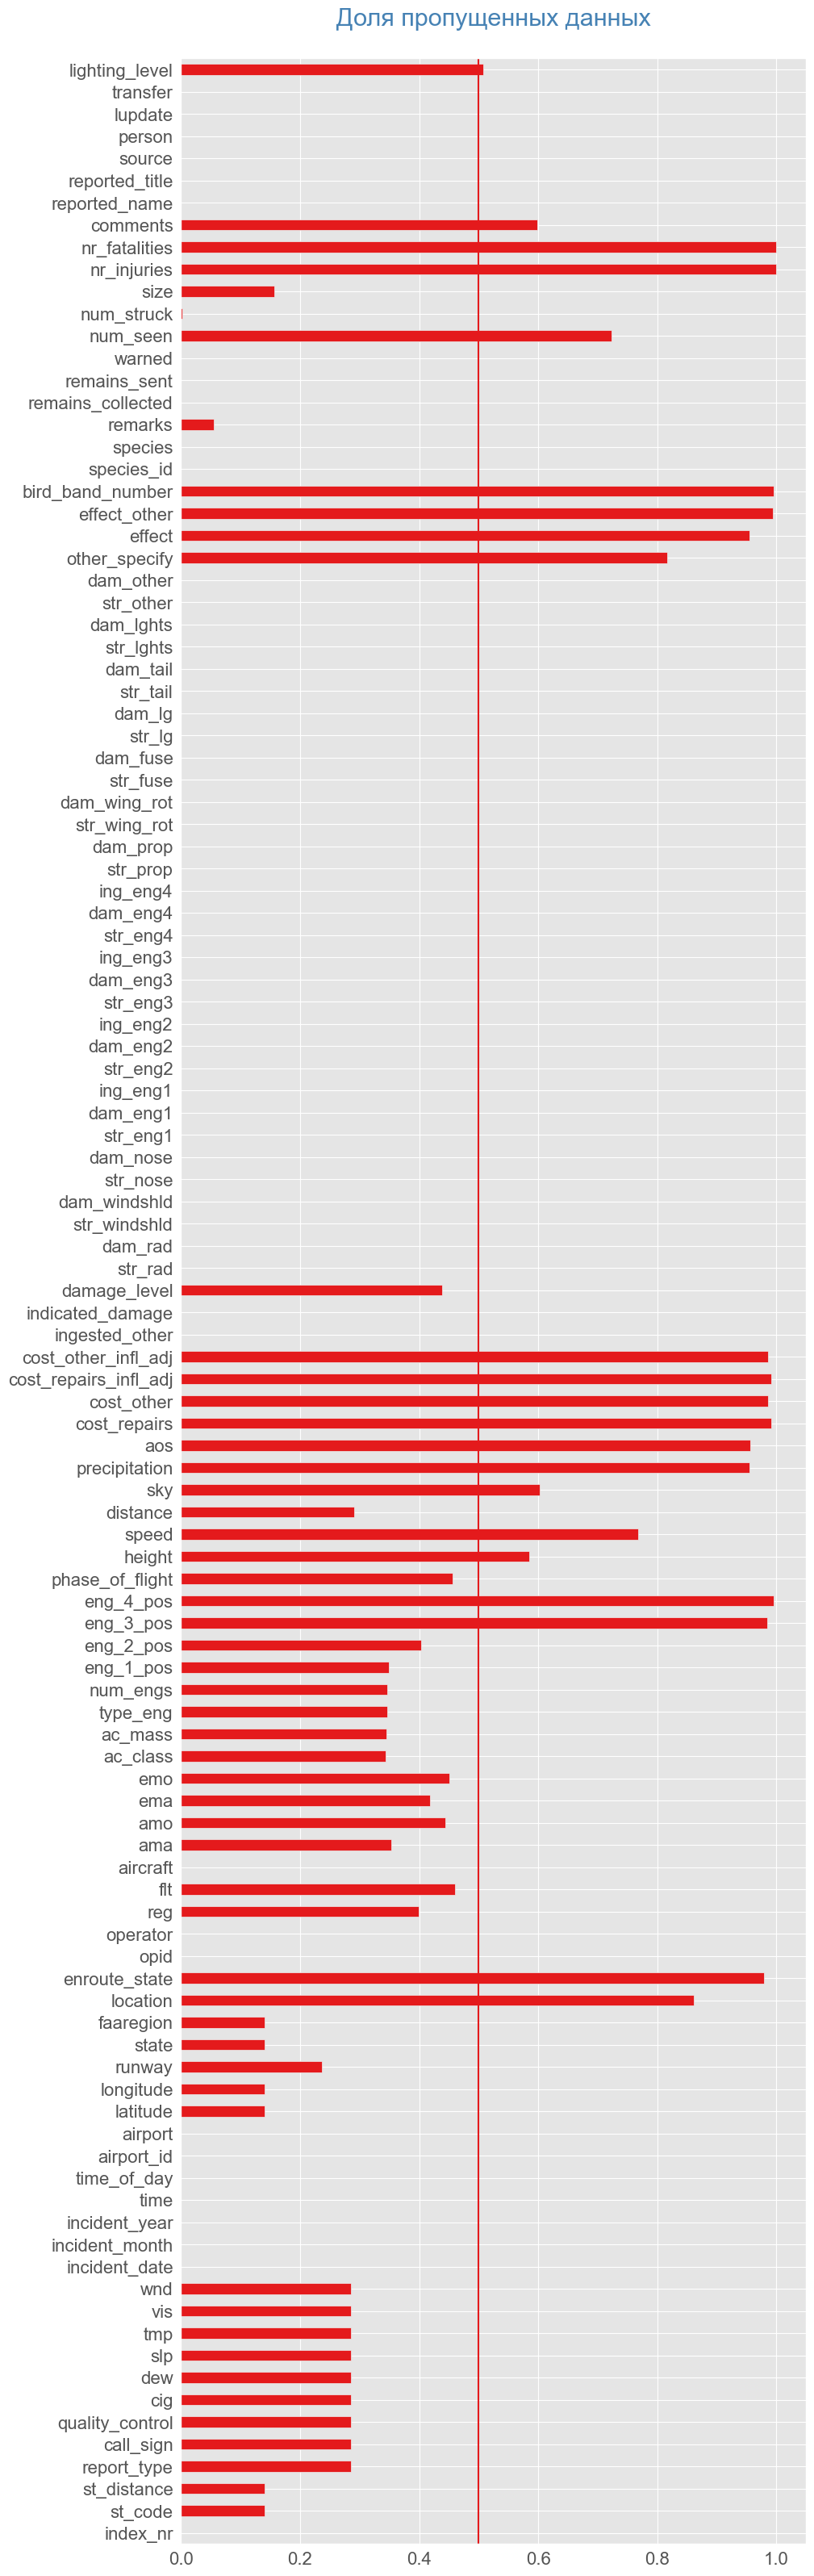

In [80]:
strike.isna().mean().to_frame().plot(kind = 'barh', figsize = (10, 40), legend = False, fontsize = 16)\
  .set_title('Доля пропущенных данных' + "\n", fontsize = 22, color = 'SteelBlue')
plt.axvline(0.5)
plt.show();

Удалим столбцы с большим количеством пропусков

In [81]:
strike.filter(like='eng')

type_eng  num_engs  eng_1_pos  eng_2_pos  eng_3_pos  eng_4_pos  \
0            D       2.0        1.0        1.0        NaN        NaN   
1          NaN       NaN        NaN        NaN        NaN        NaN   
2            D       2.0        5.0        5.0        NaN        NaN   
3          NaN       NaN        NaN        NaN        NaN        NaN   
4          NaN       NaN        NaN        NaN        NaN        NaN   
...        ...       ...        ...        ...        ...        ...   
77622        D       2.0        1.0        1.0        NaN        NaN   
77623        A       1.0        7.0        NaN        NaN        NaN   
77624        D       2.0        1.0        1.0        NaN        NaN   
77625        D       2.0        1.0        1.0        NaN        NaN   
77626        D       2.0        5.0        5.0        NaN        NaN   

       str_eng1  dam_eng1  ing_eng1  str_eng2  dam_eng2  ing_eng2  str_eng3  \
0         False     False     False     False     False     False     False   
1         False     False     False     False     False     False     False   
2         False     False     False     False     False     False     False   
3         False     False     False     False     False     False     False   
4         False     False     False     False     False     False     False   
...         ...       ...       ...       ...       ...       ...       ...   
77622     False     False     False     False     False     False     False   
77623     False     False     False     False     False     False     False   
77624     False     False     False     False     False     False     False   
77625      True      True      True     False     False     False     False   
77626     False     False     False     False     False     False     False   

       dam_eng3  ing_eng3  str_eng4  dam_eng4  ing_eng4  
0         False     False     False     False     False  
1         False     False     False     False     False  
2         False     False     False     False     False  
3         False     False     False     False     False  
4         False     False     False     False     False  
...         ...       ...       ...       ...       ...  
77622     False     False     False     False     False  
77623     False     False     False     False     False  
77624     False     False     False     False     False  
77625     False     False     False     False     False  
77626     False     False     False     False     False  

[77627 rows x 18 columns]

In [82]:
strike.filter(like='eng').nunique()

type_eng     7
num_engs     4
eng_1_pos    7
eng_2_pos    6
eng_3_pos    4
eng_4_pos    3
str_eng1     2
dam_eng1     2
ing_eng1     2
str_eng2     2
dam_eng2     2
ing_eng2     2
str_eng3     2
dam_eng3     2
ing_eng3     2
str_eng4     2
dam_eng4     2
ing_eng4     1
dtype: int64

In [83]:
strike.filter(like='eng').isna().sum()

type_eng     26878
num_engs     26857
eng_1_pos    27076
eng_2_pos    31322
eng_3_pos    76467
eng_4_pos    77226
str_eng1         0
dam_eng1         0
ing_eng1         0
str_eng2         0
dam_eng2         0
ing_eng2         0
str_eng3         0
dam_eng3         0
ing_eng3         0
str_eng4         0
dam_eng4         0
ing_eng4         0
dtype: int64

In [84]:
strike.drop([col for col in strike.columns if "eng" in col], axis=1, inplace=True)

In [85]:
strike.filter(like='cost')

cost_repairs  cost_other  cost_repairs_infl_adj  cost_other_infl_adj
0               NaN       100.0                    NaN                117.0
1               NaN         NaN                    NaN                  NaN
2               NaN         NaN                    NaN                  NaN
3               NaN         NaN                    NaN                  NaN
4               NaN         NaN                    NaN                  NaN
...             ...         ...                    ...                  ...
77622           NaN         NaN                    NaN                  NaN
77623           NaN         NaN                    NaN                  NaN
77624           NaN         NaN                    NaN                  NaN
77625           NaN         NaN                    NaN                  NaN
77626           NaN         NaN                    NaN                  NaN

[77627 rows x 4 columns]

In [86]:
strike.filter(like='cost').nunique()

cost_repairs             230
cost_other               188
cost_repairs_infl_adj    375
cost_other_infl_adj      327
dtype: int64

In [87]:
strike.filter(like='cost').isna().sum()

cost_repairs             76891
cost_other               76506
cost_repairs_infl_adj    76891
cost_other_infl_adj      76506
dtype: int64

In [88]:
strike.drop([col for col in strike.columns if "cost" in col], axis=1, inplace=True)

In [89]:
strike.filter(like='dam')

indicated_damage damage_level  dam_rad  dam_windshld  dam_nose  \
0                 False            N    False         False     False   
1                 False          NaN    False         False     False   
2                 False            N    False         False     False   
3                 False          NaN    False         False     False   
4                 False          NaN    False         False     False   
...                 ...          ...      ...           ...       ...   
77622             False            N    False         False     False   
77623              True           M?    False         False     False   
77624             False            N    False         False     False   
77625              True           M?    False         False     False   
77626             False            N    False         False     False   

       dam_prop  dam_wing_rot  dam_fuse  dam_lg  dam_tail  dam_lghts  \
0         False         False     False   False     False      False   
1         False         False     False   False     False      False   
2         False         False     False   False     False      False   
3         False         False     False   False     False      False   
4         False         False     False   False     False      False   
...         ...           ...       ...     ...       ...        ...   
77622     False         False     False   False     False      False   
77623     False          True     False   False     False      False   
77624     False         False     False   False     False      False   
77625     False         False     False   False     False      False   
77626     False         False     False   False     False      False   

       dam_other  
0          False  
1          False  
2          False  
3          False  
4          False  
...          ...  
77622      False  
77623      False  
77624      False  
77625      False  
77626      False  

[77627 rows x 12 columns]

In [90]:
strike.filter(like='dam').nunique()

indicated_damage    2
damage_level        5
dam_rad             2
dam_windshld        2
dam_nose            2
dam_prop            2
dam_wing_rot        2
dam_fuse            2
dam_lg              2
dam_tail            2
dam_lghts           2
dam_other           2
dtype: int64

In [91]:
strike.filter(like='dam').isna().sum()

indicated_damage        0
damage_level        34046
dam_rad                 0
dam_windshld            0
dam_nose                0
dam_prop                0
dam_wing_rot            0
dam_fuse                0
dam_lg                  0
dam_tail                0
dam_lghts               0
dam_other               0
dtype: int64

In [92]:
strike.drop([col for col in strike.columns if "dam" in col], axis=1, inplace=True)

In [93]:
strike.filter(like='str_')

str_rad  str_windshld  str_nose  str_prop  str_wing_rot  str_fuse  \
0        False         False      True     False          True     False   
1        False         False     False     False         False     False   
2        False         False     False     False         False     False   
3        False         False     False     False         False     False   
4        False         False     False     False         False     False   
...        ...           ...       ...       ...           ...       ...   
77622    False         False     False     False         False      True   
77623    False         False     False     False          True     False   
77624    False         False     False     False         False      True   
77625    False         False     False     False         False     False   
77626    False         False      True     False         False     False   

       str_lg  str_tail  str_lghts  str_other  
0       False     False      False      False  
1       False     False      False      False  
2       False     False      False       True  
3       False     False      False      False  
4       False     False      False      False  
...       ...       ...        ...        ...  
77622   False     False      False      False  
77623   False     False      False      False  
77624   False     False      False      False  
77625   False     False      False      False  
77626   False     False      False      False  

[77627 rows x 10 columns]

In [94]:
strike.filter(like='str_').nunique()

str_rad         2
str_windshld    2
str_nose        2
str_prop        2
str_wing_rot    2
str_fuse        2
str_lg          2
str_tail        2
str_lghts       2
str_other       2
dtype: int64

In [95]:
strike.filter(like='str_').isna().sum()

str_rad         0
str_windshld    0
str_nose        0
str_prop        0
str_wing_rot    0
str_fuse        0
str_lg          0
str_tail        0
str_lghts       0
str_other       0
dtype: int64

In [96]:
strike.drop([col for col in strike.columns if "str_" in col], axis=1, inplace=True)

In [97]:
strike.filter(like='nr')

index_nr enroute_state  nr_injuries  nr_fatalities
0        802071           NaN          NaN            NaN
1        802074           NaN          NaN            NaN
2        802081           NaN          NaN            NaN
3        802082           NaN          NaN            NaN
4        802083           NaN          NaN            NaN
...         ...           ...          ...            ...
77622   1446634           NaN          NaN            NaN
77623   1448553            FL          NaN            NaN
77624   1449537           NaN          NaN            NaN
77625   1449554           NaN          NaN            NaN
77626   1450917           NaN          NaN            NaN

[77627 rows x 4 columns]

In [98]:
strike.filter(like='nr').nunique()

index_nr         77627
enroute_state       55
nr_injuries          2
nr_fatalities        3
dtype: int64

In [99]:
strike.filter(like='nr').isna().sum()

index_nr             0
enroute_state    76037
nr_injuries      77599
nr_fatalities    77621
dtype: int64

In [100]:
strike.drop([col for col in strike.columns if "nr" in col], axis=1, inplace=True)

In [101]:
strike.filter(like='ac')

ac_class  ac_mass
0          A        4.0
1          NaN      NaN
2          A        2.0
3          NaN      NaN
4          NaN      NaN
...        ...      ...
77622      A        4.0
77623      A        1.0
77624      A        4.0
77625      A        4.0
77626      A        3.0

[77627 rows x 2 columns]

In [102]:
strike.filter(like='ac').nunique()

ac_class    5
ac_mass     5
dtype: int64

In [103]:
strike.filter(like='ac').isna().sum()

ac_class    26642
ac_mass     26778
dtype: int64

In [104]:
strike.drop([col for col in strike.columns if "ac" in col], axis=1, inplace=True)

In [105]:
strike.filter(like='remains')

remains_collected  remains_sent
0                   True         False
1                   True         False
2                  False         False
3                   True         False
4                   True          True
...                  ...           ...
77622               True          True
77623               True          True
77624               True          True
77625               True          True
77626              False         False

[77627 rows x 2 columns]

In [106]:
strike.filter(like='remains').nunique()

remains_collected    2
remains_sent         2
dtype: int64

In [107]:
strike.filter(like='remains').isna().sum()

remains_collected    0
remains_sent         0
dtype: int64

In [108]:
strike.drop([col for col in strike.columns if "remains" in col], axis=1, inplace=True)

In [109]:
strike.filter(like='effect')

effect effect_other
0                        NaN          NaN
1                        NaN          NaN
2                        NaN          NaN
3                        NaN          NaN
4                        NaN          NaN
...                      ...          ...
77622                    NaN          NaN
77623  Precautionary Landing          NaN
77624                    NaN          NaN
77625                    NaN          NaN
77626                    NaN          NaN

[77627 rows x 2 columns]

In [110]:
strike.filter(like='effect').nunique()

effect           10
effect_other    235
dtype: int64

In [111]:
strike.filter(like='effect').isna().sum()

effect          74132
effect_other    77164
dtype: int64

In [112]:
strike.drop([col for col in strike.columns if "effect" in col], axis=1, inplace=True)

In [113]:
strike.filter(like='st')

st_code  st_distance state  distance  ingested_other num_struck
0      72259003927     1.426905    TX       NaN           False       2-10
1      72243012960     2.090543    TX       0.0           False          1
2      72502594741     1.069298    NJ       2.0           False          1
3      72203412812     0.421513    FL       0.0           False          1
4      72314013881     1.405067    NC       0.0           False          1
...            ...          ...   ...       ...             ...        ...
77622          NaN          NaN   NaN       NaN           False          1
77623          NaN          NaN   NaN       NaN           False          1
77624          NaN          NaN   NaN       NaN           False          1
77625          NaN          NaN   NaN       NaN           False          1
77626          NaN          NaN   NaN       NaN           False          1

[77627 rows x 6 columns]

In [114]:
strike.filter(like='st').nunique()

st_code           1322
st_distance       1478
state               64
distance            49
ingested_other       2
num_struck           4
dtype: int64

In [115]:
strike.filter(like='st').isna().sum()

st_code           10920
st_distance       10920
state             10920
distance          22603
ingested_other        0
num_struck          183
dtype: int64

In [116]:
strike.drop(['st_code', 'st_distance', 'distance', 'ingested_other'], axis=1, inplace=True)

In [117]:
strike[['comments', 'reported_name', 'reported_title', 'source', 'person', 'lupdate', 'transfer']]

comments reported_name  \
0      2018-1-6-094630,2018-1-6-091820 /Legacy Record...      REDACTED   
1                2018-1-22-171957 /Legacy Record=401276/      REDACTED   
2       2018-1-10-074748, EXEAIRE /Legacy Record=401283/      REDACTED   
3                2018-1-10-090821 /Legacy Record=401284/      REDACTED   
4            2018-1-19-134518, R1 /Legacy Record=401285/      REDACTED   
...                                                  ...           ...   
77622  *** Strike Report: 2020-07-26-150716-R3( Repor...      REDACTED   
77623                                     removed runway      REDACTED   
77624                                                NaN      REDACTED   
77625                                                NaN      REDACTED   
77626                                                NaN      REDACTED   

      reported_title             source              person  \
0           REDACTED  FAA Form 5200-7-E               Pilot   
1           REDACTED  FAA Form 5200-7-E       Carcass Found   
2           REDACTED  FAA Form 5200-7-E  Airport Operations   
3           REDACTED  FAA Form 5200-7-E       Carcass Found   
4           REDACTED  FAA Form 5200-7-E       Carcass Found   
...              ...                ...                 ...   
77622       REDACTED  FAA Form 5200-7-E  Airport Operations   
77623       REDACTED           Multiple  Airport Operations   
77624       REDACTED           Multiple               Tower   
77625       REDACTED           Multiple               Tower   
77626       REDACTED    FAA Form 5200-7               Other   

                   lupdate  transfer  
0               2018-06-30     False  
1               2018-06-30     False  
2               2018-06-30     False  
3               2018-06-30     False  
4               2018-06-30     False  
...                    ...       ...  
77622  2023-08-15 00:00:00     False  
77623  2023-08-24 00:00:00     False  
77624  2023-08-29 00:00:00     False  
77625  2023-08-29 00:00:00     False  
77626  2023-09-05 00:00:00     False  

[77627 rows x 7 columns]

In [118]:
strike[['comments', 'reported_name', 'reported_title', 'source', 'person', 'lupdate', 'transfer']].nunique()

comments          25161
reported_name         1
reported_title        1
source               10
person                6
lupdate            1737
transfer              1
dtype: int64

In [119]:
strike[['comments', 'reported_name', 'reported_title', 'source', 'person', 'lupdate', 'transfer']].isna().sum()

comments          46486
reported_name         0
reported_title        0
source                0
person                1
lupdate               0
transfer              0
dtype: int64

In [120]:
strike.drop(['comments', 'reported_name', 'reported_title', 'source', 'person', 'lupdate', 'transfer'], axis=1, inplace=True)

In [121]:
strike[['report_type', 'call_sign', 'quality_control']]

report_type call_sign quality_control
0             NaN       NaN             NaN
1             NaN       NaN             NaN
2           FM-15     KTEB             V020
3             NaN       NaN             NaN
4             NaN       NaN             NaN
...           ...       ...             ...
77622         NaN       NaN             NaN
77623         NaN       NaN             NaN
77624         NaN       NaN             NaN
77625         NaN       NaN             NaN
77626         NaN       NaN             NaN

[77627 rows x 3 columns]

In [122]:
strike[['report_type', 'call_sign', 'quality_control']].nunique()

report_type           9
call_sign          1050
quality_control       2
dtype: int64

In [123]:
strike[['report_type', 'call_sign', 'quality_control']].isna().sum()

report_type        22193
call_sign          22193
quality_control    22193
dtype: int64

In [124]:
strike.drop(['report_type', 'call_sign', 'quality_control'], axis=1, inplace=True)

In [125]:
strike[['emo', 'ema', 'amo', 'ama']]

emo   ema   amo  ama
0       4.0  22.0   NaN  332
1       NaN   NaN   NaN  NaN
2       NaN  31.0   NaN  332
3       NaN   NaN   NaN  NaN
4       NaN   NaN   NaN  NaN
...     ...   ...   ...  ...
77622   1.0  10.0  43.0  148
77623  19.0   7.0   7.0  226
77624   4.0  22.0   NaN  332
77625   1.0  10.0   7.0  04A
77626   4.0  22.0  10.0  188

[77627 rows x 4 columns]

In [126]:
strike[['emo', 'ema', 'amo', 'ama']].nunique()

emo    35
ema    21
amo    55
ama    68
dtype: int64

In [127]:
strike[['emo', 'ema', 'amo', 'ama']].isna().sum()

emo    34998
ema    32413
amo    34470
ama    27383
dtype: int64

In [128]:
strike.drop(['emo', 'ema', 'amo', 'ama'], axis=1, inplace=True)

In [129]:
strike[['warned', 'num_seen', 'bird_band_number', 'other_specify', 'aos',\
        'precipitation', 'phase_of_flight', 'flt', 'reg', 'location']]

warned num_seen  bird_band_number   other_specify  aos precipitation  \
0      Unknown     2-10               NaN             NaN  1.0           NaN   
1      Unknown      NaN               NaN             NaN  NaN           NaN   
2          Yes        1               NaN  PART NOT REPTD  NaN           NaN   
3      Unknown      NaN               NaN             NaN  NaN           NaN   
4      Unknown      NaN               NaN             NaN  NaN           NaN   
...        ...      ...               ...             ...  ...           ...   
77622  Unknown      NaN               NaN             NaN  NaN           NaN   
77623      Yes        1               NaN             NaN  NaN          None   
77624  Unknown      NaN               NaN             NaN  NaN           NaN   
77625  Unknown      NaN               NaN             NaN  NaN           NaN   
77626  Unknown      NaN               NaN             NaN  NaN           NaN   

      phase_of_flight   flt     reg       location  
0            Approach  3631  N234JW            NaN  
1                 NaN   NaN     NaN            NaN  
2            Approach   972  N679MS            NaN  
3                 NaN   NaN     NaN            NaN  
4                 NaN   NaN     NaN            NaN  
...               ...   ...     ...            ...  
77622             NaN  1478  N8513F  FOUND AT KRSW  
77623        En Route   496  N496ER           KDAB  
77624             NaN  3818  N222NS  FOUND AT KATL  
77625             NaN  2339  N377DN  FOUND AT KATL  
77626             NaN   398     NaN     FOUND KCKB  

[77627 rows x 10 columns]

In [130]:
strike[['warned', 'num_seen', 'bird_band_number', 'other_specify', 'aos',\
        'precipitation', 'phase_of_flight', 'flt', 'reg', 'location']].nunique()

warned                  3
num_seen                4
bird_band_number      156
other_specify        1144
aos                   228
precipitation          12
phase_of_flight        12
flt                  7384
reg                 15731
location             2457
dtype: int64

In [131]:
strike[['warned', 'num_seen', 'bird_band_number', 'other_specify', 'aos',\
        'precipitation', 'phase_of_flight', 'flt', 'reg', 'location']].isna().sum()

warned                  0
num_seen            56118
bird_band_number    77301
other_specify       63373
aos                 74183
precipitation       74144
phase_of_flight     35421
flt                 35720
reg                 31002
location            66842
dtype: int64

In [132]:
strike.drop(['warned', 'num_seen', 'bird_band_number', 'other_specify', 'aos',\
             'precipitation', 'phase_of_flight', 'flt', 'reg', 'location'], axis=1, inplace=True)

In [133]:
strike[['operator', 'opid', 'faaregion', 'runway', 'remarks']]

operator opid faaregion  runway  \
0               ENVOY AIR  ENY      ASW      17C   
1                 UNKNOWN  UNK      ASW   TWY EE   
2                BUSINESS  BUS      AEA       24   
3                 UNKNOWN  UNK      ASO        4   
4                 UNKNOWN  UNK      ASO      36R   
...                   ...  ...       ...     ...   
77622  SOUTHWEST AIRLINES  SWA       NaN     NaN   
77623            BUSINESS  BUS       NaN     NaN   
77624           ENVOY AIR  ENY       NaN     NaN   
77625     DELTA AIR LINES  DAL       NaN     NaN   
77626    SKYWEST AIRLINES  SKW       NaN     NaN   

                                                 remarks  
0      Short final about 300 ft runway 17C at DFW. on...  
1                                             DAY, 1516.  
2      Pilot reported to Teterboro Tower striking a b...  
3      Found remnants of a blunt force strike near ce...  
4      One small bird carcass was found by CLT Airpor...  
...                                                  ...  
77622  Southwest Airlines Operations notified Airport...  
77623  PIC Reported Striking bird just outside if Cla...  
77624  ENY3818(E75L)KMIA...KATL, bird strike on RWY 2...  
77625  DAL2339, A321, FROM KPIT - KATL, LOCAL 1 (119....  
77626                 ASSUME 1 STRUCK. FOUND KCKB. NIGHT  

[77627 rows x 5 columns]

In [134]:
strike[['operator', 'opid', 'faaregion', 'runway', 'remarks']].nunique()

operator       325
opid           327
faaregion       10
runway         743
remarks      68242
dtype: int64

In [135]:
strike[['operator', 'opid', 'faaregion', 'runway', 'remarks']].isna().sum()

operator         0
opid             0
faaregion    10920
runway       18318
remarks       4276
dtype: int64

In [136]:
strike.drop(['operator', 'opid', 'runway', 'remarks'], axis=1, inplace=True)

#### Общая информация о датафрейме

10 случайных записей таблицы:
________________________________________________________________________________


cig      dew      slp      tmp           vis             wnd  \
8765   22000,5,9,N  +0172,5  10124,5  +0372,5  016093,5,N,5  180,5,N,0046,5   
42557  01372,5,M,N  +0172,5  10198,5  +0256,5  016093,5,N,5  060,5,N,0082,5   
24224          NaN      NaN      NaN      NaN           NaN             NaN   
27204  03353,5,M,N  +0067,5  10171,5  +0089,5  016093,5,N,5  140,5,N,0021,5   
31922  22000,5,9,N  +0167,5  10115,5  +0228,5  016093,5,N,5  210,5,N,0051,5   
66181  99999,9,9,N  +0147,5  99999,9  +0150,5  016093,5,N,5  999,9,C,0000,5   
1018   01189,5,M,N  +0130,5  99999,9  +0170,5  016093,5,N,5  090,5,N,0067,5   
38459  22000,5,9,N  +0128,5  10116,5  +0256,5  016093,5,N,5  240,5,N,0046,5   
7542           NaN      NaN      NaN      NaN           NaN             NaN   
67298          NaN      NaN      NaN      NaN           NaN             NaN   

             incident_date  incident_month  incident_year   time  ...  \
8765            2018-07-29               7           2018  09:00  ...   
42557           2021-08-02               8           2021  11:00  ...   
24224           2019-07-12               7           2019  12:00  ...   
27204           2019-02-25               2           2019  12:00  ...   
31922           2020-08-17               8           2020  23:00  ...   
66181           2022-12-07              12           2022  13:00  ...   
1018            2018-04-23               4           2018  20:00  ...   
38459           2020-09-26               9           2020  14:00  ...   
7542            2018-12-16              12           2018  12:00  ...   
67298  2018-07-08 00:00:00               7           2018  12:00  ...   

      faaregion     aircraft  height  speed       sky species_id  \
8765       ASW     B-737-700    50.0  175.0  No Cloud      O2205   
42557      AWP       UNKNOWN     NaN    NaN       NaN      R1101   
24224      ASO         A-319     NaN    NaN       NaN       UNKB   
27204      AWP          C-27     0.0    NaN  Overcast      ZT002   
31922      ANE     B-737-700   600.0  130.0  No Cloud      O2205   
66181      ASO         C-172    60.0   90.0  No Cloud      K1002   
1018       AGL   CITATIONJET     0.0   80.0  Overcast       1G11   
38459      AWP     B-737-800  1200.0  143.0  No Cloud       UNKB   
7542       ASO       UNKNOWN     NaN    NaN       NaN      ZT001   
67298       NaN    B-737-800     NaN    NaN       NaN      N5111   

                  species num_struck   size  lighting_level  
8765        Mourning dove       2-10  Small             Day  
42557            Barn owl          1  Small             NaN  
24224        Unknown bird          1    NaN             NaN  
27204  Western meadowlark          1  Small             Day  
31922       Mourning dove          1  Small           Night  
66181      Turkey vulture          1  Large             Day  
1018    White-tailed deer          1  Large            Dusk  
38459        Unknown bird          1    NaN             Day  
7542   Eastern meadowlark          1  Small             NaN  
67298            Killdeer          1  Small             NaN  

[10 rows x 26 columns]

Общая информация о таблице:
________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77627 entries, 0 to 77626
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cig             55434 non-null  object 
 1   dew             55434 non-null  object 
 2   slp             55434 non-null  object 
 3   tmp             55434 non-null  object 
 4   vis             55434 non-null  object 
 5   wnd             55434 non-null  object 
 6   incident_date   77627 non-null  object 
 7   incident_month  77627 non-null  int64  
 8   incident_year   77627 non-null  int64  
 9   time            77627 non-null  object 
 10  time_of_day     77627 non-null  object 
 11  airport_id      77627 non-null  object 
 12  airport         77627 non-null  object 
 13  latitude        66707 non-null  float64
 14  longitude       66707 non-null  float64
 15  state       

None

Общие статистические данные:
________________________________________________________________________________


incident_month  incident_year      latitude     longitude  \
count    77627.000000   77627.000000  66707.000000  66707.000000   
mean         7.292591    2020.008734     36.625767    -91.418998   
std          2.701473       1.463554      6.594053     22.940836   
min          1.000000    2018.000000    -34.838417   -177.381000   
25%          5.000000    2019.000000     32.895950    -98.469780   
50%          8.000000    2020.000000     38.366670    -87.904460   
75%          9.000000    2021.000000     40.799350    -81.237490   
max         12.000000    2022.000000     71.285450    171.272030   

             height         speed  
count  32262.000000  18083.000000  
mean     900.838696    143.542222  
std     1843.206750     49.021599  
min        0.000000      0.000000  
25%        0.000000    120.000000  
50%       50.000000    140.000000  
75%     1000.000000    161.000000  
max    29000.000000   1250.000000

Корреляция между столбцами:
________________________________________________________________________________


Пропуски и их доля:
________________________________________________________________________________


number  percent
cig              22193    28.59
dew              22193    28.59
slp              22193    28.59
tmp              22193    28.59
vis              22193    28.59
wnd              22193    28.59
incident_date        0     0.00
incident_month       0     0.00
incident_year        0     0.00
time                 0     0.00
time_of_day          0     0.00
airport_id           0     0.00
airport              0     0.00
latitude         10920    14.07
longitude        10920    14.07
state            10920    14.07
faaregion        10920    14.07
aircraft             0     0.00
height           45365    58.44
speed            59544    76.71
sky              46795    60.28
species_id           0     0.00
species              0     0.00
num_struck         183     0.24
size             12196    15.71
lighting_level   39351    50.69

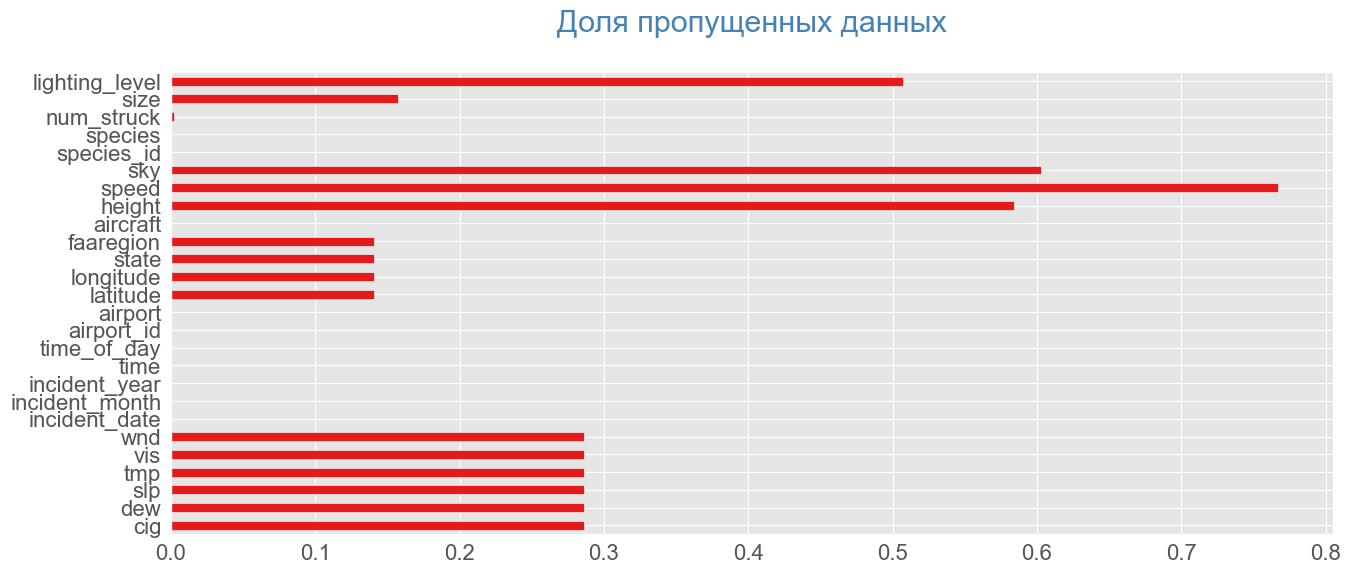

Наличие дубликатов в таблице:
________________________________________________________________________________
Количество дубликатов в датасете: 812
Процентное содержание дубликатов в датасете: 1.05%


In [137]:
primary_info(strike)

#### Удаление пропусков и дубликатов

Строки, не содеращие информации о погоде, бесполезны для анализа.

In [138]:
strike.dropna(subset=['cig', 'dew', 'slp', 'tmp', 'vis', 'wnd'], inplace=True)

In [139]:
strike.isna().sum()

cig                   0
dew                   0
slp                   0
tmp                   0
vis                   0
wnd                   0
incident_date         0
incident_month        0
incident_year         0
time                  0
time_of_day           0
airport_id            0
airport               0
latitude              0
longitude             0
state                 0
faaregion             0
aircraft              0
height            26733
speed             40039
sky               27595
species_id            0
species               0
num_struck          149
size               9255
lighting_level    20516
dtype: int64

In [140]:
strike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55434 entries, 2 to 66706
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cig             55434 non-null  object 
 1   dew             55434 non-null  object 
 2   slp             55434 non-null  object 
 3   tmp             55434 non-null  object 
 4   vis             55434 non-null  object 
 5   wnd             55434 non-null  object 
 6   incident_date   55434 non-null  object 
 7   incident_month  55434 non-null  int64  
 8   incident_year   55434 non-null  int64  
 9   time            55434 non-null  object 
 10  time_of_day     55434 non-null  object 
 11  airport_id      55434 non-null  object 
 12  airport         55434 non-null  object 
 13  latitude        55434 non-null  float64
 14  longitude       55434 non-null  float64
 15  state           55434 non-null  object 
 16  faaregion       55434 non-null  object 
 17  aircraft        55434 non-null 

In [141]:
strike[strike.duplicated(keep=False)].sort_values(by='incident_date')

cig      dew      slp      tmp           vis             wnd  \
783    00762,5,M,N  +0028,5  10327,5  +0067,5  016093,5,N,5  010,5,N,0046,5   
10891  00762,5,M,N  +0028,5  10327,5  +0067,5  016093,5,N,5  010,5,N,0046,5   
3402   22000,5,9,N  +0206,5  10153,5  +0317,5  016093,5,N,5  010,5,N,0046,5   
8364   22000,5,9,N  +0206,5  10153,5  +0317,5  016093,5,N,5  010,5,N,0046,5   
7805   07620,5,M,N  +0194,5  10135,5  +0222,5  014484,5,N,5  220,5,N,0015,5   
...            ...      ...      ...      ...           ...             ...   
64594  00732,5,M,N  -0100,5  99999,9  -0039,5  016093,5,N,5  280,5,N,0072,5   
64600  00732,5,M,N  -0100,5  99999,9  -0039,5  016093,5,N,5  280,5,N,0072,5   
64601  00732,5,M,N  -0100,5  99999,9  -0039,5  016093,5,N,5  280,5,N,0072,5   
65393  01250,5,M,N  +0144,5  10234,5  +0150,5  012875,5,N,5  999,9,C,0000,5   
66456  01250,5,M,N  +0144,5  10234,5  +0150,5  012875,5,N,5  999,9,C,0000,5   

      incident_date  incident_month  incident_year   time  ... faaregion  \
783      2018-03-27               3           2018  14:00  ...      ASO    
10891    2018-03-27               3           2018  14:00  ...      ASO    
3402     2018-07-15               7           2018  19:00  ...      AGL    
8364     2018-07-15               7           2018  19:00  ...      AGL    
7805     2018-08-10               8           2018  11:00  ...      AGL    
...             ...             ...            ...    ...  ...       ...   
64594    2022-11-30              11           2022  11:00  ...      AGL    
64600    2022-11-30              11           2022  11:00  ...      AGL    
64601    2022-11-30              11           2022  11:00  ...      AGL    
65393    2022-12-08              12           2022  11:00  ...      ASO    
66456    2022-12-08              12           2022  11:00  ...      ASO    

        aircraft height  speed       sky species_id               species  \
783        A-321    0.0    NaN       NaN      UNKBS  Unknown bird - small   
10891      A-321    0.0    NaN       NaN      UNKBS  Unknown bird - small   
3402   B-737-800    0.0    NaN  No Cloud      N5111              Killdeer   
8364   B-737-800    0.0    NaN  No Cloud      N5111              Killdeer   
7805     EMB-170    0.0    NaN       NaN       UNKB          Unknown bird   
...          ...    ...    ...       ...        ...                   ...   
64594    UNKNOWN    NaN    NaN       NaN      K5114      American kestrel   
64600    UNKNOWN    NaN    NaN       NaN      K5114      American kestrel   
64601    UNKNOWN    NaN    NaN       NaN      R2004       Short-eared owl   
65393    UNKNOWN    NaN    NaN       NaN      ZT001    Eastern meadowlark   
66456    UNKNOWN    NaN    NaN       NaN      ZT001    Eastern meadowlark   

      num_struck   size  lighting_level  
783         2-10  Small             Day  
10891       2-10  Small             Day  
3402           1  Small             Day  
8364           1  Small             Day  
7805           1    NaN             Day  
...          ...    ...             ...  
64594          1  Small             NaN  
64600          1  Small             NaN  
64601          1  Small             NaN  
65393          1  Small             NaN  
66456          1  Small             NaN  

[877 rows x 26 columns]

In [142]:
strike.drop_duplicates(inplace=True)

In [143]:
strike = strike.reset_index(drop=True)

#### Изменение типов данных

In [144]:
strike.head(5)

cig      dew      slp      tmp           vis             wnd  \
0  22000,5,9,N  -0044,5  10197,5  -0011,5  016093,5,N,5  250,5,N,0036,5   
1  02438,1,C,N  +0260,1  99999,9  +0260,1  009999,1,9,9  060,1,N,0031,1   
2  00884,5,M,N  +0083,5  99999,9  +0094,5  016093,5,N,5  130,5,N,0031,5   
3  00061,5,W,N  +0072,5  99999,9  +0072,5  001609,5,N,5  340,5,N,0021,5   
4  22000,5,9,N  +0044,5  10273,5  +0056,5  016093,5,N,5  030,5,N,0026,5   

  incident_date  incident_month  incident_year   time  ... faaregion  \
0    2018-01-09               1           2018  13:00  ...      AEA    
1    2018-01-31               1           2018  02:00  ...      FGN    
2    2018-03-22               3           2018  09:00  ...      ANM    
3    2018-01-06               1           2018  06:00  ...      AWP    
4    2018-01-07               1           2018  09:00  ...      ASO    

             aircraft  height  speed         sky species_id  \
0  EMB-500 PHENOM 100     NaN    NaN  Some Cloud       UNKB   
1           B-777-200  5000.0  250.0    No Cloud      UNKBL   
2             UNKNOWN     NaN    NaN         NaN      R2004   
3         BE-300 KING     0.0    NaN    No Cloud       1F11   
4             UNKNOWN     NaN    NaN         NaN      YI010   

                species num_struck   size  lighting_level  
0          Unknown bird          1    NaN             Day  
1  Unknown bird - large          1  Large           Night  
2       Short-eared owl          1  Small             Day  
3                Coyote          1  Large           Night  
4          Tree swallow          1  Small             Day  

[5 rows x 26 columns]

In [145]:
strike.incident_date = pd.to_datetime(strike.incident_date)

In [146]:
strike['incident_month'] = strike['incident_month'].astype('int8')
strike['incident_year'] = strike['incident_year'].astype('int16')

Заменим значения в столбце num_struck на категории от 0 до 4:

In [147]:
strike.num_struck.value_counts(dropna=False)

1                49381
2-10              5240
11-100             190
NaN                139
More than 100        4
Name: num_struck, dtype: int64

In [148]:
strike.num_struck.fillna('unknown', inplace=True)

In [149]:
strike_list = ['unknown', '1', '2-10', '11-100', 'More than 100']
cat_list = [0, 1, 2, 3, 4]
strike_dict = {key:value for key, value in zip(strike_list, cat_list)}
strike['num_struck'] =  strike['num_struck'].map(strike_dict)

In [150]:
strike['num_struck'] = strike['num_struck'].astype('int8')

Заменим значения в столбце num_struck на категории от 0 до 3:

In [151]:
strike['size'].fillna('unknown', inplace=True)

In [152]:
strike['size'].value_counts(dropna=False)

Small      36575
unknown     9246
Medium      5864
Large       3269
Name: size, dtype: int64

In [153]:
size_list = ['unknown', 'Small', 'Medium', 'Large']
cat_list = [0, 1, 2, 3]
strike_dict = {key:value for key, value in zip(size_list, cat_list)}
strike['size'] =  strike['size'].map(strike_dict)

In [154]:
strike['size'] = strike['size'].astype('int8')

Категоризация столбца sky:

In [155]:
strike['sky'].fillna('unknown', inplace=True)

In [156]:
strike['sky'].value_counts(dropna=False)

unknown       27141
No Cloud      13165
Some Cloud    10008
Overcast       4640
Name: sky, dtype: int64

In [157]:
sky_list = ['unknown', 'No Cloud', 'Some Cloud', 'Overcast']
cat_list = [-1, 0, 1, 2]
strike_dict = {key:value for key, value in zip(sky_list, cat_list)}
strike['sky'] =  strike['sky'].map(strike_dict)

In [158]:
strike['sky'] = strike['sky'].astype('int8')

In [159]:
strike['time_of_day'] = strike['time_of_day'].astype('int8')

In [160]:
strike = strike.rename(columns={'num_struck':'cat_num_struck', 'size':'cat_size', 'sky':'cat_sky'})

#### Поиск неявных дубликатов

Проверим есть опечатки в названиях аэропортов:

In [161]:
airport_list = []
group_names = strike.groupby('airport')
for name, value in group_names:
    airport_list.append(name)

In [162]:
from nltk.metrics import edit_distance
# similiar = []
# for x in airport_list:
#     for y in airport_list:
#         if edit_distance(x, y) == 1:
#             similiar.append(x)

In [163]:
# similiar

In [164]:
# similiar_airports = pd.DataFrame(similiar)
# similiar_airports.to_csv('similiar_airports.csv')

Сохраним список, чтобы не перезапускать проверку каждый раз, так как она занимает много времени:

In [165]:
similiar = ['DENTON MUNICIPAL ARPT', 'RENTON MUNICIPAL ARPT']

В названиях аэропортов опечаток нет. Проверим виды птиц:

In [166]:
species_list = []
group_names = strike.groupby('species')
for name, value in group_names:
    species_list.append(name)

In [167]:
# similiar_species = []
# for x in species_list:
#     for y in species_list:
#         if edit_distance(x, y) == 1:
#             similiar_species.append(x)

In [168]:
# similiar_species

In [169]:
# similiar_species = pd.DataFrame(similiar_species)
# similiar_species.to_csv('similiar_species.csv')

Сохраним список, чтобы не перезапускать проверку каждый раз, так как она занимает много времени:

In [170]:
similiar_species = ['Finches, Euphonias',
                    'Finches, euphonias',
                    'Terns, Noddies',
                    'Terns, noddies']

Приведем названия видов животных к нижнему регистру и проверим дубликаты:

In [171]:
strike.species = strike.species.str.lower().str.strip()
strike.species_id = strike.species_id.str.lower().str.strip()

In [172]:
strike.airport_id = strike.airport_id.str.upper().str.strip()  
strike.aircraft = strike.aircraft.str.upper().str.strip()
strike.state = strike.state.str.upper().str.strip()
strike.faaregion = strike.faaregion.str.upper().str.strip()

In [173]:
strike.duplicated().sum()

0

#### Дикие животные в статистике столкновений

In [174]:
strike[~strike['species'].str.contains("bird")].species

2                short-eared owl
3                         coyote
4                   tree swallow
5        black-tailed jackrabbit
7                     zebra dove
                  ...           
54935            eastern red bat
54942              chimney swift
54947           american kestrel
54951                     coyote
54952               domestic dog
Name: species, Length: 34730, dtype: object

In [175]:
strike[strike['species_id'].str.contains("^\d.*", regex=True)]       

cig      dew      slp      tmp           vis             wnd  \
3      00061,5,W,N  +0072,5  99999,9  +0072,5  001609,5,N,5  340,5,N,0021,5   
5      22000,5,9,N  +9999,9  10032,5  +0122,5  016093,5,N,5  250,5,N,0093,5   
14     00610,5,M,N  +0000,5  10196,5  +0033,5  012875,5,N,5  350,5,N,0067,5   
15     00305,5,M,N  +0211,5  10167,5  +0228,5  012875,5,N,5  150,5,N,0051,5   
17     22000,7,9,N  +0000,C  99999,9  +0040,C  016093,5,N,5  999,9,C,0000,5   
...            ...      ...      ...      ...           ...             ...   
54923  22000,5,9,N  +0211,5  10174,5  +0233,5  016093,5,N,5  999,9,C,0000,5   
54931  22000,1,9,N  +0070,1  99999,9  +0290,1  016093,1,9,9  250,1,N,0041,1   
54935  00183,5,M,N  +0133,5  10193,5  +0139,5  000402,6,N,5  250,5,N,0041,5   
54951  22000,5,9,N  +0150,5  10134,5  +0283,5  016093,5,N,5  230,5,N,0021,5   
54952  06096,5,M,N  +0211,5  10178,5  +0233,5  016093,5,N,5  360,5,N,0021,5   

      incident_date  incident_month  incident_year   time  ...  faaregion  \
3        2018-01-06               1           2018  06:00  ...        AWP   
5        2018-01-11               1           2018  07:00  ...        ASW   
14       2018-02-16               2           2018  20:00  ...        AGL   
15       2018-02-17               2           2018  08:00  ...        ASW   
17       2018-02-27               2           2018  15:00  ...        AEA   
...             ...             ...            ...    ...  ...        ...   
54923    2022-12-19              12           2022  07:00  ...        ASO   
54931    2022-06-30               6           2022  04:00  ...        AWP   
54935    2022-12-07              12           2022  21:00  ...        AEA   
54951    2022-10-25              10           2022  21:00  ...        ASO   
54952    2022-06-28               6           2022  08:00  ...        ASO   

          aircraft height  speed  cat_sky species_id  \
3      BE-300 KING    0.0    NaN        0       1f11   
5          EMB-170    NaN    NaN        0       1d11   
14           MD-88    0.0    NaN       -1       1f41   
15         UNKNOWN    NaN    NaN       -1     1c2201   
17           C-172    0.0    NaN        1      1f131   
...            ...    ...    ...      ...        ...   
54923    B-737-800    NaN    NaN        1     1c2206   
54931        C-182    0.0   55.0        0       1f11   
54935        A-320    NaN    NaN       -1     1c2101   
54951    B-737-800    NaN  161.0        0       1f11   
54952        A-319    NaN  132.0        2       1f12   

                         species cat_num_struck  cat_size  lighting_level  
3                         coyote              1         3           Night  
5        black-tailed jackrabbit              1         3            Dawn  
14                 striped skunk              1         3           Night  
15     brazilian free-tailed bat              1         1            Dawn  
17                       red fox              0         3             Day  
...                          ...            ...       ...             ...  
54923       pallas's mastiff bat              1         1            Dawn  
54931                     coyote              0         3           Night  
54935            eastern red bat              1         1           Night  
54951                     coyote              0         3           Night  
54952               domestic dog              0         3             Day  

[2712 rows x 26 columns]

In [176]:
strike[strike['species_id'].str.contains("^\d.*", regex=True)]['species'].value_counts().head(50)

brazilian free-tailed bat          371
microbats                          344
coyote                             206
striped skunk                      182
eastern red bat                    168
little brown bat                   142
black-tailed jackrabbit            133
white-tailed deer                  116
virginia opossum                   116
white-tailed jackrabbit             85
gopher snake                        77
big brown bat                       67
eastern cottontail                  66
red fox                             56
vesper bats                         53
hoary bat                           40
raccoon                             34
evening bat                         34
woodchuck                           31
black-tailed prairie dog            24
turtles                             23
silver-haired bat                   19
green iguana                        19
gopher tortoise                     17
painted turtle                      16
diamondback terrapin     

Очевидно, столкновения с дикими животными происходят на взлетной полосе, значит, погода на них не влияет или влияет несущественно. Удалим эти записи из датафрейма:

In [177]:
strike = strike[~strike['species_id'].str.contains("^\d.*", regex=True)]
strike

cig      dew      slp      tmp           vis             wnd  \
0      22000,5,9,N  -0044,5  10197,5  -0011,5  016093,5,N,5  250,5,N,0036,5   
1      02438,1,C,N  +0260,1  99999,9  +0260,1  009999,1,9,9  060,1,N,0031,1   
2      00884,5,M,N  +0083,5  99999,9  +0094,5  016093,5,N,5  130,5,N,0031,5   
4      22000,5,9,N  +0044,5  10273,5  +0056,5  016093,5,N,5  030,5,N,0026,5   
6      01676,5,M,N  -0172,5  10294,5  -0106,5  016093,5,N,5  250,5,N,0036,5   
...            ...      ...      ...      ...           ...             ...   
54947  00671,5,M,N  +0220,5  99999,9  +0280,5  016093,5,N,5  050,5,N,0026,5   
54948  22000,5,9,N  +0239,5  10102,5  +0261,5  016093,5,N,5  060,5,N,0015,5   
54949  22000,7,9,N  +0030,C  99999,9  +0240,C  020921,5,N,5  999,9,C,0000,5   
54950  02134,5,M,N  +0100,5  10172,5  +0172,5  016093,5,N,5  220,5,N,0046,5   
54953  22000,5,9,N  -0078,5  10249,5  +0106,5  016093,5,N,5  999,9,V,0021,5   

      incident_date  incident_month  incident_year   time  ...  faaregion  \
0        2018-01-09               1           2018  13:00  ...        AEA   
1        2018-01-31               1           2018  02:00  ...        FGN   
2        2018-03-22               3           2018  09:00  ...        ANM   
4        2018-01-07               1           2018  09:00  ...        ASO   
6        2018-01-02               1           2018  12:00  ...        AEA   
...             ...             ...            ...    ...  ...        ...   
54947    2022-10-29              10           2022  16:00  ...        ASO   
54948    2022-10-13              10           2022  21:00  ...        ASO   
54949    2022-10-31              10           2022  23:00  ...        ASW   
54950    2022-04-14               4           2022  22:00  ...        AWP   
54953    2022-12-26              12           2022  06:00  ...        ASW   

                 aircraft  height  speed  cat_sky species_id  \
0      EMB-500 PHENOM 100     NaN    NaN        1       unkb   
1               B-777-200  5000.0  250.0        0      unkbl   
2                 UNKNOWN     NaN    NaN       -1      r2004   
4                 UNKNOWN     NaN    NaN       -1      yi010   
6           SIKORSKY S-76     0.0    NaN        0      unkbs   
...                   ...     ...    ...      ...        ...   
54947             B-737-9     0.0  120.0        1      k5114   
54948               A-321  1800.0  170.0        1       unkb   
54949             B-737-7  3500.0  190.0        0      unkbm   
54950               A-320  3500.0    NaN        1       unkb   
54953           B-737-700    15.0  130.0        0      unkbm   

                     species cat_num_struck  cat_size  lighting_level  
0               unknown bird              1         0             Day  
1       unknown bird - large              1         3           Night  
2            short-eared owl              1         1             Day  
4               tree swallow              1         1             Day  
6       unknown bird - small              1         1             Day  
...                      ...            ...       ...             ...  
54947       american kestrel              1         1             Day  
54948           unknown bird              1         0           Night  
54949  unknown bird - medium              1         2           Night  
54950           unknown bird              1         0           Night  
54953  unknown bird - medium              1         2           Night  

[52242 rows x 26 columns]

In [178]:
strike[~strike['species'].str.contains("bird")].species.value_counts().tail(60)

ring-necked pheasant         1
worm-eating warbler          1
white-eyed vireo             1
bewick's wren                1
sage thrasher                1
red-masked parakeet          1
olive sparrow                1
black turnstone              1
sunda collared dove          1
cassin's vireo               1
lilac-crowned parrot         1
woodpeckers                  1
smith's longspur             1
eurasian wigeon              1
yellow-chevroned parakeet    1
greater spotted eagle        1
brown-throated parakeet      1
eurasian kestrel             1
roseate spoonbill            1
townsend's solitaire         1
northern shrike              1
red avadavat                 1
dusky flycatcher             1
red-wattled lapwing          1
blue-and-white swallow       1
inca dove                    1
pacific wren                 1
willow ptarmigan             1
yellow rail                  1
gray flycatcher              1
carolina wren                1
white-crowned pigeon         1
nelson's

In [179]:
strike.reset_index(drop=True, inplace=True)

#### Итоговый обзор

In [180]:
strike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52242 entries, 0 to 52241
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cig             52242 non-null  object        
 1   dew             52242 non-null  object        
 2   slp             52242 non-null  object        
 3   tmp             52242 non-null  object        
 4   vis             52242 non-null  object        
 5   wnd             52242 non-null  object        
 6   incident_date   52242 non-null  datetime64[ns]
 7   incident_month  52242 non-null  int8          
 8   incident_year   52242 non-null  int16         
 9   time            52242 non-null  object        
 10  time_of_day     52242 non-null  int8          
 11  airport_id      52242 non-null  object        
 12  airport         52242 non-null  object        
 13  latitude        52242 non-null  float64       
 14  longitude       52242 non-null  float64       
 15  st

In [181]:
strike.describe()

incident_month  incident_year   time_of_day      latitude  \
count    52242.000000   52242.000000  52242.000000  52242.000000   
mean         7.337487    2020.192087      2.605050     36.676921   
std          2.673417       1.418278      0.974395      6.468644   
min          1.000000    2018.000000      1.000000    -34.838417   
25%          6.000000    2019.000000      2.000000     32.895950   
50%          8.000000    2020.000000      2.000000     38.508980   
75%          9.000000    2021.000000      3.000000     40.799350   
max         12.000000    2022.000000      4.000000     71.285450   

          longitude        height         speed       cat_sky  cat_num_struck  \
count  52242.000000  27787.000000  15040.000000  52242.000000    52242.000000   
mean     -91.587488    845.140785    145.482314     -0.128958        1.104609   
std       22.242260   1818.207612     49.128614      1.000509        0.322557   
min     -177.381000      0.000000      0.000000     -1.000000        0.000000   
25%      -98.238610      0.000000    120.000000     -1.000000        1.000000   
50%      -87.901480     20.000000    140.000000      0.000000        1.000000   
75%      -81.119540    800.000000    170.000000      1.000000        1.000000   
max      145.729360  21000.000000   1250.000000      2.000000        4.000000   

           cat_size  
count  52242.000000  
mean       1.012174  
std        0.667614  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        3.000000

In [182]:
strike.describe(include='object')

cig      dew      slp      tmp           vis             wnd  \
count         52242    52242    52242    52242         52242           52242   
unique          294      643      851      721           131            1601   
top     22000,5,9,N  +0200,5  99999,9  +0228,5  016093,5,N,5  999,9,C,0000,5   
freq          28178     1353     7092     1454         42707            7090   

         time airport_id              airport  state faaregion aircraft  \
count   52242      52242                52242  52242     52242    52242   
unique     24       1294                 1294     62        10      384   
top     08:00       KDEN  DENVER INTL AIRPORT     FL       ASO  UNKNOWN   
freq     4937       2090                 2090   5255     13483    15990   

       species_id       species lighting_level  
count       52242         52242          33777  
unique        551           552              4  
top          unkb  unknown bird            Day  
freq         9182          9182          21248

В датасете 62 уникальных названия штата, хотя штатов всего 50. Проверим, нет ли ошибок:

In [183]:
strike_state_list = strike.state.unique()
strike_state_list

array(['NJ', 'FN', 'OR', 'FL', 'NY', 'HI', 'ID', 'CA', 'TX', 'OK', 'LA',
       'AZ', 'NM', 'CO', 'KS', 'WA', 'TN', 'MA', 'MO', 'MI', 'MS', 'KY',
       'AL', 'DC', 'OH', 'NC', 'AK', 'IL', 'RI', 'GA', 'IN', 'NE', 'UT',
       'CT', 'VA', 'AR', 'IA', 'PA', 'ON', 'NV', 'MT', 'MN', 'SC', 'NH',
       'ND', 'WY', 'WI', 'MD', 'VT', 'WV', 'GU', 'SD', 'VI', 'ME', 'DE',
       'PR', 'BC', 'MP', 'AS', 'AB', 'QC', 'UM'], dtype=object)

In [184]:
state_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States')[1]\
               .iloc[:, 1].tolist()

In [185]:
set(strike_state_list) - set(state_list)

{'AB', 'AS', 'BC', 'DC', 'FN', 'GU', 'MP', 'ON', 'PR', 'QC', 'UM', 'VI'}

В список помимо штатов США вошли территории США и провинции Канады:

- Alberta —	AB 
- American Samoa — AS
- British Columbia — BC 
- District of Columbia — DC
- Federated States of Micronesia — FM
- Guam — GU
- Northern Mariana Islands — MP
- Ontario — ON 
- Puerto Rico — PR
- Quebec — QC 
- United States Minor Outlying Islands — UM
- Virgin Islands — VI

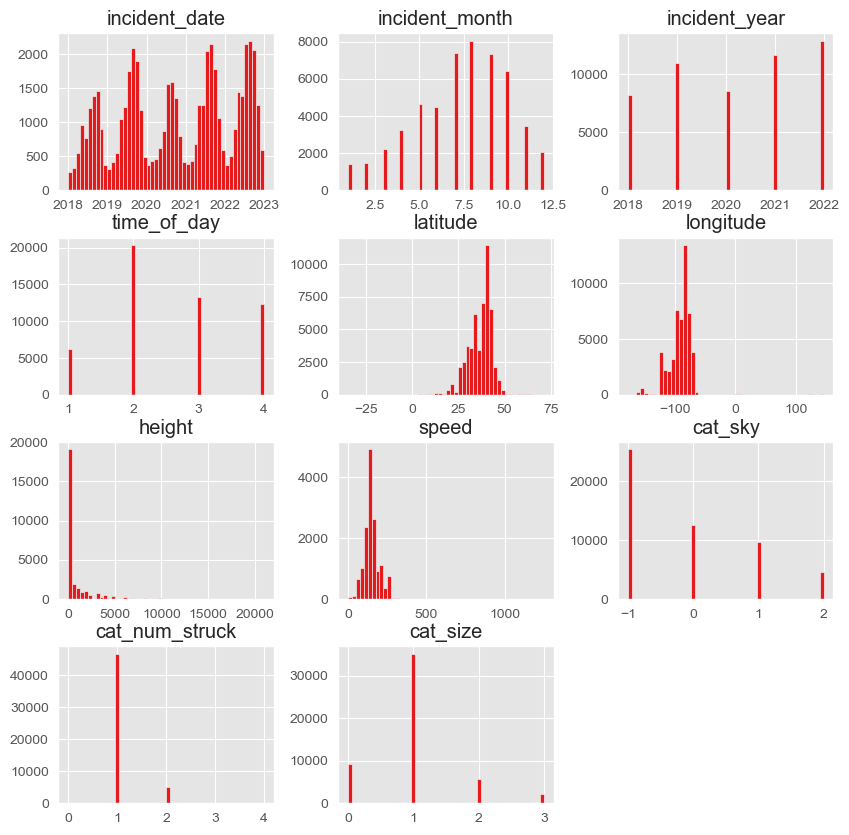

In [186]:
strike.hist(figsize=(10, 10), bins=50);

In [187]:
strike.corr().style.background_gradient()

Есть умеренная линейная зависимость есть между высотой и скоростью.

<div class="alert alert-info">
<b>Промежуточный вывод:</b>

Загруженный датасет размером 46.6+ MB содержал 111 столбцов и 77627 строк.<br><br>

В ходе предобработки все пропуски в столбце time были заменены на 12:00 (по ТЗ). Также были исправлены ошибки в формате записи времени, и оно было округлено до ближайшего часа.
    
Данные из столбца time_of_day были перенесены в столбец lighting_level.   

В столбце time_of_day было закодировано время суток:
    
<table>
  <tr>
    <td><b>Код</b></td>
    <td><b>Время дня</b></td>
    <td><b>Начало периода</b></td>
    <td><b>Конец периода</b></td>
  </tr>
  <tr>
    <td>1</td>
    <td>ночь</td>
    <td>00:00</td>
    <td>06:00</td>
  </tr>
  <tr>
    <td>2</td>
    <td>утро</td>
    <td>07:00</td>
    <td>11:00</td>
  </tr>
  <tr>
    <td>3</td>
    <td>день</td>
    <td>12:00</td>
    <td>17:00</td>
  </tr>
  <tr>
    <td>4</td>
    <td>вечер</td>
    <td>18:00</td>
    <td>23:00</td>
  </tr>
</table>  

Количество столбцов было сокращено до 26 (удалены столбцы с пропусками и малополезными данными).
    
Были удалены пропуски и дубликаты, в том числе, неявные.    

Изменение типов данных для сокращения размерности позволило уменьшить размер датасета.

Столбцы num_struck, size и  sky были категоризированы.

**num_struck**   
    
<table>
  <tr>
    <td><b>Код</b></td>
    <td><b>Значение</b></td>
  </tr>
  <tr>
    <td>0</td>
    <td>unknown</td>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>2</td>
    <td>2-10</td>
  </tr>
  <tr>
    <td>3</td>
    <td>11-100</td>
  </tr>
  <tr>
    <td>4</td>
    <td>More than 100</td>
  </tr>    
</table>      

**size**
<table>
  <tr>
    <td><b>Код</b></td>
    <td><b>Значение</b></td>
  </tr>
  <tr>
    <td>0</td>
    <td>unknown</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Small</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Medium</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Large</td>
  </tr>
</table>       
 
**sky**
    
<table>
  <tr>
    <td><b>Код</b></td>
    <td><b>Значение</b></td>
  </tr>
  <tr>
    <td>-1</td>
    <td>unknown</td>
  </tr>
  <tr>
    <td>0</td>
    <td>No Cloud</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Some Cloud</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Overcast</td>
  </tr>
</table>      
    
Были удалены записи, относящиеся к столкновениям с животными.
    
В результате всех этих действий размер датасета сократился до 8.3+ MB (26 колонок, 52220 строк).
    
Данные за 2018 - 2022 год.
    
</div>   

## Подготовка к анализу данных

In [188]:
strike

cig      dew      slp      tmp           vis             wnd  \
0      22000,5,9,N  -0044,5  10197,5  -0011,5  016093,5,N,5  250,5,N,0036,5   
1      02438,1,C,N  +0260,1  99999,9  +0260,1  009999,1,9,9  060,1,N,0031,1   
2      00884,5,M,N  +0083,5  99999,9  +0094,5  016093,5,N,5  130,5,N,0031,5   
3      22000,5,9,N  +0044,5  10273,5  +0056,5  016093,5,N,5  030,5,N,0026,5   
4      01676,5,M,N  -0172,5  10294,5  -0106,5  016093,5,N,5  250,5,N,0036,5   
...            ...      ...      ...      ...           ...             ...   
52237  00671,5,M,N  +0220,5  99999,9  +0280,5  016093,5,N,5  050,5,N,0026,5   
52238  22000,5,9,N  +0239,5  10102,5  +0261,5  016093,5,N,5  060,5,N,0015,5   
52239  22000,7,9,N  +0030,C  99999,9  +0240,C  020921,5,N,5  999,9,C,0000,5   
52240  02134,5,M,N  +0100,5  10172,5  +0172,5  016093,5,N,5  220,5,N,0046,5   
52241  22000,5,9,N  -0078,5  10249,5  +0106,5  016093,5,N,5  999,9,V,0021,5   

      incident_date  incident_month  incident_year   time  ...  faaregion  \
0        2018-01-09               1           2018  13:00  ...        AEA   
1        2018-01-31               1           2018  02:00  ...        FGN   
2        2018-03-22               3           2018  09:00  ...        ANM   
3        2018-01-07               1           2018  09:00  ...        ASO   
4        2018-01-02               1           2018  12:00  ...        AEA   
...             ...             ...            ...    ...  ...        ...   
52237    2022-10-29              10           2022  16:00  ...        ASO   
52238    2022-10-13              10           2022  21:00  ...        ASO   
52239    2022-10-31              10           2022  23:00  ...        ASW   
52240    2022-04-14               4           2022  22:00  ...        AWP   
52241    2022-12-26              12           2022  06:00  ...        ASW   

                 aircraft  height  speed  cat_sky species_id  \
0      EMB-500 PHENOM 100     NaN    NaN        1       unkb   
1               B-777-200  5000.0  250.0        0      unkbl   
2                 UNKNOWN     NaN    NaN       -1      r2004   
3                 UNKNOWN     NaN    NaN       -1      yi010   
4           SIKORSKY S-76     0.0    NaN        0      unkbs   
...                   ...     ...    ...      ...        ...   
52237             B-737-9     0.0  120.0        1      k5114   
52238               A-321  1800.0  170.0        1       unkb   
52239             B-737-7  3500.0  190.0        0      unkbm   
52240               A-320  3500.0    NaN        1       unkb   
52241           B-737-700    15.0  130.0        0      unkbm   

                     species cat_num_struck  cat_size  lighting_level  
0               unknown bird              1         0             Day  
1       unknown bird - large              1         3           Night  
2            short-eared owl              1         1             Day  
3               tree swallow              1         1             Day  
4       unknown bird - small              1         1             Day  
...                      ...            ...       ...             ...  
52237       american kestrel              1         1             Day  
52238           unknown bird              1         0           Night  
52239  unknown bird - medium              1         2           Night  
52240           unknown bird              1         0           Night  
52241  unknown bird - medium              1         2           Night  

[52242 rows x 26 columns]

In [189]:
wheather_list = ['cig', 'dew', 'slp', 'tmp', 'vis']

In [190]:
for w in wheather_list:
    strike[w] = strike[w].str.split(',', 1, expand=True)[0]    

In [191]:
strike[['wnd_angle', 'wnd_speed']] = strike['wnd'].str.split(',', expand=True)[[0, 3]]

In [192]:
pd.set_option('display.max_columns', 30)

In [193]:
strike = strike.reindex(columns=['incident_date', 'incident_year', 'incident_month', 'time', 'time_of_day', 'lighting_level',
                                'state', 'faaregion', 'airport','airport_id', 'latitude', 'longitude',
                                'aircraft', 'height', 'speed',
                                'species_id', 'species', 'cat_size', 'cat_num_struck',
                                'cat_sky', 'wnd_angle', 'wnd_speed', 'cig', 'vis', 'tmp', 'slp', 'dew'])

In [194]:
strike[['wnd_angle', 'wnd_speed', 'dew', 'tmp']] = strike[['wnd_angle', 'wnd_speed', 'dew', 'tmp']].astype('int16')

In [195]:
strike[['cig', 'slp', 'vis']] = strike[['cig', 'slp', 'vis']].astype('int32')

In [196]:
strike.dew = np.where(strike.dew < 9999, strike.dew / 10, strike.dew)
strike.tmp = np.where(strike.tmp < 9999, strike.tmp / 10, strike.dew)

10 случайных записей таблицы:
________________________________________________________________________________


incident_date  incident_year  incident_month   time  time_of_day  \
36862    2021-09-30           2021               9  12:00            3   
44473    2022-08-27           2022               8  15:00            3   
19676    2020-01-28           2020               1  12:00            3   
17131    2019-10-09           2019              10  15:00            3   
12308    2019-08-22           2019               8  06:00            1   
41173    2022-01-17           2022               1  12:00            3   
21727    2020-07-26           2020               7  00:00            1   
14665    2019-09-01           2019               9  06:00            1   
17323    2019-04-23           2019               4  20:00            4   
50018    2022-11-14           2022              11  23:00            4   

      lighting_level state faaregion  \
36862            Day    NC       ASO   
44473            NaN    LA       ASW   
19676            Day    HI       AWP   
17131            NaN    CA       AWP   
12308            NaN    NV       AWP   
41173            Day    FL       ASO   
21727          Night    UT       ANM   
14665          Night    AK       AAL   
17323            NaN    TX       ASW   
50018          Night    NC       ASO   

                                          airport airport_id  latitude  \
36862                 CHARLOTTE/DOUGLAS INTL ARPT       KCLT  35.21401   
44473        BATON ROUGE METROPOLITAN, RYAN FIELD       KBTR  30.53316   
19676            KALAELOA ARPT JOHN RODGERS FIELD       PHJR  21.30735   
17131                    LIVERMORE MUNICIPAL ARPT       KLVK  37.69340   
12308            HARRY REID INTERNATIONAL AIRPORT       KLAS  36.08036   
41173                       POMPANO BEACH AIRPARK       KPMP  26.24714   
21727                            LOGAN-CACHE ARPT       KLGU  41.78773   
14665                         FAIRBANKS INTL ARPT       PAFA  64.81368   
17323  GEORGE BUSH INTERCONTINENTAL/ HOUSTON ARPT       KIAH  29.98047   
50018                        PITT-GREENVILLE ARPT       KPGV  35.63524   

       longitude              aircraft   height  speed species_id  \
36862  -80.94313             B-737-800    100.0    NaN       unkb   
44473  -91.14963               UNKNOWN      NaN    NaN      yi005   
19676 -158.07030                 C-130      0.0    NaN      o2212   
17131 -121.82035           CITATIONJET      NaN    NaN       unkb   
12308 -115.15233               UNKNOWN      NaN    NaN        o22   
41173  -80.11106                 C-172      0.0    NaN       unkb   
21727 -111.85268  DIAMOND DA42 TWIN ST  10100.0  133.0      unkbs   
14665 -147.85967             B-737-900      NaN    NaN      zs007   
17323  -95.33972               EMB-170   6000.0    NaN       unkb   
50018  -77.38532               EMB-145      NaN    NaN      z6007   

                    species  cat_size  cat_num_struck  cat_sky  wnd_angle  \
36862          unknown bird         0               1        2         10   
44473          barn swallow         1               1       -1        999   
19676            zebra dove         1               1        0         40   
17131          unknown bird         0               1       -1        999   
12308                 doves         1               1       -1        170   
41173          unknown bird         0               1       -1        280   
21727  unknown bird - small         1               1        0        999   
14665      wilson's warbler         1               1        1        999   
17323          unknown bird         0               1       -1        160   
50018        american robin         1               1        0        999   

       wnd_speed    cig    vis   tmp    slp   dew  
36862         21   7620  11265  18.9  10195  17.2  
44473          0    366  16093  27.0  99999  25.0  
19676         15  22000  16093  17.2  10206  15.6  
17131          0  22000  14484   9.4  10124   6.7  
12308         26  22000  16093  34.4  10030  -6.1  
41173         3

Общая информация о таблице:
________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52242 entries, 0 to 52241
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   incident_date   52242 non-null  datetime64[ns]
 1   incident_year   52242 non-null  int16         
 2   incident_month  52242 non-null  int8          
 3   time            52242 non-null  object        
 4   time_of_day     52242 non-null  int8          
 5   lighting_level  33777 non-null  object        
 6   state           52242 non-null  object        
 7   faaregion       52242 non-null  object        
 8   airport         52242 non-null  object        
 9   airport_id      52242 non-null  object        
 10  latitude        52242 non-null  float64       
 11  longitude       52242 non-null  float64       
 12  aircraft        52242 non-null  object        
 1

None

Общие статистические данные:
________________________________________________________________________________


incident_year  incident_month   time_of_day      latitude  \
count   52242.000000    52242.000000  52242.000000  52242.000000   
mean     2020.192087        7.337487      2.605050     36.676921   
std         1.418278        2.673417      0.974395      6.468644   
min      2018.000000        1.000000      1.000000    -34.838417   
25%      2019.000000        6.000000      2.000000     32.895950   
50%      2020.000000        8.000000      2.000000     38.508980   
75%      2021.000000        9.000000      3.000000     40.799350   
max      2022.000000       12.000000      4.000000     71.285450   

          longitude        height         speed      cat_size  cat_num_struck  \
count  52242.000000  27787.000000  15040.000000  52242.000000    52242.000000   
mean     -91.587488    845.140785    145.482314      1.012174        1.104609   
std       22.242260   1818.207612     49.128614      0.667614        0.322557   
min     -177.381000      0.000000      0.000000      0.000000        0.000000   
25%      -98.238610      0.000000    120.000000      1.000000        1.000000   
50%      -87.901480     20.000000    140.000000      1.000000        1.000000   
75%      -81.119540    800.000000    170.000000      1.000000        1.000000   
max      145.729360  21000.000000   1250.000000      3.000000        4.000000   

            cat_sky     wnd_angle     wnd_speed           cig            vis  \
count  52242.000000  52242.000000  52242.000000  52242.000000   52242.000000   
mean      -0.128958    333.586138    106.367444  16191.060641   21654.975097   
std        1.000509    322.755769    850.470709  16924.221616   79832.878496   
min       -1.000000     10.000000      0.000000      0.000000       0.000000   
25%       -1.000000    130.000000     21.000000   2591.000000   16093.000000   
50%        0.000000    220.000000     31.000000  22000.000000   16093.000000   
75%        1.000000    330.000000     46.000000  22000.000000   16093.000000   
max        2.000000    999.000000   9999.000000  99999.000000  999999.000000   

                tmp           slp           dew  
count  52242.000000  52242.000000  52242.000000  
mean      73.935159  22356.557999     88.984105  
std      739.016711  30772.267458    872.734788  
min      -30.600000   9725.000000    -33.300000  
25%       13.900000  10132.000000      6.100000  
50%       20.600000  10168.000000     13.900000  
75%       25.000000  10222.000000     20.000000  
max     9999.000000  99999.000000   9999.000000

Корреляция между столбцами:
________________________________________________________________________________


Пропуски и их доля:
________________________________________________________________________________


number  percent
incident_date        0     0.00
incident_year        0     0.00
incident_month       0     0.00
time                 0     0.00
time_of_day          0     0.00
lighting_level   18465    35.35
state                0     0.00
faaregion            0     0.00
airport              0     0.00
airport_id           0     0.00
latitude             0     0.00
longitude            0     0.00
aircraft             0     0.00
height           24455    46.81
speed            37202    71.21
species_id           0     0.00
species              0     0.00
cat_size             0     0.00
cat_num_struck       0     0.00
cat_sky              0     0.00
wnd_angle            0     0.00
wnd_speed            0     0.00
cig                  0     0.00
vis                  0     0.00
tmp                  0     0.00
slp                  0     0.00
dew                  0     0.00

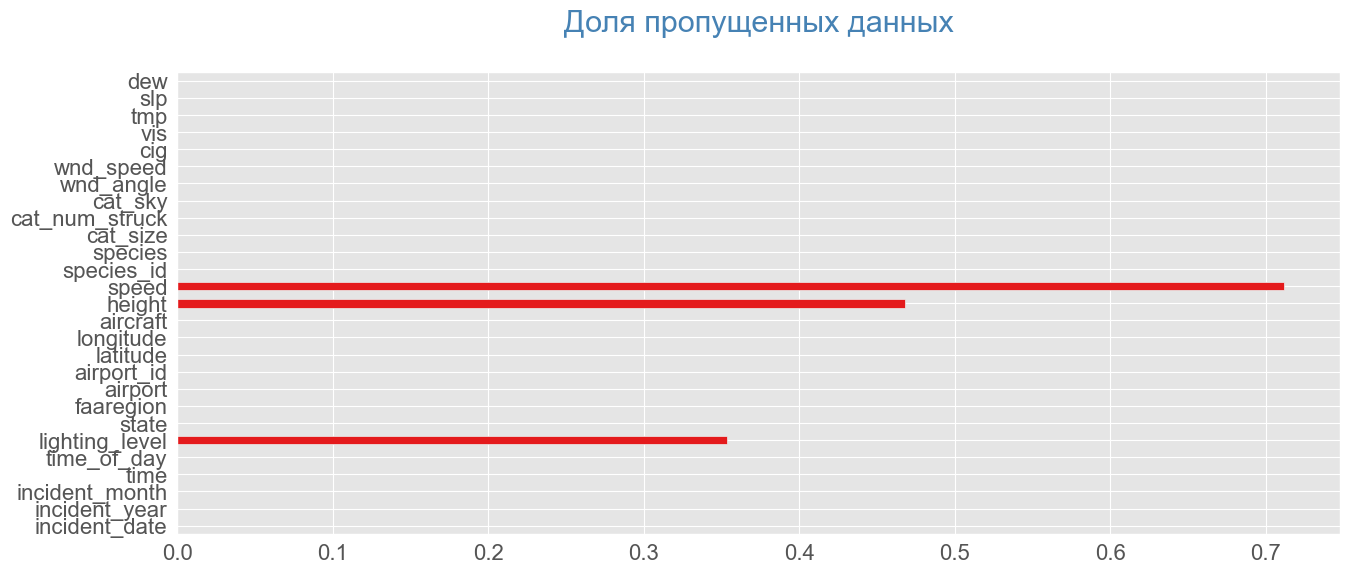

Наличие дубликатов в таблице:
________________________________________________________________________________
Количество дубликатов в датасете: 0
Процентное содержание дубликатов в датасете: 0.00%


In [197]:
primary_info(strike)

<div class="alert alert-info">
<b>Промежуточный вывод:</b>

На этапе подготовки к исследовательскому анализу были распакованы столбцы, содержащии информацию о погодных условиях: cig, dew, slp, tmp, vis, wnd.

<table>
  <tr>
    <td><b>Колонка</b></td>
    <td><b>Расшифровка</b></td>
    <td><b>Диапазон данных</b></td>
    <td><b>Единицы измерения</b></td>
    <td><b>Missing</b></td>
  </tr>
  <tr>
    <td>wnd_angle</td>
    <td>направление ветра</td>
    <td>0 - 360</td>
    <td>градусы</td>
    <td>999</td>
  </tr>
   <tr>
    <td>wnd_speed</td>
    <td>скорость ветра</td>
    <td>0 - 900</td>
    <td>м/с</td>
    <td>9999</td>      
  </tr>
  <tr>
    <td>cig</td>
    <td>состояние неба</td>
    <td>0 - 22000</td>
    <td>м</td>
    <td>99999</td>      
  </tr>
  <tr>
    <td>vis</td>
    <td>видимость</td>
    <td>0 - 160000</td>
    <td>м</td>
    <td>999999</td>      
  </tr>   
  <tr>
    <td>tmp</td>
    <td>температура воздуха</td>
    <td>-100 - +100</td>
    <td><sup>o</sup>C</td>
    <td>9999</td>      
  </tr>     
  <tr>
    <td>slp</td>
    <td>давление</td>
    <td>8600 - 10900</td>
    <td>hPa</td>
    <td>99999</td>      
  </tr>      
  <tr>
    <td>dew</td>
    <td>температура точки росы</td>
    <td>-94 - +94</td>
    <td><sup>o</sup>C</td>
    <td>9999</td>      
  </tr>     
</table>  

Был изменен тип данных в погодных колонках, а также порядок колонок датасета.
    
Существует сильная линейная зависимость между всеми погодными столбцами за исключением cig (состояние неба) и slp (давление).

Размер датасета: 27 столбцов, 52220 строк, 7.5+ MB.    
</div>   

## Исследовательский анализ данных

### Анализ полетов за 20 лет

In [198]:
flights

year  month  domestic  international  total airport
0     2002     10     18939            497  19436    KDEN
1     2002     11     17683            469  18152    KDEN
2     2002     12     19168            510  19678    KDEN
3     2003      1     19163            531  19694    KDEN
4     2003      2     16948            502  17450    KDEN
...    ...    ...       ...            ...    ...     ...
5078  2023      1     13560           1391  14951    KSEA
5079  2023      2     12287           1232  13519    KSEA
5080  2023      3     14068           1416  15484    KSEA
5081  2023      4     14117           1518  15635    KSEA
5082  2023      5     15253           1607  16860    KSEA

[5083 rows x 6 columns]

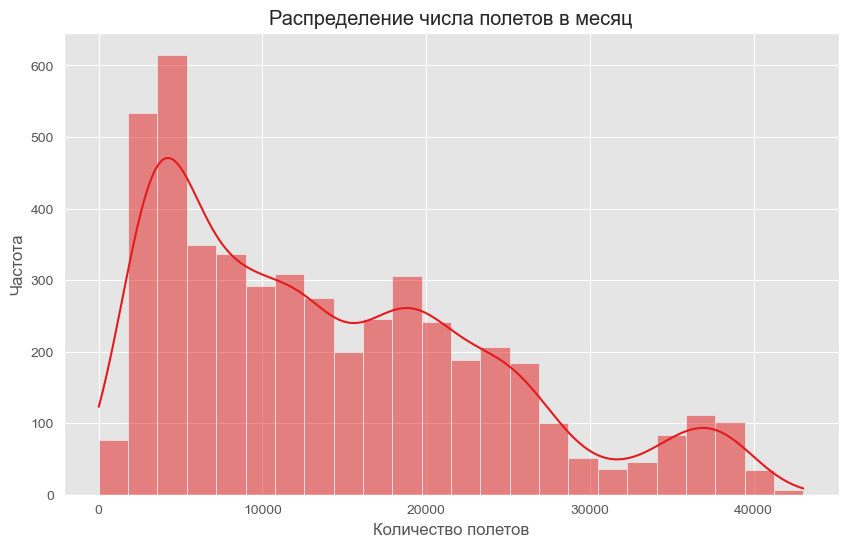

In [199]:
plt.figure(figsize=(10, 6))
sns.histplot(flights.query('year != 2002 and year != 2023')['total'], kde=True, common_norm=True)
plt.title('Распределение числа полетов в месяц')
plt.xlabel('Количество полетов')
plt.ylabel('Частота');

<Figure size 800x600 with 0 Axes>

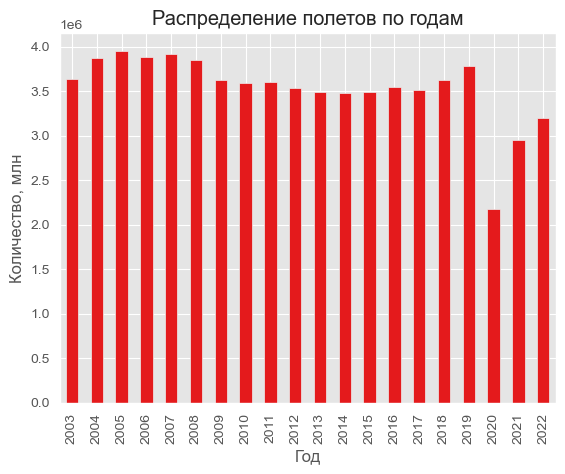

In [200]:
plt.figure(figsize=(8, 6))
flights.query('year != 2002 and year != 2023').groupby('year')['total'].agg('sum').reset_index()\
       .plot(kind='bar', y='total', x='year', legend=False)
plt.title('Распределение полетов по годам')
plt.ylabel('Количество, млн')
plt.xlabel('Год');

Существенное проседание, связанное с пандемией. Даже в 2022 году уровень перелетов все еще не восстановился.

<Figure size 800x600 with 0 Axes>

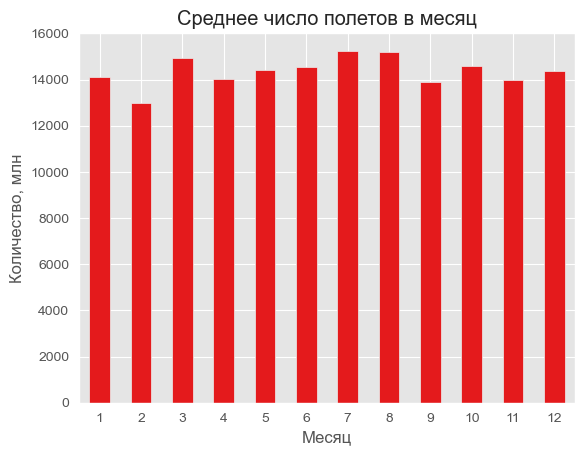

In [201]:
plt.figure(figsize=(8, 6))
flights.groupby('month')['total'].agg('mean').reset_index()\
       .plot(kind='bar', y='total', x='month', rot=0, legend=False)
plt.title('Среднее число полетов в месяц')
plt.ylabel('Количество, млн')
plt.xlabel('Месяц');

Самое маленькое среднее число перелетов в феврале.

In [202]:
airports_years = flights.query('year != 2002 and year != 2023')\
                        .pivot_table(index='airport', columns='year',
                                     values='total', aggfunc='sum', margins=True)\
                        .fillna(0).astype(int)
airports_years

year        2003     2004     2005     2006     2007     2008     2009  \
airport                                                                  
KATL      427223   458323   463881   463644   472369   468830   468446   
KAUS       44302    46366    47223    49220    54497    53061    46567   
KCLT      185619   195507   223571   219763   227189   235403   229965   
KCVG      217650   226950   222303   159536   153055   133480   100427   
KDAL       44189    43947    41382    48870        0    53040    47756   
KDEN      230981   260809   261620   280557   292279   295412   291210   
KDFW      360610   379076   335018   327795   321106   308791   302364   
KDTW      228965   243446   245296   226181   220915   219616   207936   
KFLL       90947   101424   116984   106104   110929   108083    98178   
KIAH      218246   239725   263036   284128   285368   272906   254748   
KJFK      119707   141106   156020   173344   205531   204994   196440   
KLAX      274308   289212   287256   286598   299501   278820   250584   
KMCI       72942    72337    71721    74677    87438    79369    68298   
KMCO      130821   141442   156865   155792   162555   152189   137579   
KMEM      108227   100192   102222   100211    98463    99149    93914   
KORD      433652   465678   454635   448949   440821   419429   395923   
KRSW       27503    30982    36765    36066    37848    36090    33734   
KSDF       35246    33528    36562    31842    34648    32265    29199   
KSEA      164666   167794   159847   159780   163475   163244   150436   
KSLC      132933   144237   167725   150628   153111   142995   138777   
KTEB           0        0        0        0      369        0        0   
KTPA       89294    93427   103924    97841    98993    93423    78719   
All      3638031  3875508  3953856  3881526  3920460  3850589  3621200   

year        2010     2011     2012     2013     2014     2015     2016  \
airport                                                                  
KATL      458187   445553   449759   441391   419365   426365   433215   
KAUS       46974    47755    48696    50866    51932    55158    55945   
KCLT      239653   245243   253893   259851   251138   250222   251587   
KCVG       72762    64518    54641    52048    49163    46824    48260   
KDAL       45647    45970    46753    47092    48318    65622    69421   
KDEN      302217   301543   294265   278746   269505   257075   268677   
KDFW      308131   305210   308816   322972   323051   322070   316353   
KDTW      217534   213484   205754   204589   188057   181801   188029   
KFLL       99225    99710   100812    99703   100687   108516   115297   
KIAH      250792   247929   239089   236105   237502   235322   220028   
KJFK      185786   190973   188570   190925   200016   207089   212604   
KLAX      258208   273715   274217   279092   290104   292870   309292   
KMCI       65907    64980    61354    59550    57307    53827    55274   
KMCO      140617   142265   138169   134195   133442   142160   146317   
KMEM       92661    78750    58025    39246    27230    26432    26284   
KORD      417220   416105   418733   421113   418336   413872   411724   
KRSW       34297    34173    32484    33407    32451    33207    33677   
KSDF           0    28840    26852        0    24674        0        0   
KSEA      148340   149045   146744   150194   160713   181313   195609   
KSLC      135207   126292   117464   116189   115917   113444   118053   
KTEB          14        0        2        0        0       38        0   
KTPA       77035    76606    75557    75834    74813    77602    76087   
All      3596414  3598659  3540649  3493108  3473721  3490829  3551733   

year        2017     2018     2019     2020     2021     2022       All  
airport                                                                  
KATL      423048   429881   433979   259492   334942   343434   8521327  
KAUS       60055    65951    68901    37253    61943    91113   1083778  
KC

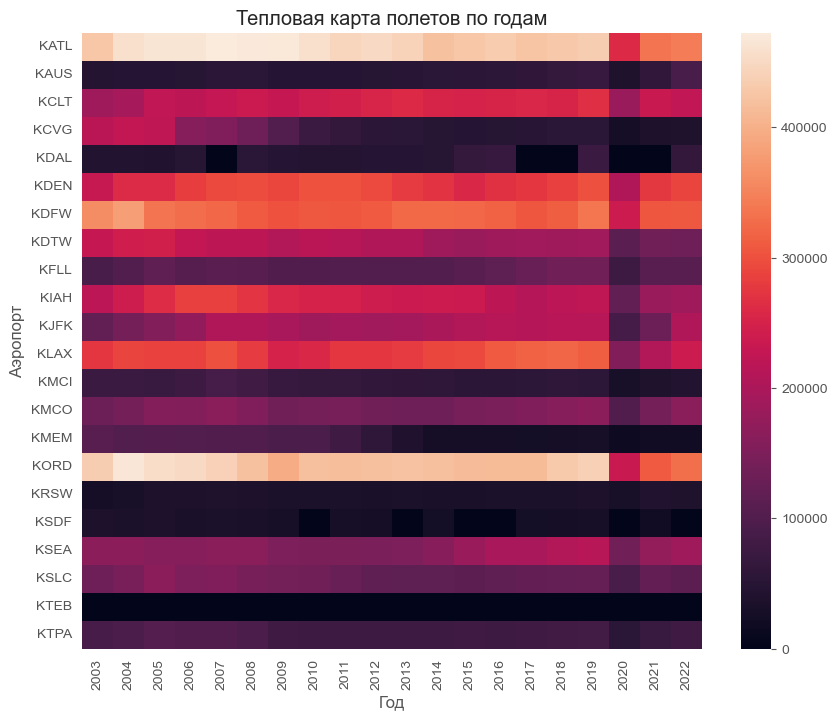

In [203]:
plt.figure(figsize=(10, 8))
sns.heatmap(flights.query('year != 2002 and year != 2023')\
                        .pivot_table(index='airport', columns='year',
                                     values='total', aggfunc='sum')\
                        .fillna(0))
plt.title('Тепловая карта полетов по годам')
plt.ylabel('Аэропорт')
plt.xlabel('Год');

Лидеры по количеству рейсов - международный аэропорт О’Хара, Чикаго, Иллинойс (KORD) и международный аэропорт Хартсфилд, Атланта, Джорджия (KATL).

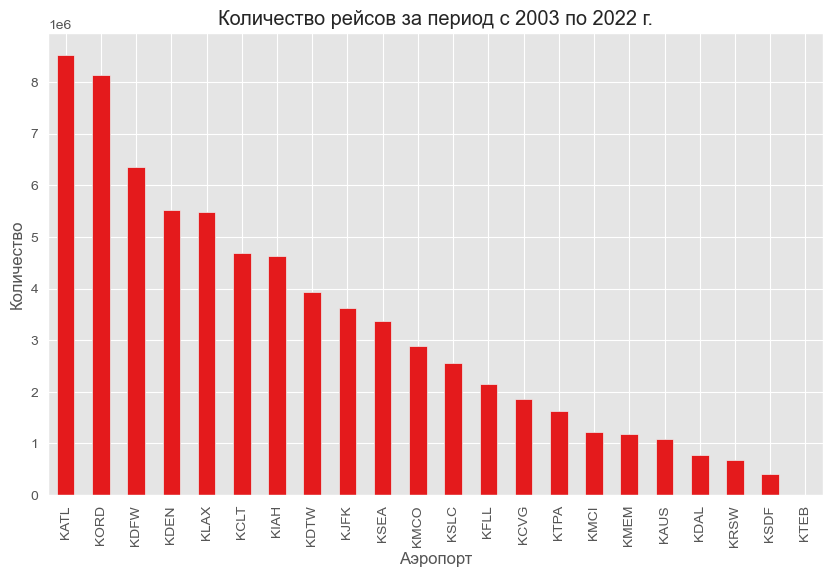

In [204]:
plt.figure(figsize=(10, 6))
airports_years.iloc[0:-1, 20].sort_values(ascending=False).plot(kind='bar');
plt.title('Количество рейсов за период с 2003 по 2022 г.')
plt.xlabel('Аэропорт')
plt.ylabel('Количество');

### Топ-10 аэропортов по числу столкновений (2018 - 2022 г.)

In [205]:
top_10

airport_id              airport  incident_count  year  month  domestic  \
0         KDEN  DENVER INTL AIRPORT            2888  2018      1     20983   
1         KDEN  DENVER INTL AIRPORT            2888  2018      2     18857   
2         KDEN  DENVER INTL AIRPORT            2888  2018      3     22034   
3         KDEN  DENVER INTL AIRPORT            2888  2018      4     21759   
4         KDEN  DENVER INTL AIRPORT            2888  2018      5     22816   
..         ...                  ...             ...   ...    ...       ...   
595       KSLC  SALT LAKE CITY INTL             949  2022      8      9872   
596       KSLC  SALT LAKE CITY INTL             949  2022      9      9291   
597       KSLC  SALT LAKE CITY INTL             949  2022     10      9079   
598       KSLC  SALT LAKE CITY INTL             949  2022     11      8550   
599       KSLC  SALT LAKE CITY INTL             949  2022     12      8503   

     international  total  
0             1006  21989  
1              878  19735  
2             1080  23114  
3              987  22746  
4              991  23807  
..             ...    ...  
595            354  10226  
596            318   9609  
597            300   9379  
598            277   8827  
599            326   8829  

[600 rows x 8 columns]

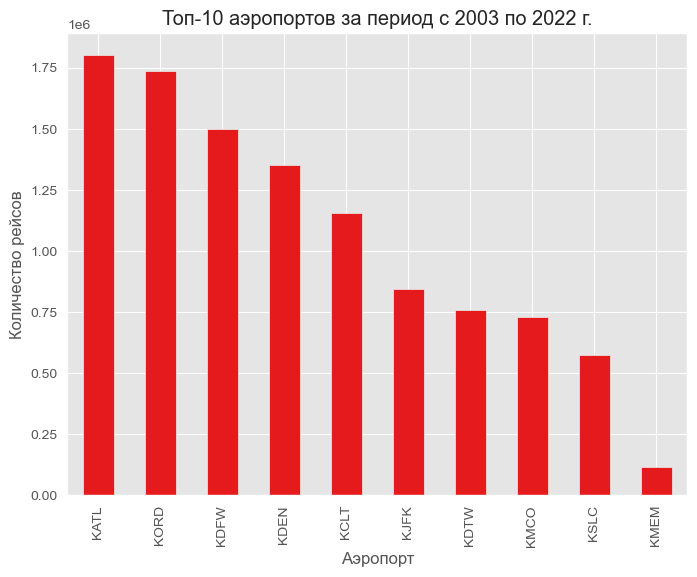

In [206]:
plt.figure(figsize=(8, 6))
top_10.groupby('airport_id')['total'].agg('sum').sort_values(ascending=False).plot(kind='bar');
plt.title('Топ-10 аэропортов за период с 2003 по 2022 г.')
plt.xlabel('Аэропорт')
plt.ylabel('Количество рейсов');

Процентное соотношений столкновений к общему числу рейсов:

In [207]:
incident_share = top_10.groupby(['airport_id'])['total', 'incident_count']\
                       .agg({'total':'sum', 'incident_count':'first'})

incident_share['percent'] = round(100 * incident_share['incident_count'] / incident_share['total'], 2)
incident_share.sort_values(by='percent', ascending=False)

total  incident_count  percent
airport_id                                  
KMEM         113937            1224     1.07
KDEN        1353496            2888     0.21
KDTW         757577            1284     0.17
KSLC         573471             949     0.17
KJFK         846423            1107     0.13
KMCO         728907             976     0.13
KDFW        1498576            1820     0.12
KORD        1738418            1478     0.09
KATL        1801728            1370     0.08
KCLT        1157633             958     0.08

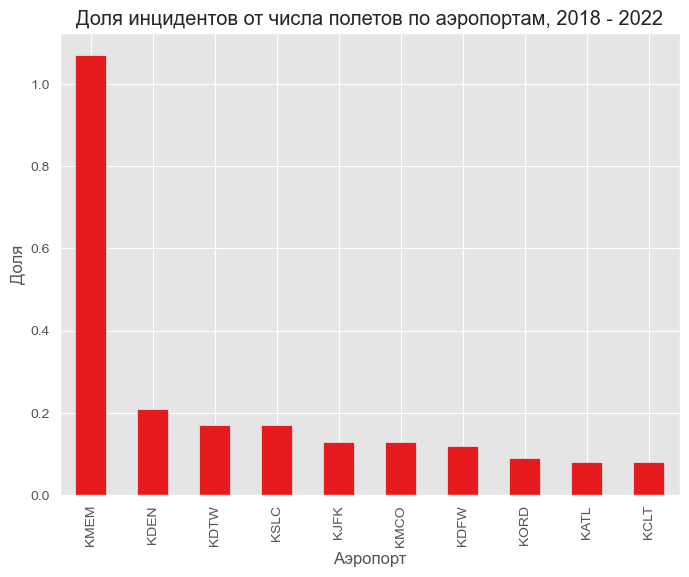

In [208]:
incident_share['percent'].sort_values(ascending=False).plot(kind='bar', figsize=(8, 6), label='')
plt.title('Доля инцидентов от числа полетов по аэропортам, 2018 - 2022')
plt.xlabel('Аэропорт')
plt.ylabel('Доля')           
plt.show();

Самый высокий процент столкновений у международного аэропорта Мемфиса, Теннесси, занимающего последнее место в топ-10. Самый низкий - у международного аэропорта имени Дугласа, Северная Каролина.

### География

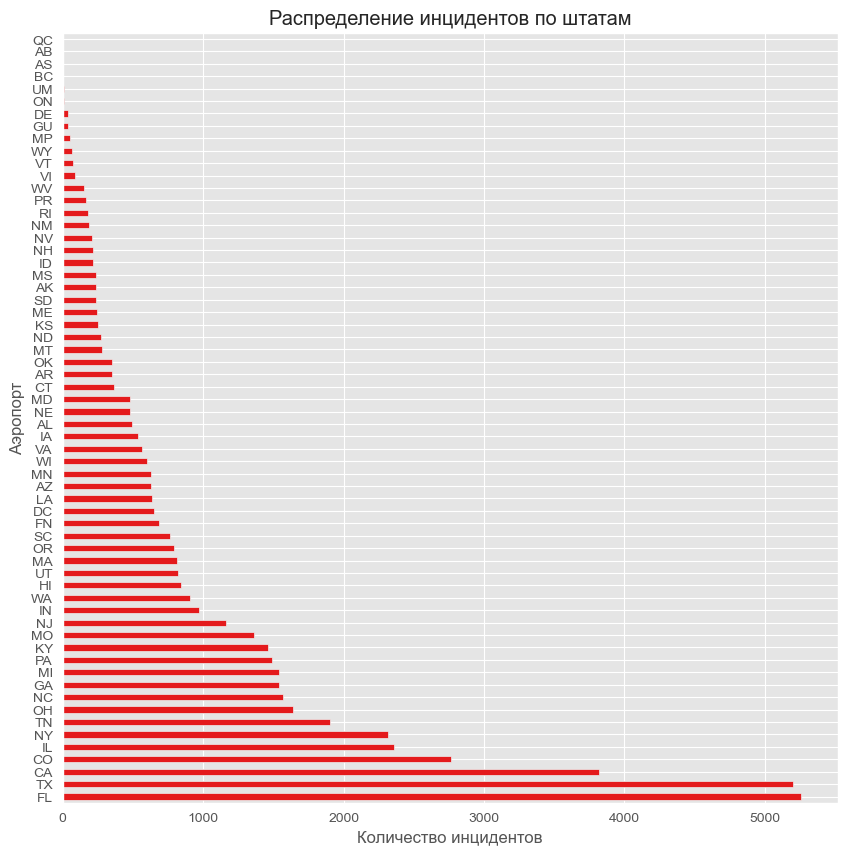

In [209]:
strike.groupby('state')['incident_date'].agg('count')\
      .sort_values(ascending=False).plot(kind='barh', figsize=(10, 10), label='')
plt.title('Распределение инцидентов по штатам')
plt.ylabel('Аэропорт')
plt.xlabel('Количество инцидентов')
plt.show();

In [210]:
top_7_state = strike.groupby('state')['incident_date'].agg('count')\
                        .reset_index().sort_values(by='incident_date', ascending=False)
df1 = top_7_state[:6]
df2 = pd.DataFrame(data = {
    'state' : ['others'],
    'incident_date' : [top_7_state['incident_date'][6:].sum()]
})
top_7_state = pd.concat([df1, df2])

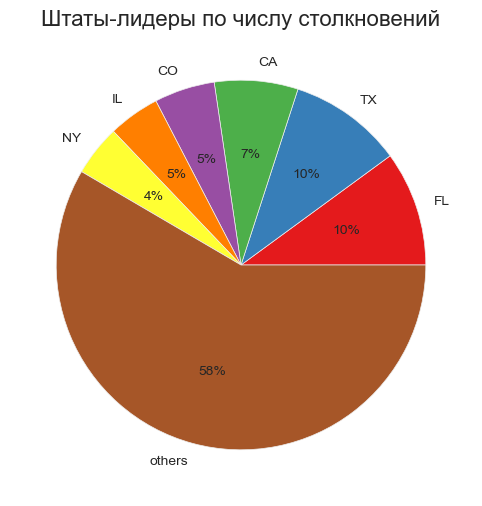

In [211]:
top_7_state.plot(kind = 'pie', y = 'incident_date', labels = top_7_state['state'], figsize=(10, 6), 
                 autopct='%1.0f%%', legend=False, label='', startangle=0)
plt.title('Штаты-лидеры по числу столкновений', fontsize=16)
plt.show();

Лидеры по числу столкновений - штаты Флорида, Техас и Калифорния.

Объединяющие признаки:

- выход к морю (океану),
- субтропический океанический  или средиземноморский климатический пояса,
- жаркий или теплый климат (Флорида и Техас входят в топ-5 самых жарких штатов США, Калифорния занимает 13 место),
- высокая влажность (в Калифорнии только на побережье).

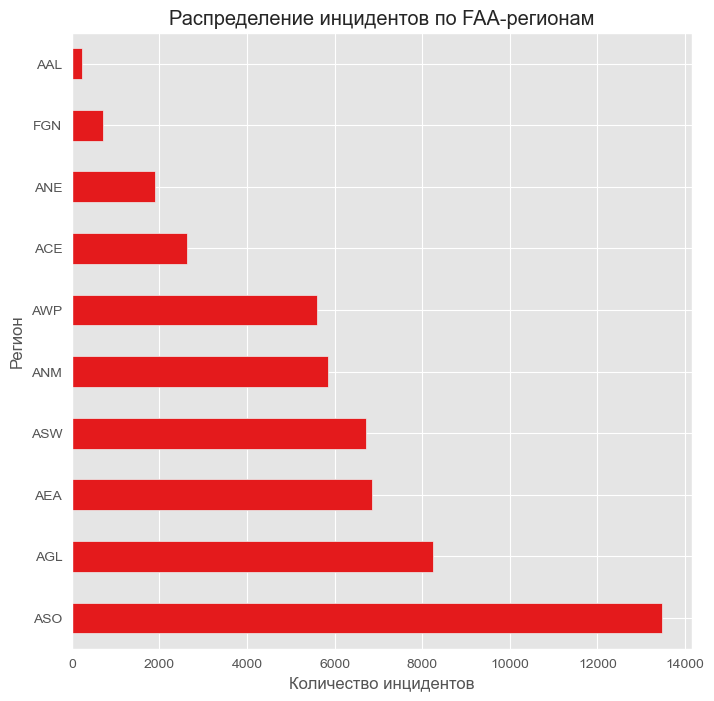

In [212]:
strike.groupby('faaregion')['incident_date'].agg('count')\
      .sort_values(ascending=False).plot(kind='barh', figsize=(8, 8), label='')
plt.title('Распределение инцидентов по FAA-регионам')
plt.ylabel('Регион')
plt.xlabel('Количество инцидентов')
plt.show();

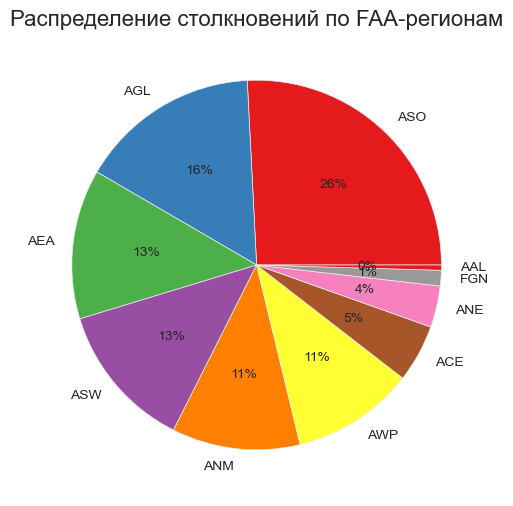

In [213]:
strike.groupby('faaregion')['incident_date'].agg('count')\
      .sort_values(ascending=False)\
      .plot(kind = 'pie', y = 'incident_date', figsize=(10, 6), 
                 autopct='%1.0f%%', legend=False, label='', startangle=0)
plt.title('Распределение столкновений по FAA-регионам', fontsize=16)
plt.show();

- ASW – Southwest
- ANM – Northwest Mountain
- AEA – Eastern
- ASO – Southern
- AGL – Great Lakes
- ACE – Central
- ANE – New England
- AWP – Western Pacific
- AAL – Alaska

- All other regions of the world are considered foreign regions (FGN)

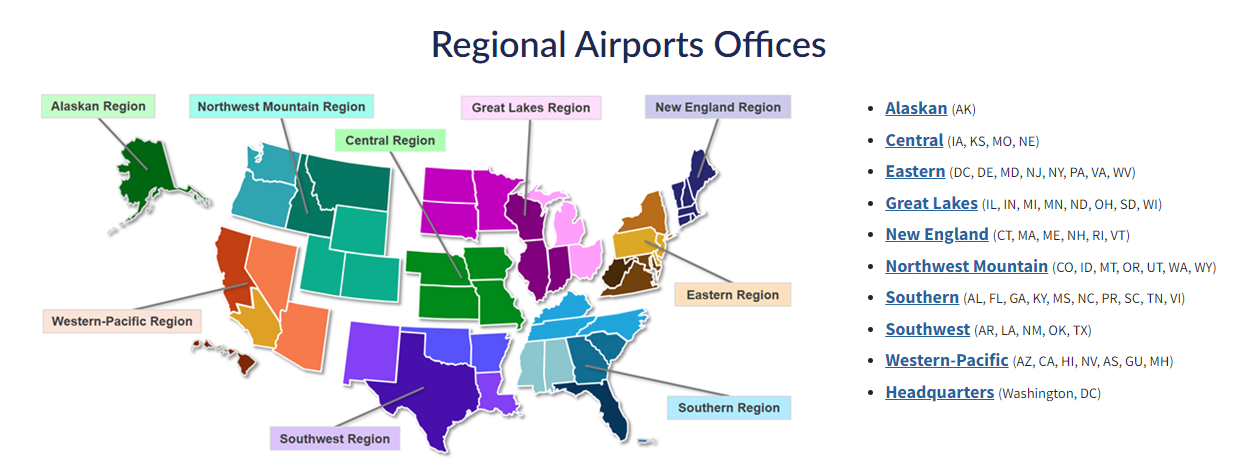

Лидер по числу столкновений - Южный регион, куда входят Техас и Флорида, что подтверждает статистику по штатам. 

На втором месте - Великие озера. Климат умеренный, но влажный; не побережье, но большое количество водных пространств.

Наименьшее количество столкновений в регионах Аляска и Новая Англия.

Международный аэропорт Мемфиса (Теннесси), у которого самая высокая доля инцидентов по отношению к числу полетов, также расположен в Южном FAA-регионе наряду с Флоридой. Теннесси отличает влажный, жаркий субтропический климат. Мемфис расположен на восточном берегу реки Миссисипи.

Абсолютное число столкновений не дает полной картины, посмотрим на отношение числа инцидентов к общему количеству полетов.

In [214]:
strikes_amount = strike.groupby('airport_id')['incident_date', 'faaregion', 'state'].agg({'incident_date':'count', 'faaregion':'first', 'state':'first'})\
                       .reset_index().rename(columns={'airport_id':'airport', 'incident_date':'incident_amount'})
strikes_amount

airport  incident_amount faaregion state
0       06FA                2       ASO    FL
1        19N                1       AEA    NJ
2        1A5                1       ASO    NC
3        1G0                6       AGL    OH
4        1G3                6       AGL    OH
...      ...              ...       ...   ...
1289     Y70                1       AGL    MI
1290    ZBAA                1       FGN    FN
1291    ZGGG               18       FGN    FN
1292    ZGSZ                3       FGN    FN
1293    ZSPD               13       FGN    FN

[1294 rows x 4 columns]

In [215]:
flights_amount = flights.query('year > 2017 and year < 2023')\
                        .groupby('airport')['total'].agg('sum').reset_index()
flights_amount

airport    total
0     KATL  1801728
1     KAUS   325161
2     KCLT  1157633
3     KCVG   206619
4     KDAL   136628
5     KDEN  1353496
6     KDFW  1498576
7     KDTW   757577
8     KFLL   567662
9     KIAH   927342
10    KJFK   846423
11    KLAX  1230991
12    KMCI   225484
13    KMCO   728907
14    KMEM   113937
15    KORD  1738418
16    KRSW   179080
17    KSDF    75229
18    KSEA   918277
19    KSLC   573471
20    KTPA   367467

In [216]:
strike['airport_id'].value_counts()

KDEN    2090
KDFW    1396
KORD    1206
KMEM    1017
KATL    1004
        ... 
4CA0       1
7A5        1
KBIJ       1
KHBV       1
KMMV       1
Name: airport_id, Length: 1294, dtype: int64

In [217]:
incidents_share = flights_amount.merge(strikes_amount, how='left')
incidents_share['percent'] = round(100 * incidents_share.incident_amount / incidents_share.total, 2)
incidents_share.sort_values(by='percent', ascending=False)

airport    total  incident_amount faaregion state  percent
14    KMEM   113937             1017       ASO    TN     0.89
17    KSDF    75229              568       ASO    KY     0.76
4     KDAL   136628              485       ASW    TX     0.35
3     KCVG   206619              677       ASO    KY     0.33
16    KRSW   179080              444       ASO    FL     0.25
12    KMCI   225484              547       ACE    MO     0.24
1     KAUS   325161              558       ASW    TX     0.17
5     KDEN  1353496             2090       ANM    CO     0.15
20    KTPA   367467              487       ASO    FL     0.13
19    KSLC   573471              744       ANM    UT     0.13
7     KDTW   757577              851       AGL    MI     0.11
10    KJFK   846423              883       AEA    NY     0.10
8     KFLL   567662              517       ASO    FL     0.09
6     KDFW  1498576             1396       ASW    TX     0.09
13    KMCO   728907              616       ASO    FL     0.08
15    KORD  1738418             1206       AGL    IL     0.07
2     KCLT  1157633              758       ASO    NC     0.07
9     KIAH   927342              597       ASW    TX     0.06
0     KATL  1801728             1004       ASO    GA     0.06
11    KLAX  1230991              603       AWP    CA     0.05
18    KSEA   918277              491       ANM    WA     0.05

Второй по доле инцидентов аэропорт - международный аэропорт Луисвилла, Кентукки, FAA-регион - ASO (Южный).

Топ-5 аэропортов с самой высокой долей инцидентов расположены в Южном и Юго-Западном регионе.

Следующий в списке аэропорт KMCI - международный аэропорт Канзас-Сити, штат Миссури. Для Миссури характерен влажный континентальный климат с холодной зимой и жарким и влажным летом. В южной части штата климат переходит к влажному субтропическому. Аэропорт расположен недалеко от озера Berlin Reservoir, в пределах 10 км протекает река Миссури.

### Погодные условия

Изучим погодные условия регионов с наибольшим числом столкновений, чтобы получить более точную картину. 

In [218]:
faa_strike = strike.query('faaregion == "ASO" or faaregion == "ASW"')
faa_strike.head(5)

incident_date  incident_year  incident_month   time  time_of_day  \
3     2018-01-07           2018               1  09:00            2   
11    2018-02-15           2018               2  16:00            3   
12    2018-02-16           2018               2  17:00            3   
13    2018-01-11           2018               1  07:00            2   
17    2018-01-03           2018               1  12:00            3   

   lighting_level state faaregion                                     airport  \
3             Day    FL       ASO                 SOUTHWEST FLORIDA INTL ARPT   
11            Day    TX       ASW  GEORGE BUSH INTERCONTINENTAL/ HOUSTON ARPT   
12            NaN    OK       ASW                      WILL ROGERS WORLD ARPT   
13            NaN    LA       ASW                          LAFAYETTE REGIONAL   
17            Day    NM       ASW                    ALBUQUERQUE INTL SUNPORT   

   airport_id  latitude  longitude   aircraft  height  speed species_id  \
3        KRSW  26.53617  -81.75517    UNKNOWN     NaN    NaN      yi010   
11       KIAH  29.98047  -95.33972    EMB-145   500.0    NaN      unkbs   
12       KOKC  35.39309  -97.60073    UNKNOWN     0.0    NaN      k3302   
13       KLFT  30.20528  -91.98766  B-757-200    50.0    NaN      n5111   
17       KABQ  35.04022 -106.60919  B-717-200     0.0    NaN      yh004   

                 species  cat_size  cat_num_struck  cat_sky  wnd_angle  \
3           tree swallow         1               1       -1         30   
11  unknown bird - small         1               1        1        170   
12       red-tailed hawk         2               1       -1         20   
13              killdeer         1               2        2        180   
17           horned lark         1               2        0         10   

    wnd_speed    cig    vis   tmp    slp   dew  
3          26  22000  16093   5.6  10273   4.4  
11         46    305  11265  22.8  99999  19.4  
12         82   5486  16093   1.7  10296  -6.7  
13         21     91   4828  15.6  10116  15.6  
17         41   7315  16093  -0.6  10283 -15.6

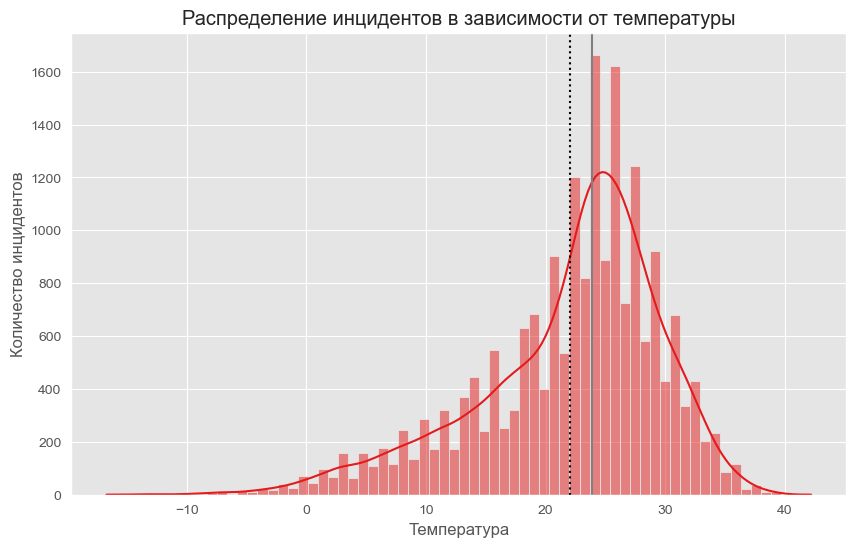

In [219]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.query('tmp < 9999').tmp, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от температуры')
plt.xlabel('Температура')
plt.ylabel('Количество инцидентов')
plt.axvline(faa_strike.query('tmp < 9999').tmp.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.query('tmp < 9999').tmp.median(), color='grey')
plt.show();

Медианная температура около 24 градусов Цельсия, средняя - 22 градуса.

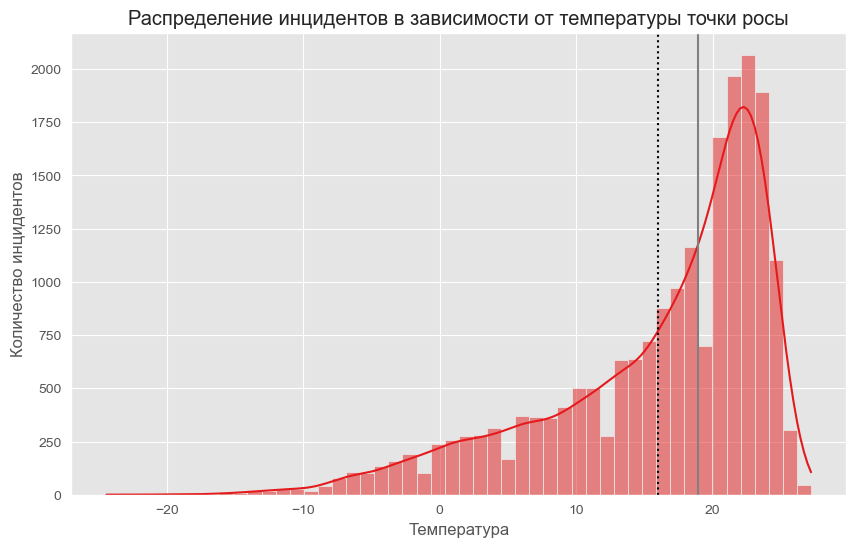

In [220]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.query('dew < 9999').dew, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от температуры точки росы')
plt.xlabel('Температура')
plt.ylabel('Количество инцидентов')
plt.axvline(faa_strike.query('dew < 9999').dew.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.query('dew < 9999').dew.median(), color='grey')
plt.show();

Средняя температура точки росы - 16 градусов, медианная - почти 19 градусов.

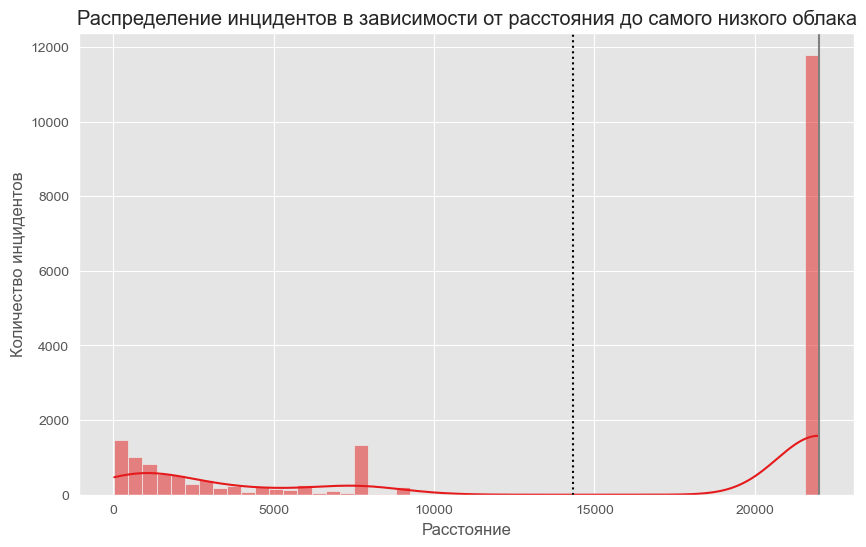

In [221]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.query('cig <= 22000').cig, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от расстояния до самого низкого облака')
plt.xlabel('Расстояние')
plt.ylabel('Количество инцидентов')
plt.axvline(faa_strike.query('cig <= 22000').cig.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.query('cig <= 22000').cig.median(), color='grey')
plt.show();

Среднее расстояние до самого низкого облака 14346 метров, медианное - 22000.

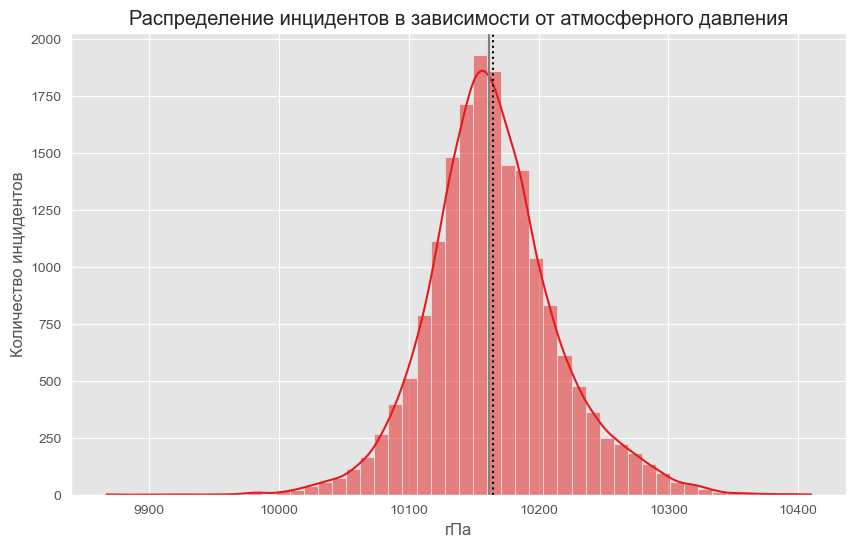

In [222]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.query('slp <= 10900').slp, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от атмосферного давления')
plt.xlabel('гПа')
plt.ylabel('Количество инцидентов')
plt.axvline(faa_strike.query('slp <= 10900').slp.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.query('slp <= 10900').slp.median(), color='grey')
plt.show();

Среднее давление 10164 кПа, медианное - 10162 гПа.

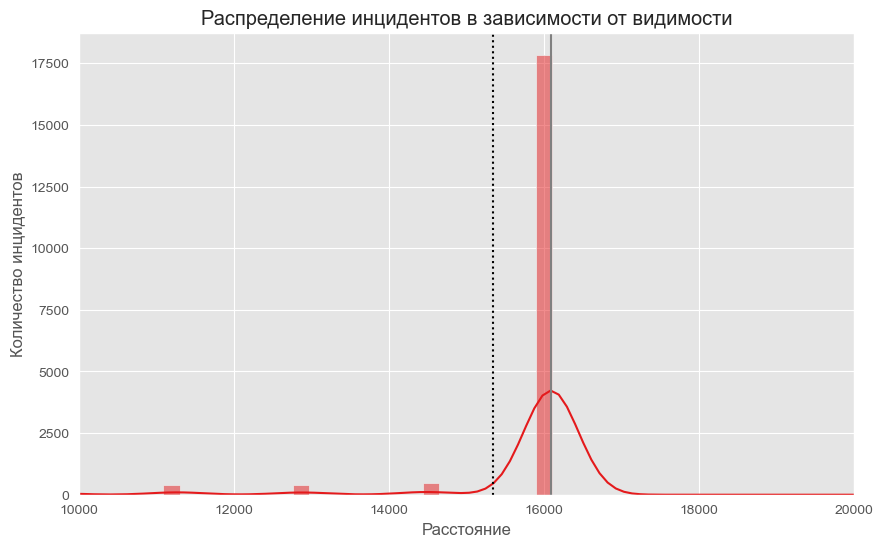

In [223]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.query('vis <= 160000').vis, kde=True, common_norm=True, bins=100)
plt.title('Распределение инцидентов в зависимости от видимости')
plt.xlabel('Расстояние')
plt.ylabel('Количество инцидентов')
plt.xlim(10000, 20000)
plt.axvline(faa_strike.query('vis <= 160000').vis.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.query('vis <= 160000').vis.median(), color='grey')
plt.show();

Средняя видимость 15340 метров, медианная - 16093 метра.

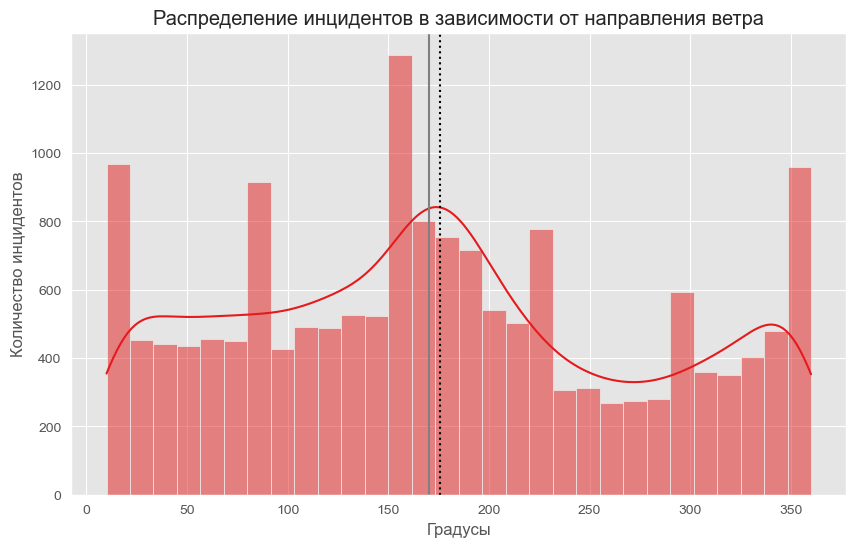

In [224]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.query('wnd_angle <= 360').wnd_angle, kde=True, common_norm=True, bins=30)
plt.title('Распределение инцидентов в зависимости от направления ветра')
plt.xlabel('Градусы')
plt.ylabel('Количество инцидентов')
plt.axvline(faa_strike.query('wnd_angle <= 360').wnd_angle.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.query('wnd_angle <= 360').wnd_angle.median(), color='grey')
plt.show();

Средний угол ветра - 176 градусов, медианный - 170 градусов.

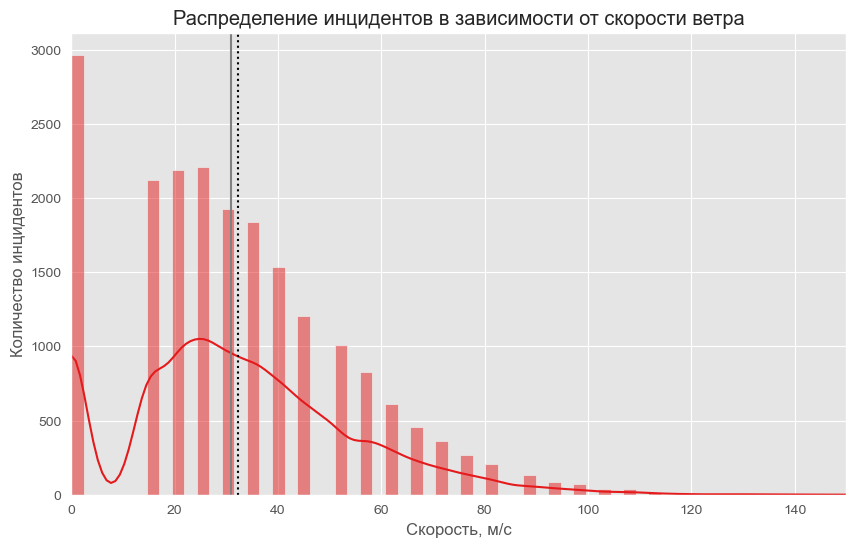

In [225]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.query('wnd_speed != 9999').wnd_speed, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от скорости ветра')
plt.xlabel('Скорость, м/с')
plt.ylabel('Количество инцидентов')
plt.xlim(0, 150)
plt.axvline(faa_strike.query('wnd_speed != 9999').wnd_speed.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.query('wnd_speed != 9999').wnd_speed.median(), color='grey')
plt.show();

Средняя скорость ветра - 32 метра в секунду, медианная - 31 м/с.

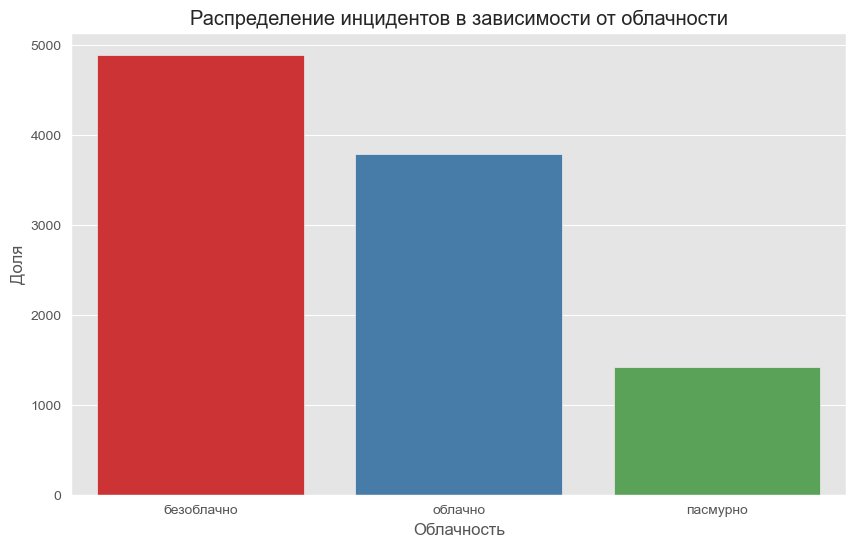

In [226]:
plt.figure(figsize=(10, 6))
sns.countplot(data=faa_strike.query('cat_sky != -1'), x='cat_sky')
plt.title('Распределение инцидентов в зависимости от облачности')
plt.ylabel('Доля')
plt.xlabel('Облачность')
plt.xticks([0, 1, 2],
           ['безоблачно', 'облачно', 'пасмурно'],
           rotation=0)
plt.show();

Большая часть инцидентов происходит в безоблачную погоду, меньшая - в пасмурную.

### Временные характеристики

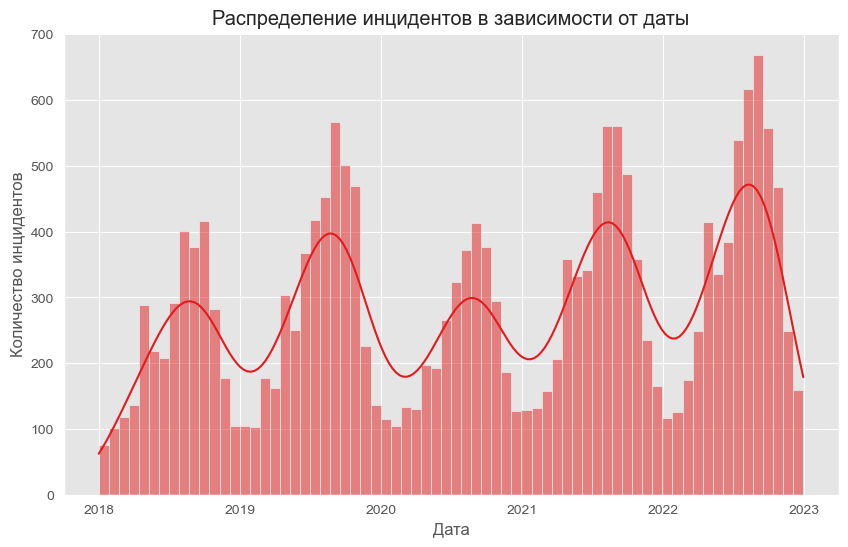

In [227]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.incident_date, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от даты')
plt.xlabel('Дата')
plt.ylabel('Количество инцидентов')
plt.show();

Самое больше количество столкновений в 2022 году, несмотря на что по абсолютным показателям число полетов в 2018 и 2019 годах выше. Возможно, это связано с увеличением популяций птиц за период пандемии.

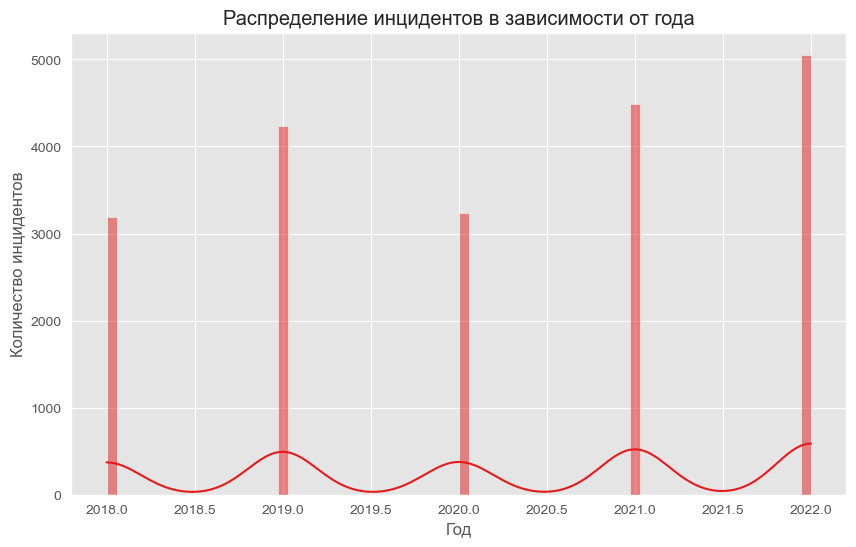

In [228]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.incident_year, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от года')
plt.xlabel('Год')
plt.ylabel('Количество инцидентов')
plt.show();

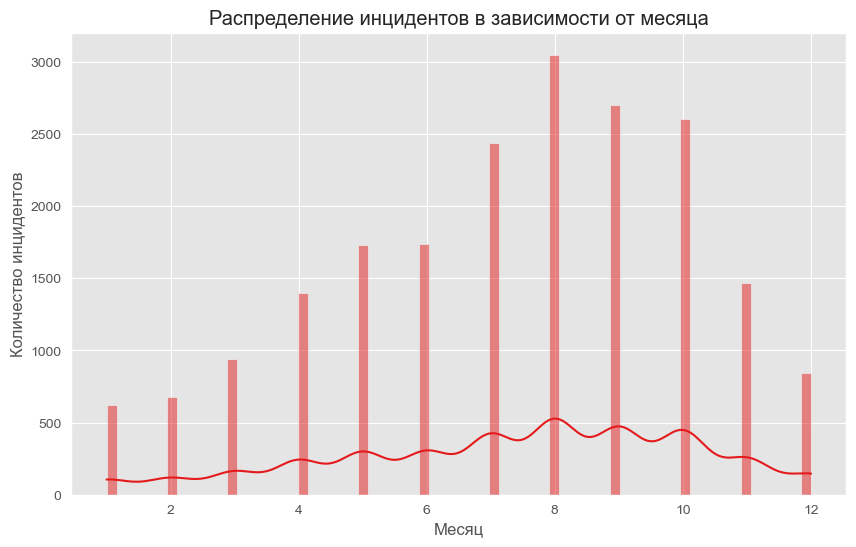

In [229]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.incident_month, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от месяца')
plt.xlabel('Месяц')
plt.ylabel('Количество инцидентов')
plt.show();

В теплые месяцы (с июля по октябрь) столкновений больше.

In [230]:
top_10.groupby('month')['total'].agg(['mean', 'median']).astype(int).style.background_gradient()

Очевидно, это связано не только с возрастанием активности птиц в летние месяцы, но и с увеличением числа рейсов.

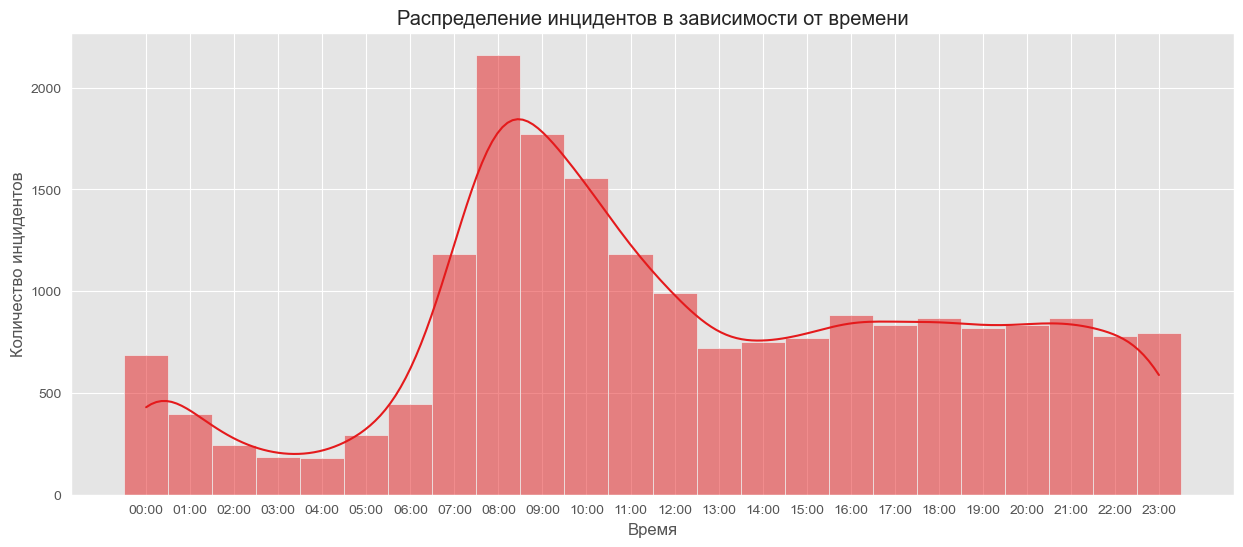

In [231]:
plt.figure(figsize=(15, 6))
sns.histplot(data=faa_strike.time.sort_values(), kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от времени')
plt.xlabel('Время')
plt.ylabel('Количество инцидентов')
plt.show();

Максимальное количество совпадений приходится на 8 часов утра.

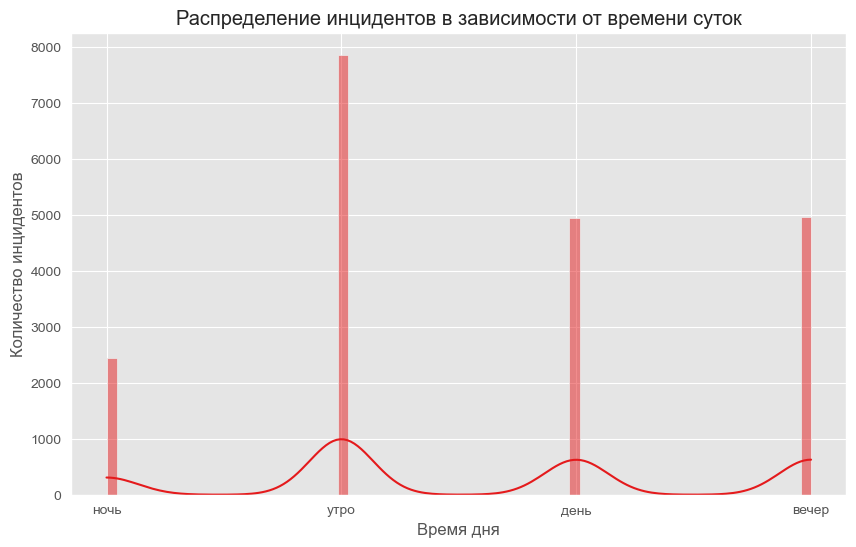

In [232]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.time_of_day, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от времени суток')
plt.xlabel('Время дня')
plt.ylabel('Количество инцидентов')
plt.xticks([1, 2, 3, 4],
           ['ночь', 'утро', 'день', 'вечер'],
           rotation=0)
plt.show();

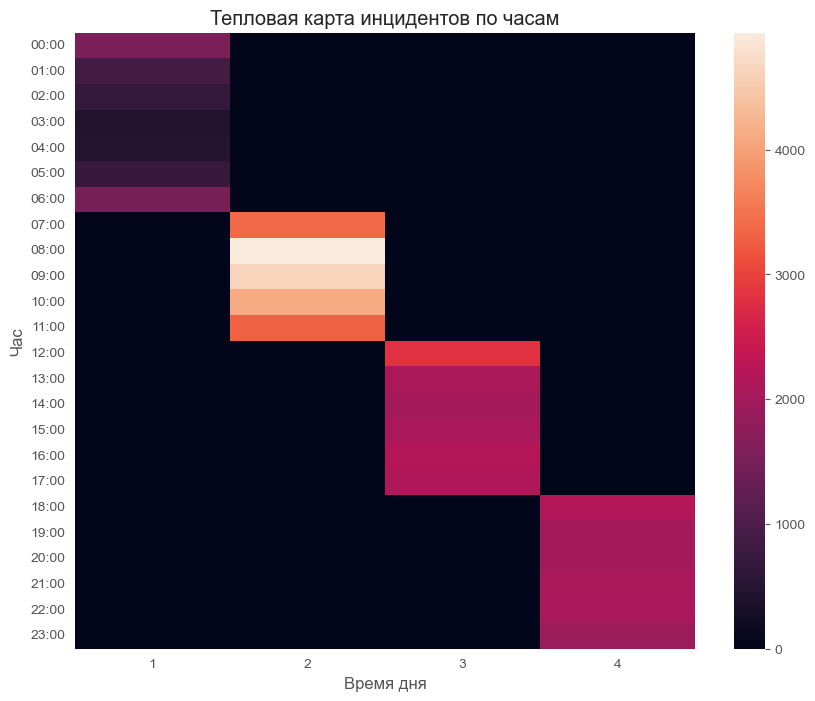

In [233]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.crosstab(strike['time'], strike['time_of_day']))
plt.title('Тепловая карта инцидентов по часам')
plt.ylabel('Час')
plt.xlabel('Время дня');

Меньше всего столкновений в 3 и 4 часа ночи.

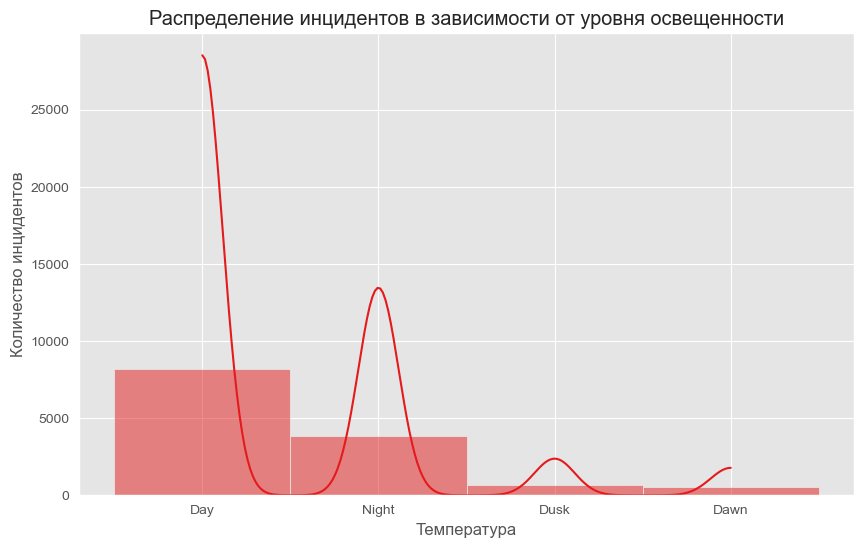

In [234]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike['lighting_level'], kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от уровня освещенности')
plt.xlabel('Температура')
plt.ylabel('Количество инцидентов')
plt.show();

Очевидно, на количество столкновений влияют циркадные и сезонные циклы птиц.

Распределение активности у многих дневных птиц имеет бимодальный характер с пиками в утренние и предзакатные часы. Однако в зимнее время года активность не мигрирующих птиц более равномерна и интенсивна в светлое время суток.

Полученный график отражает смешение записей о столкновении самолетов с дневными и ночными птицами без учета времен года.

### Характеристики полета

In [235]:
faa_strike.speed.mean()

149.7908002520479

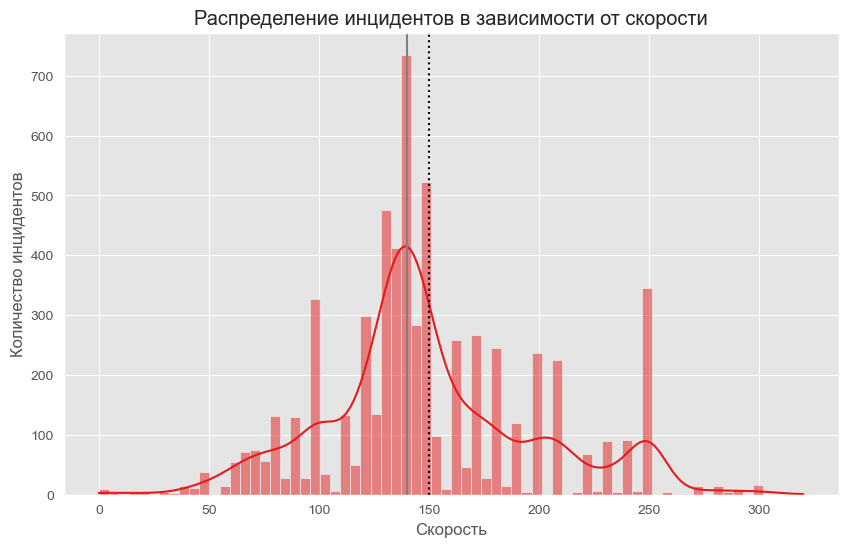

In [236]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.speed, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от скорости')
plt.xlabel('Скорость')
plt.ylabel('Количество инцидентов')
plt.axvline(faa_strike.speed.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.speed.median(), color='grey')
plt.show();

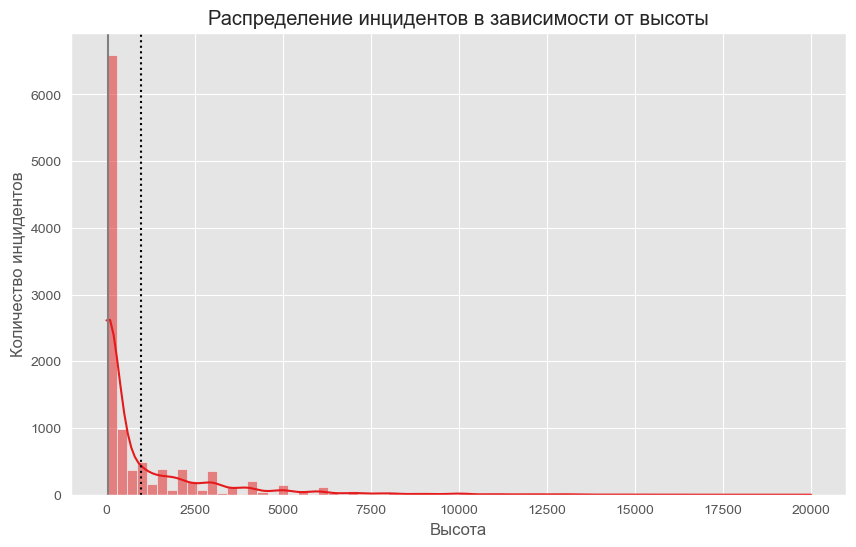

In [237]:
plt.figure(figsize=(10, 6))
sns.histplot(data=faa_strike.height, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от высоты')
plt.xlabel('Высота')
plt.ylabel('Количество инцидентов')
plt.axvline(faa_strike.height.mean(), color='black', linestyle=':')
plt.axvline(faa_strike.height.median(), color='grey')
plt.show();

In [238]:
faa_strike.height.value_counts(normalize=True)

0.0       0.429035
1000.0    0.035663
500.0     0.035122
100.0     0.034492
200.0     0.033411
            ...   
501.0     0.000090
1020.0    0.000090
7200.0    0.000090
1665.0    0.000090
9300.0    0.000090
Name: height, Length: 218, dtype: float64

43% столкновений происходит на высоте 0 км.

### Характеристики птиц

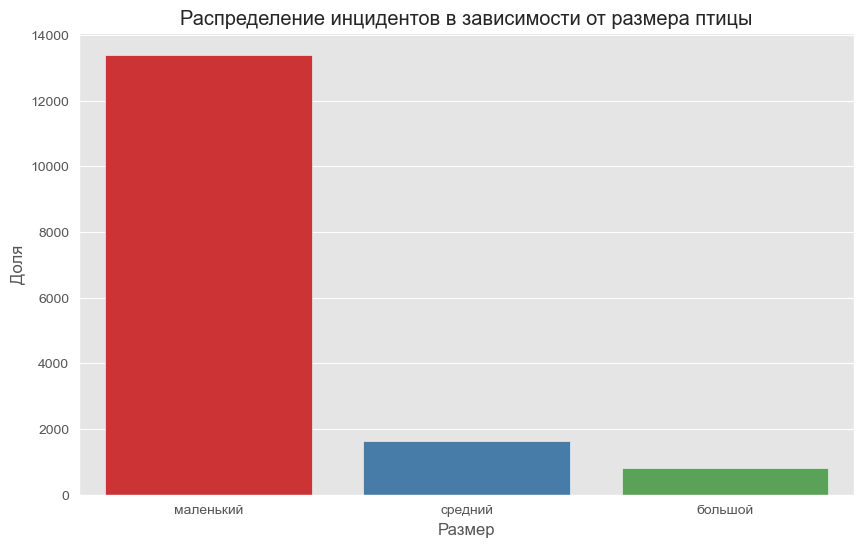

In [239]:
plt.figure(figsize=(10, 6))
sns.countplot(data=faa_strike.query('cat_size != 0'), x='cat_size')
plt.title('Распределение инцидентов в зависимости от размера птицы')
plt.ylabel('Доля')
plt.xlabel('Размер')
plt.xticks([0, 1, 2],
           ['маленький', 'средний', 'большой'],
           rotation=0)
plt.show();

In [240]:
faa_strike.query('species != "unknown bird" and species != "unknown bird - small" and \
                 species != "unknown bird - medium" and species != "unknown bird - large"')\
          .species.value_counts(normalize=True).head(20)

mourning dove         0.145846
barn swallow          0.095912
killdeer              0.089143
eastern meadowlark    0.057758
american kestrel      0.051604
european starling     0.031560
rock pigeon           0.025407
cattle egret          0.018989
chimney swift         0.018198
red-tailed hawk       0.017846
cliff swallow         0.017407
common nighthawk      0.016176
turkey vulture        0.016176
laughing gull         0.012308
swallows              0.012220
american robin        0.011429
tree swallow          0.011429
sparrows              0.010813
meadowlarks           0.009846
black vulture         0.009055
Name: species, dtype: float64

### Матрица корреляции

In [241]:
#plt.figure(figsize=(10, 10))
#sns.heatmap(strike.phik_matrix())
#plt.title('Тепловая карта корреляции признаков');

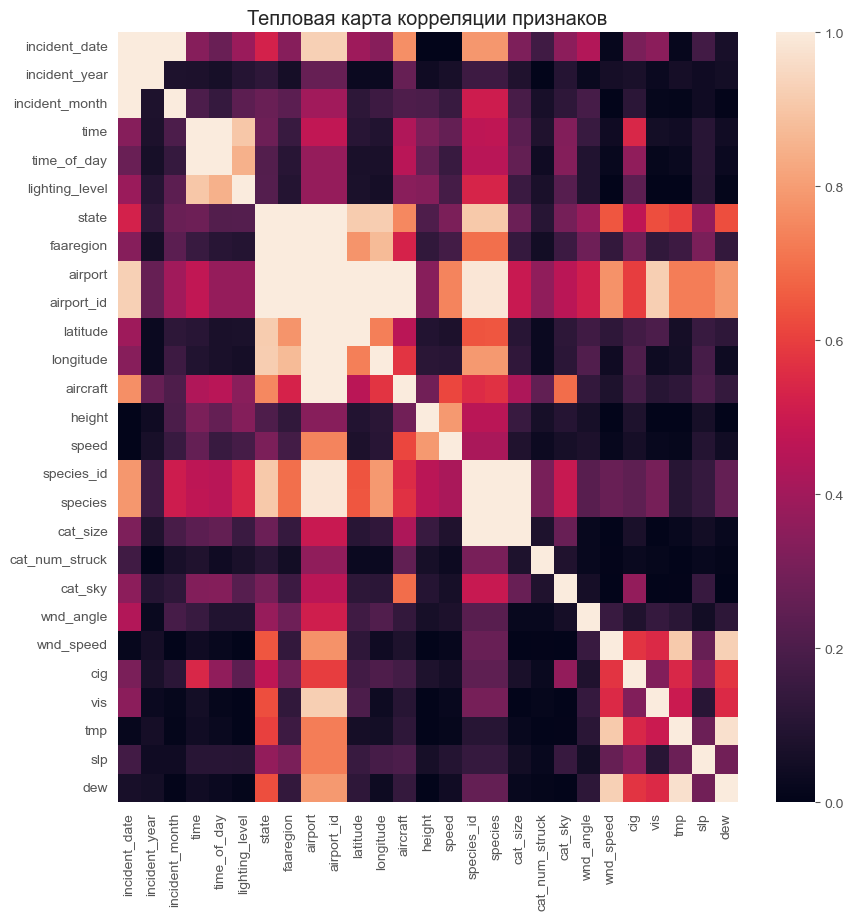

In [242]:
#strike.phik_matrix().style.background_gradient()

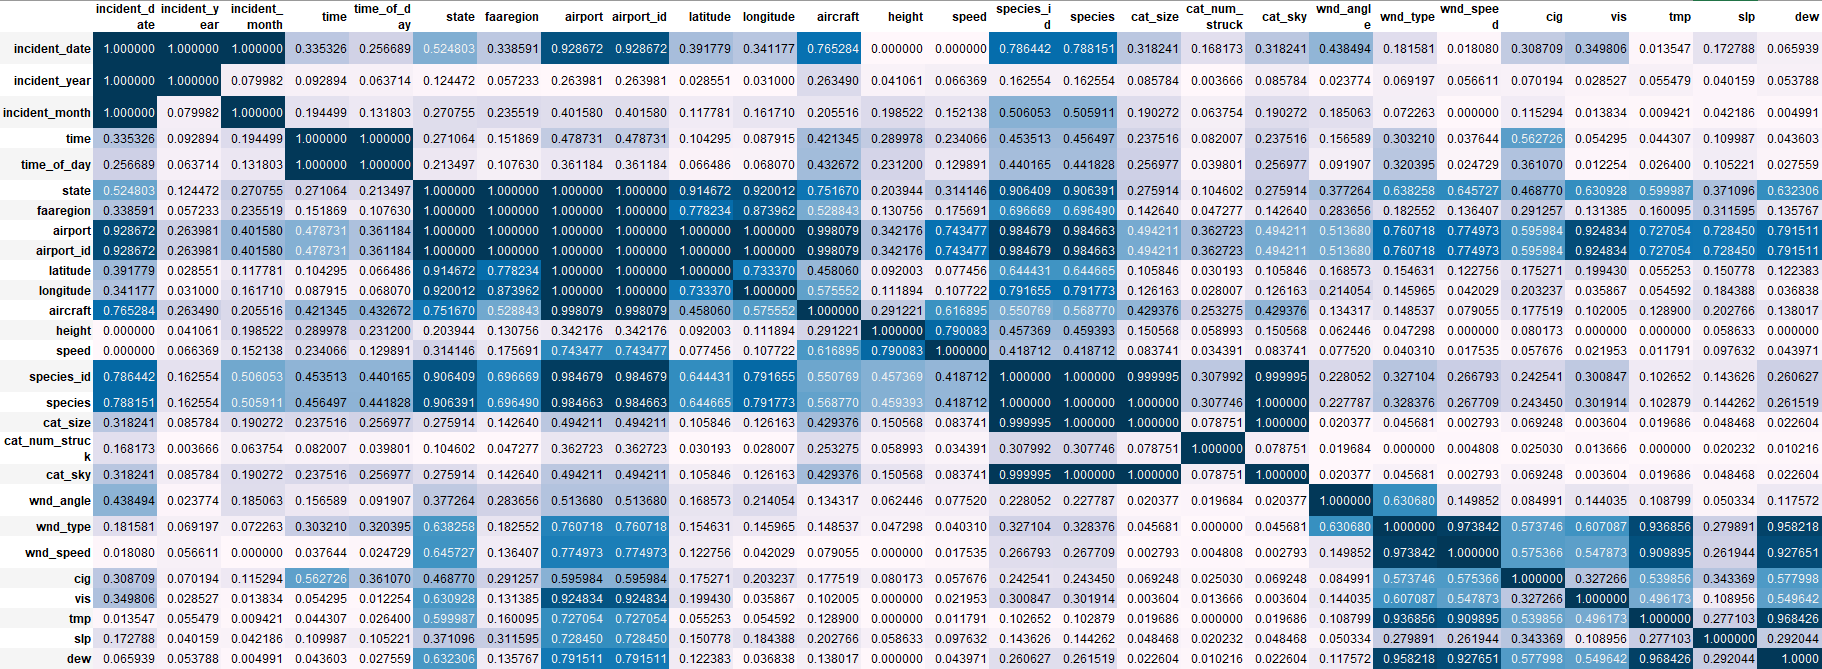

Есть нелинейная зависимость между погодными условиями и штатом, аэропортом. Самая слабая корреляция из погодных условий у атмосферного давления (slp)

Больше всего связей у столбцов со штатами, аэропортами и датой инцидента.

У видов птиц есть сильная корреляция со штатом, аэропортом и размером (cat_size), умеренная - с долготой, широтой,FAA-регионом и датой инцидента, чуть слабее с самолетом, месяцем и уровнем освещенности.

Из анализа можно исключить:
- incident_year,
- height,
- speed,
- cat_size,
- cat_num_struck.

In [243]:
#plt.figure(figsize=(10, 10))
#sns.heatmap(strike.significance_matrix())
#plt.title('Тепловая карта значимости признаков');

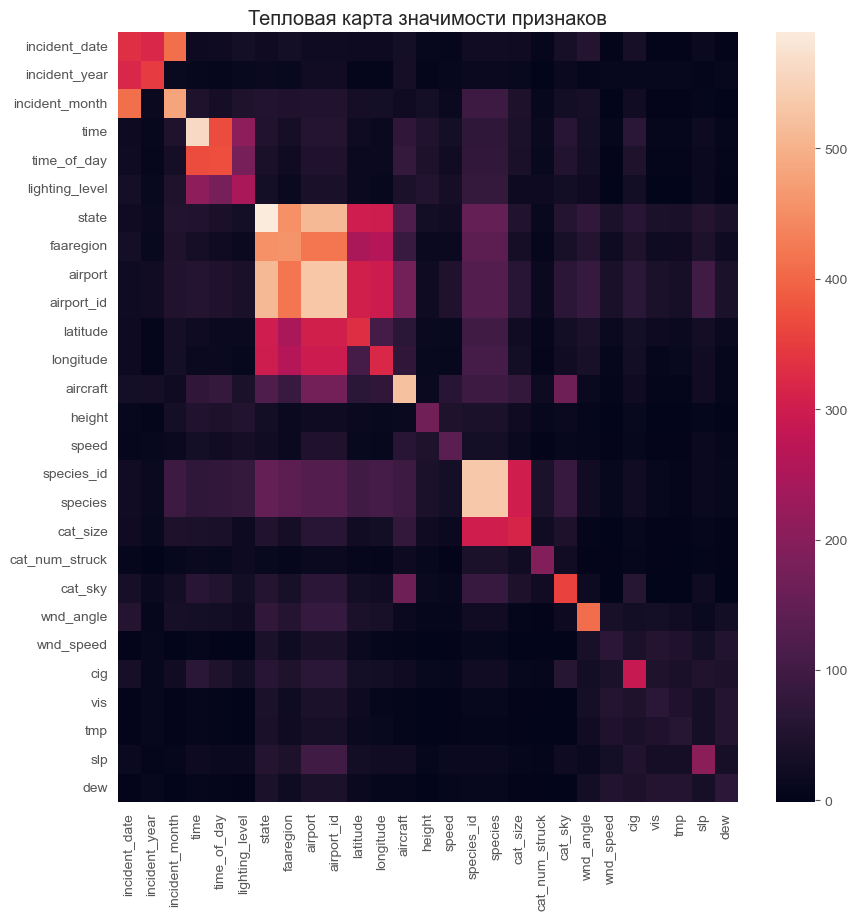

In [244]:
#strike.significance_matrix().style.background_gradient()

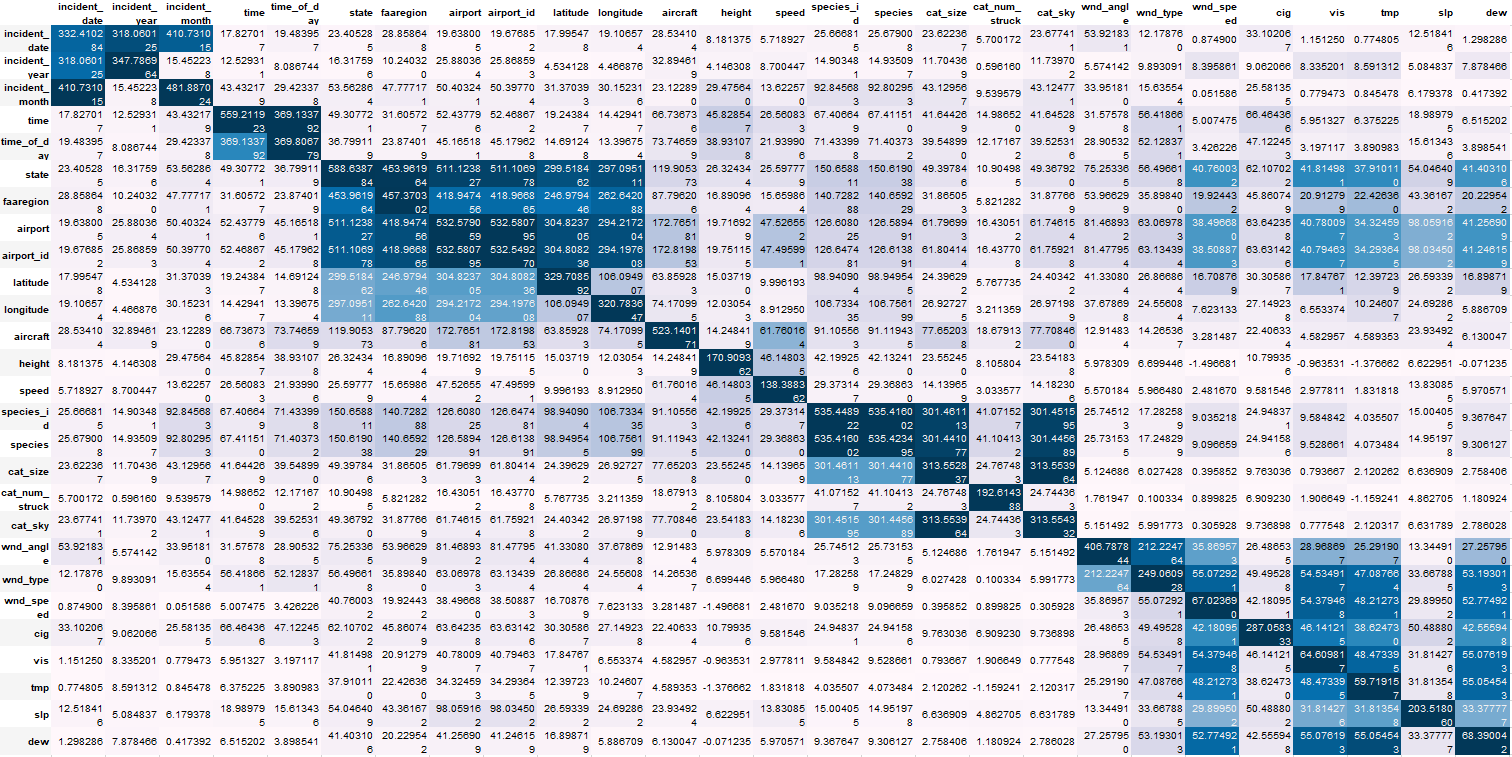

Судя по матрице значимости признаков, виды птиц коррелируют с географическими и временными признаками и не коррелируют с погодными. 

Очевидно, на столкновения птиц с самолетами сильнее влияют время года и географическое положение, то есть, климат (теплый и влажный).

### Промежуточный вывод

<div class="alert alert-info">
Проведенный анализ позволяет сделать следующие выводы.
    
**Количество полетов**
    
Наблюдается существенное проседание, связанное с пандемией. Даже в 2022 году уровень перелетов все еще не восстановился.

Самое маленькое среднее число перелетов в феврале. Самое большое - в июле и августе.

Лидеры по количеству рейсов - международный аэропорт О’Хара, Чикаго, Иллинойс (KORD) и международный аэропорт Хартсфилд, Атланта, Джорджия (KATL).
    
**Столкновения**    

Самое больше количество столкновений в 2022 году, несмотря на что по абсолютным показателям число полетов в 2018 и 2019 годах выше. Возможно, это связано с увеличением популяций птиц за период пандемии.

В теплые месяцы (с июля по октябрь) столкновений больше. Очевидно, это связано не только с возрастанием активности птиц в летние месяцы, но и с увеличением числа рейсов.

Максимальное количество совпадений приходится на 8 часов утра.

Очевидно, на количество столкновений влияют циркадные и сезонные циклы птиц.

46% столкновений происходит на высоте 0 км.
    
Самый высокий процент столкновений у международного аэропорта Мемфиса, Теннесси, занимающего последнее место в топ-10 аэропортов по числу инцидентов. Самый низкий - у международного аэропорта имени Дугласа, Северная Каролина.

Лидеры по числу столкновений - штаты Флорида, Техас и Калифорния.

Наименьшее количество столкновений в регионах Аляска и Новая Англия.

Топ-5 аэропортов с самой высокой долей инцидентов расположены в Южном и Юго-Западном регионе.

Следующий в списке аэропорт KMCI - международный аэропорт Канзас-Сити, штат Миссури. Для Миссури характерен влажный континентальный климат с холодной зимой и жарким и влажным летом. В южной части штата климат переходит к влажному субтропическому. Аэропорт расположен недалеко от озера Berlin Reservoir, в пределах 10 км протекает река Миссури.
    
Объединяющие признаки:

- выход к морю (океану),
- субтропический океанический  или средиземноморский климатический пояса,
- жаркий или теплый климат (Флорида и Техас входят в топ-5 самых жарких штатов США, Калифорния занимает 13 место),
- высокая влажность (в Калифорнии только на побережье).

**Погодные условия регионов с наибольшим числом столкновений**

Медианная температура около 24 градусов Цельсия, средняя - 22 градуса.
Средняя температура точки росы - 16 градусов, медианная - почти 19 градусов.
Среднее расстояние до самого низкого облака 14346 метров, медианное - 22000.
Среднее давление 10164 кПа, медианное - 10162 гПа.
Средняя видимость 15340 метров, медианная - 16093 метра.
Средний угол ветра - 176 градусов, медианный - 170 градусов.
Средняя скорость ветра - 32 метра в секунду, медианная - 31 м/с.

Большая часть инцидентов происходит в безоблачную погоду, меньшая - в пасмурную.
    
**Корреляция признаков**
    
Есть нелинейная зависимость между погодными условиями и штатом, аэропортом. Самая слабая корреляция из погодных условий у атмосферного давления (slp)

Больше всего связей у столбцов со штатами, аэропортами и датой инцидента.

У видов птиц есть сильная корреляция со штатом, аэропортом и размером (cat_size), умеренная - с долготой, широтой,FAA-регионом и датой инцидента, чуть слабее с самолетом, месяцем и уровнем освещенности.

Из анализа можно исключить:
- incident_year,
- height,
- speed,
- cat_size,
- cat_num_struck.
    
Судя по матрице значимости признаков, виды птиц коррелируют с географическими и временными признаками и не коррелируют с погодными.

Очевидно, на столкновения птиц с самолетами сильнее влияют время года и географическое положение, то есть, климат (теплый и влажный), а не погодные условия.    
</div>   

## Проверка гипотез

Разобьем датасет на две группы. В первую включим все записи о столкновениях рейсов, вылетевших из аэропортов с самым высоким относительным числом столкновений. В группу Б войдут записи о столкновениях рейсов из всех остальных аэропортов из датасета incidents_share.

In [245]:
incidents_share.sort_values(by='percent', ascending=False)

airport    total  incident_amount faaregion state  percent
14    KMEM   113937             1017       ASO    TN     0.89
17    KSDF    75229              568       ASO    KY     0.76
4     KDAL   136628              485       ASW    TX     0.35
3     KCVG   206619              677       ASO    KY     0.33
16    KRSW   179080              444       ASO    FL     0.25
12    KMCI   225484              547       ACE    MO     0.24
1     KAUS   325161              558       ASW    TX     0.17
5     KDEN  1353496             2090       ANM    CO     0.15
20    KTPA   367467              487       ASO    FL     0.13
19    KSLC   573471              744       ANM    UT     0.13
7     KDTW   757577              851       AGL    MI     0.11
10    KJFK   846423              883       AEA    NY     0.10
8     KFLL   567662              517       ASO    FL     0.09
6     KDFW  1498576             1396       ASW    TX     0.09
13    KMCO   728907              616       ASO    FL     0.08
15    KORD  1738418             1206       AGL    IL     0.07
2     KCLT  1157633              758       ASO    NC     0.07
9     KIAH   927342              597       ASW    TX     0.06
0     KATL  1801728             1004       ASO    GA     0.06
11    KLAX  1230991              603       AWP    CA     0.05
18    KSEA   918277              491       ANM    WA     0.05

In [246]:
incidents_share.sort_values(by='percent', ascending=False).airport.unique()

array(['KMEM', 'KSDF', 'KDAL', 'KCVG', 'KRSW', 'KMCI', 'KAUS', 'KDEN',
       'KTPA', 'KSLC', 'KDTW', 'KJFK', 'KFLL', 'KDFW', 'KMCO', 'KORD',
       'KCLT', 'KIAH', 'KATL', 'KLAX', 'KSEA'], dtype=object)

In [247]:
top_list = ['KMEM', 'KSDF', 'KDAL', 'KCVG', 'KRSW', 'KMCI']
outsiders_list = ['KAUS', 'KDEN', 'KTPA', 'KSLC', 'KDTW', 'KJFK', 
                  'KFLL', 'KDFW', 'KMCO', 'KORD', 'KCLT', 'KIAH', 'KATL', 'KLAX', 'KSEA']

In [248]:
hypotesis = strike.query('incident_year > 2017 and incident_year < 2023')

In [249]:
group_a = hypotesis.query('airport_id in @top_list')
group_a

incident_date  incident_year  incident_month   time  time_of_day  \
3        2018-01-07           2018               1  09:00            2   
23       2018-01-15           2018               1  12:00            3   
29       2018-01-22           2018               1  09:00            2   
44       2018-02-01           2018               2  17:00            3   
54       2018-01-19           2018               1  11:00            2   
...             ...            ...             ...    ...          ...   
52140    2022-08-28           2022               8  18:00            4   
52196    2022-10-10           2022              10  06:00            1   
52204    2022-09-20           2022               9  23:00            4   
52223    2022-05-10           2022               5  15:00            3   
52237    2022-10-29           2022              10  16:00            3   

      lighting_level state faaregion                                 airport  \
3                Day    FL       ASO             SOUTHWEST FLORIDA INTL ARPT   
23               Day    FL       ASO             SOUTHWEST FLORIDA INTL ARPT   
29               NaN    TN       ASO                            MEMPHIS INTL   
44               Day    FL       ASO             SOUTHWEST FLORIDA INTL ARPT   
54               Day    FL       ASO             SOUTHWEST FLORIDA INTL ARPT   
...              ...   ...       ...                                     ...   
52140            Day    TX       ASW                  DALLAS LOVE FIELD ARPT   
52196          Night    KY       ASO  CINCINNATI/NORTHERN KENTUCKY INTL ARPT   
52204          Night    KY       ASO              MUHAMMAD ALI INTERNATIONAL   
52223            Day    KY       ASO              MUHAMMAD ALI INTERNATIONAL   
52237            Day    FL       ASO             SOUTHWEST FLORIDA INTL ARPT   

      airport_id  latitude  longitude   aircraft  height  speed species_id  \
3           KRSW  26.53617  -81.75517    UNKNOWN     NaN    NaN      yi010   
23          KRSW  26.53617  -81.75517  B-737-800     0.0  100.0      k2001   
29          KMEM  35.04242  -89.97667    UNKNOWN     NaN    NaN      zt001   
44          KRSW  26.53617  -81.75517  B-737-100     NaN    NaN       unkb   
54          KRSW  26.53617  -81.75517      A-320     0.0    NaN      yi010   
...          ...       ...        ...        ...     ...    ...        ...   
52140       KDAL  32.84711  -96.85177      C-172     NaN    NaN       unkb   
52196       KCVG  39.04614  -84.66217  B-737-800    50.0  160.0      yl001   
52204       KSDF  38.17439  -85.73600      MD-11  7000.0    NaN      j2204   
52223       KSDF  38.17439  -85.73600      MD-11  2500.0    NaN       unkb   
52237       KRSW  26.53617  -81.75517    B-737-9     0.0  120.0      k5114   

                  species  cat_size  cat_num_struck  cat_sky  wnd_angle  \
3            tree swallow         1               1       -1         30   
23                 osprey         3               1        0         20   
29     eastern meadowlark         1               1       -1        160   
44           unknown bird         0               1        1         60   
54           tree swallow         1               1        1         40   
...                   ...       ...             ...      ...        ...   
52140        unknown bird         0               1       -1        190   
52196   european starling         1               2        0        180   
52204        canada goose         3               2       -1        210   
52223        unknown bird         0               1       -1        180   
52237    american kestrel         1               1        1         50   

       wnd_speed    cig    vis   tmp    slp   dew  
3             26  22000  16093   5.6  10273   4.4  
23            41  22000  16093   8.3  10255   7.2  
29            82   2896  16093  17.2  10079   8.9  
44            21  22000  16093  12.8  10230  11.1  
54            26  22000  16093   5.6  10253  -0.6  
...   

In [250]:
group_b = hypotesis.query('airport_id in @outsiders_list')
group_b

incident_date  incident_year  incident_month   time  time_of_day  \
11       2018-02-15           2018               2  16:00            3   
19       2018-01-17           2018               1  13:00            3   
38       2018-01-03           2018               1  18:00            4   
47       2018-01-11           2018               1  09:00            2   
63       2018-02-22           2018               2  19:00            4   
...             ...            ...             ...    ...          ...   
52214    2022-08-07           2022               8  13:00            3   
52224    2022-05-05           2022               5  00:00            1   
52230    2022-09-23           2022               9  18:00            4   
52235    2022-08-13           2022               8  10:00            2   
52241    2022-12-26           2022              12  06:00            1   

      lighting_level state faaregion  \
11               Day    TX       ASW   
19               NaN    CO       ANM   
38              Dusk    FL       ASO   
47               Day    MI       AGL   
63             Night    TX       ASW   
...              ...   ...       ...   
52214            Day    GA       ASO   
52224          Night    NY       AEA   
52230            Day    NC       ASO   
52235            Day    FL       ASO   
52241          Night    TX       ASW   

                                          airport airport_id  latitude  \
11     GEORGE BUSH INTERCONTINENTAL/ HOUSTON ARPT       KIAH  29.98047   
19                            DENVER INTL AIRPORT       KDEN  39.85841   
38                                     TAMPA INTL       KTPA  27.97547   
47                DETROIT METRO WAYNE COUNTY ARPT       KDTW  42.21206   
63                    DALLAS/FORT WORTH INTL ARPT       KDFW  32.89595   
...                                           ...        ...       ...   
52214      HARTSFIELD - JACKSON ATLANTA INTL ARPT       KATL  33.64044   
52224                         JOHN F KENNEDY INTL       KJFK  40.63975   
52230                 CHARLOTTE/DOUGLAS INTL ARPT       KCLT  35.21401   
52235              FORT LAUDERDALE/HOLLYWOOD INTL       KFLL  26.07258   
52241                       AUSTIN-BERGSTROM INTL       KAUS  30.19453   

       longitude   aircraft  height  speed species_id                species  \
11     -95.33972    EMB-145   500.0    NaN      unkbs   unknown bird - small   
19    -104.66700    EMB-145     NaN    NaN      o2111            rock pigeon   
38     -82.53325  B-737-700     0.0    NaN      k3304    red-shouldered hawk   
47     -83.34884    UNKNOWN     NaN    NaN      r2001              snowy owl   
63     -97.03720      A-321    60.0  140.0          r                   owls   
...          ...        ...     ...    ...        ...                    ...   
52214  -84.42694  B-737-700  1700.0  180.0      k1002         turkey vulture   
52224  -73.77893  B-777-200   500.0  170.0      unkbs   unknown bird - small   
52230  -80.94313  B-717-200  8000.0    NaN       unkb           unknown bird   
52235  -80.15275  B-737-800     0.0    NaN      unkbs   unknown bird - small   
52241  -97.66987  B-737-700    15.0  130.0      unkbm  unknown bird - medium   

       cat_size  cat_num_struck  cat_sky  wnd_angle  wnd_speed    cig    vis  \
11            1               1        1        170         46    305  11265   
19            1               1       -1        999          0  22000  16093   
38            2               1        1        330         62    213  16093   
47            3               1       -1        190         67    762  16093   
63            2               1        2        340         41    122    805   
...         ...             ...      ...        ...        ...    ...    ...   
52214         3               1        1        999         15   6706  16093   
52224         1               1        2        180         26  99999  16000   
52230         0               1        0        310         31  22

Проверим гипотезы о влиянии погодных условий на столкновения самолетов с птицами. Будем использовать t-тест Уэлча, так как полученные нами выборки отличются размером и, вероятно, дисперсией.

Зададим уровень значимости alpha = 0.05.

In [251]:
alpha = 0.05

### Влияние температуры

Гипотеза H<sub>0</sub>: Средняя температура воздуха во время инцидента одинакова в двух группах.

Гипотеза H<sub>1</sub>: Средние температуры воздуха во время инцидента отличаются.

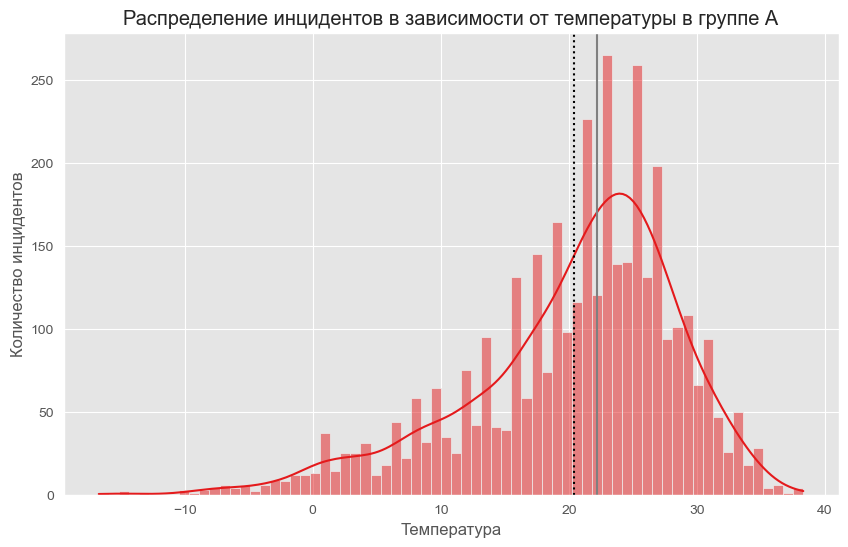

In [252]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_a.query('tmp < 9999').tmp, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от температуры в группе А')
plt.xlabel('Температура')
plt.ylabel('Количество инцидентов')
plt.axvline(group_a.query('tmp < 9999').tmp.mean(), color='black', linestyle=':')
plt.axvline(group_a.query('tmp < 9999').tmp.median(), color='grey')
plt.show();

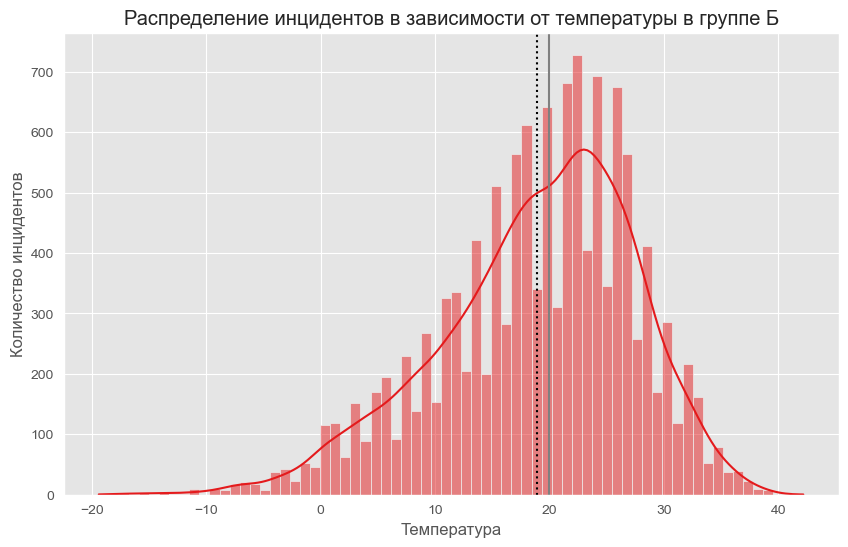

In [253]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_b.query('tmp < 9999').tmp, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от температуры в группе Б')
plt.xlabel('Температура')
plt.ylabel('Количество инцидентов')
plt.axvline(group_b.query('tmp < 9999').tmp.mean(), color='black', linestyle=':')
plt.axvline(group_b.query('tmp < 9999').tmp.median(), color='grey')
plt.show();

In [254]:
print(f'Средняя температура, группа А: {group_a.query("tmp < 9999").tmp.mean()}')
print(f'Средняя температура, группа Б: {group_b.query("tmp < 9999").tmp.mean()}')

Средняя температура, группа А: 20.376779026217243
Средняя температура, группа Б: 18.91173529181963


In [255]:
print(f'Стандартное отклонение, группа А: {group_a.query("tmp < 9999").tmp.std()}')
print(f'Стандартное отклонение, группа Б: {group_b.query("tmp < 9999").tmp.std()}')

Стандартное отклонение, группа А: 8.274093748160706
Стандартное отклонение, группа Б: 8.64033703501766


In [256]:
print(f'Дисперсия, группа А: {group_a.query("tmp < 9999").tmp.var()}')
print(f'Дисперсия, группа Б: {group_b.query("tmp < 9999").tmp.var()}')

Дисперсия, группа А: 68.46062735335208
Дисперсия, группа Б: 74.65542407869776


In [257]:
t_stat, p_value = st.ttest_ind(group_a.query('tmp < 9999').tmp, group_b.query('tmp < 9999').tmp, equal_var=False)
if p_value > alpha:
    print(f'P_value = {p_value}.\nГипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.\
          \nНе существует статистически значимой разницы в средних значениях.')
else:
    print(f'P_value = {p_value}.\nГипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.\
          \nСуществует статистически значимая разница в средних значениях.')

P_value = 5.747415076558657e-21.
Гипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.          
Существует статистически значимая разница в средних значениях.


### Влияние широты

Гипотеза H<sub>0</sub>: Среднее значение широты одинаково в двух группах.

Гипотеза H<sub>1</sub>: Среднее значение широты отличается.

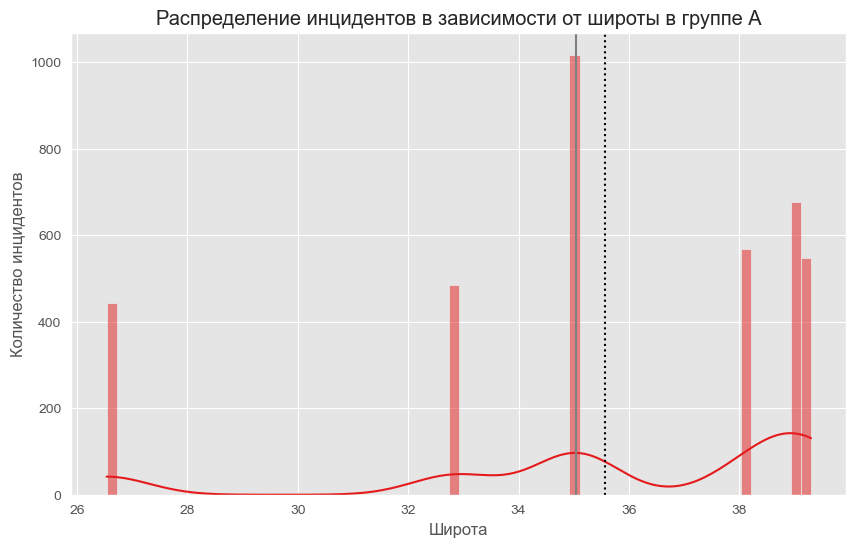

In [258]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_a.latitude, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от широты в группе А')
plt.xlabel('Широта')
plt.ylabel('Количество инцидентов')
plt.axvline(group_a.latitude.mean(), color='black', linestyle=':')
plt.axvline(group_a.latitude.median(), color='grey')
plt.show();

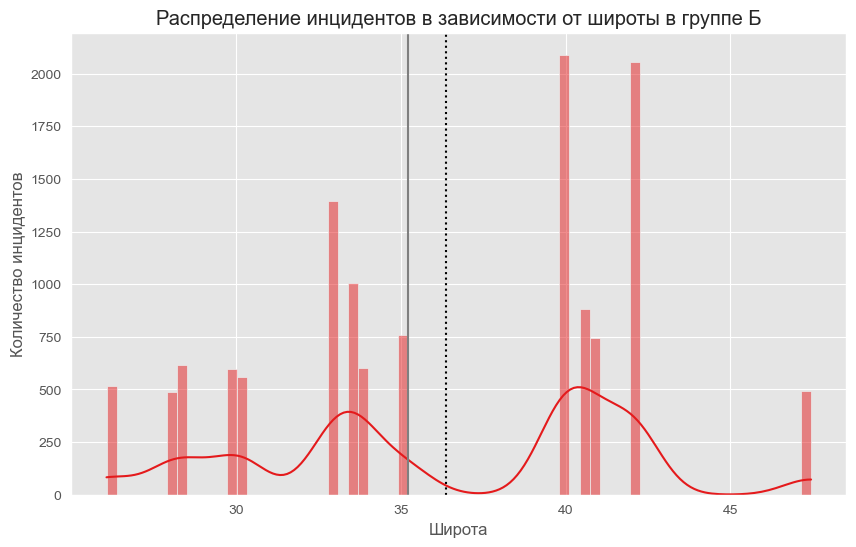

In [259]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_b.latitude, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от широты в группе Б')
plt.xlabel('Широта')
plt.ylabel('Количество инцидентов')
plt.axvline(group_b.latitude.mean(), color='black', linestyle=':')
plt.axvline(group_b.latitude.median(), color='grey')
plt.show();

In [260]:
print(f'Средняя широта, группа А: {group_a.latitude.mean()}')
print(f'Средняя широта, группа Б: {group_b.latitude.mean()}')

Средняя широта, группа А: 35.57092882290038
Средняя широта, группа Б: 36.372379472693254


Разница в 0.8 градуса равна почти 90 км. То есть, столкновения в группе А происходят в среднем на 90 км ближе к экватору, чем столкновения в группе Б.

In [261]:
print(f'Стандартное отклонение, группа А: {group_a.latitude.std()}')
print(f'Стандартное отклонение, группа Б: {group_b.latitude.std()}')

Стандартное отклонение, группа А: 3.998515466519105
Стандартное отклонение, группа Б: 5.490401799113887


In [262]:
print(f'Дисперсия, группа А: {group_a.latitude.var()}')
print(f'Дисперсия, группа Б: {group_b.latitude.var()}')

Дисперсия, группа А: 15.988125935992496
Дисперсия, группа Б: 30.14451191571301


In [263]:
t_stat, p_value = st.ttest_ind(group_a.latitude, group_b.latitude, equal_var = False )
if p_value > alpha:
    print(f'P_value = {p_value}.\nГипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.\
          \nНе существует статистически значимой разницы в средних значениях.')
else:
    print(f'P_value = {p_value}.\nГипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.\
          \nСуществует статистически значимая разница в средних значениях.')

P_value = 9.963975529540181e-23.
Гипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.          
Существует статистически значимая разница в средних значениях.


### Направление ветра

Гипотеза H<sub>0</sub>: Среднее значение угла направления ветра одинаково в двух группах.

Гипотеза H<sub>1</sub>: Среднее значение направления ветра отличается.

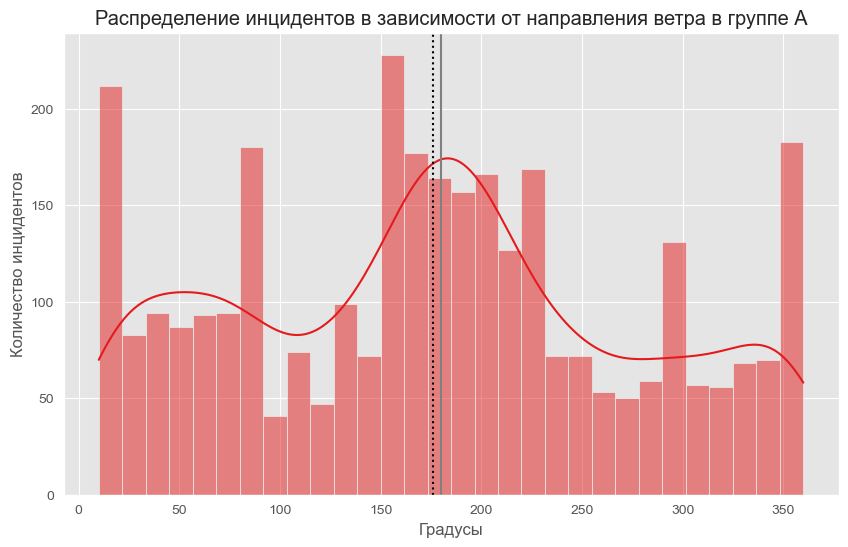

In [264]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_a.query('wnd_angle <= 360').wnd_angle, kde=True, common_norm=True, bins=30)
plt.title('Распределение инцидентов в зависимости от направления ветра в группе А')
plt.xlabel('Градусы')
plt.ylabel('Количество инцидентов')
plt.axvline(group_a.query('wnd_angle <= 360').wnd_angle.mean(), color='black', linestyle=':')
plt.axvline(group_a.query('wnd_angle <= 360').wnd_angle.median(), color='grey')
plt.show();

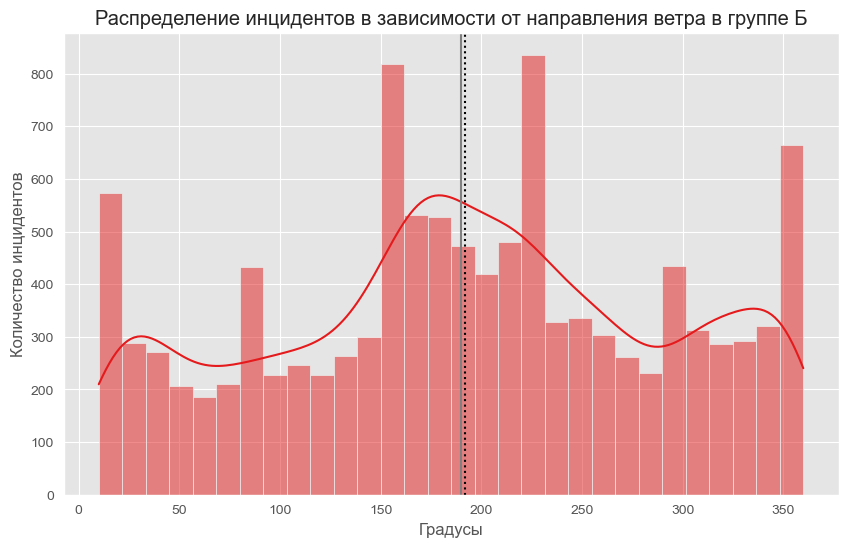

In [265]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_b.query('wnd_angle <= 360').wnd_angle, kde=True, common_norm=True, bins=30)
plt.title('Распределение инцидентов в зависимости от направления ветра в группе Б')
plt.xlabel('Градусы')
plt.ylabel('Количество инцидентов')
plt.axvline(group_b.query('wnd_angle <= 360').wnd_angle.mean(), color='black', linestyle=':')
plt.axvline(group_b.query('wnd_angle <= 360').wnd_angle.median(), color='grey')
plt.show();

In [266]:
print(f'Средний угол, группа А: {group_a.query("wnd_angle <= 360").wnd_angle.mean()}')
print(f'Средний угол, группа Б: {group_b.query("wnd_angle <= 360").wnd_angle.mean()}')

Средний угол, группа А: 175.98763523956723
Средний угол, группа Б: 191.78419560595322


In [267]:
t_stat, p_value = st.ttest_ind(group_a.query('wnd_angle <= 360').wnd_angle, 
                               group_b.query('wnd_angle <= 360').wnd_angle, equal_var = False )
if p_value > alpha:
    print(f'P_value = {p_value}.\nГипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.\
          \nНе существует статистически значимой разницы в средних значениях.')
else:
    print(f'P_value = {p_value}.\nГипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.\
          \nСуществует статистически значимая разница в средних значениях.')

P_value = 1.083910767489091e-15.
Гипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.          
Существует статистически значимая разница в средних значениях.


### Скорость ветра

Гипотеза H<sub>0</sub>: Среднее значение скорости ветра одинаково в двух группах.

Гипотеза H<sub>1</sub>: Среднее значение скорости ветра отличается.

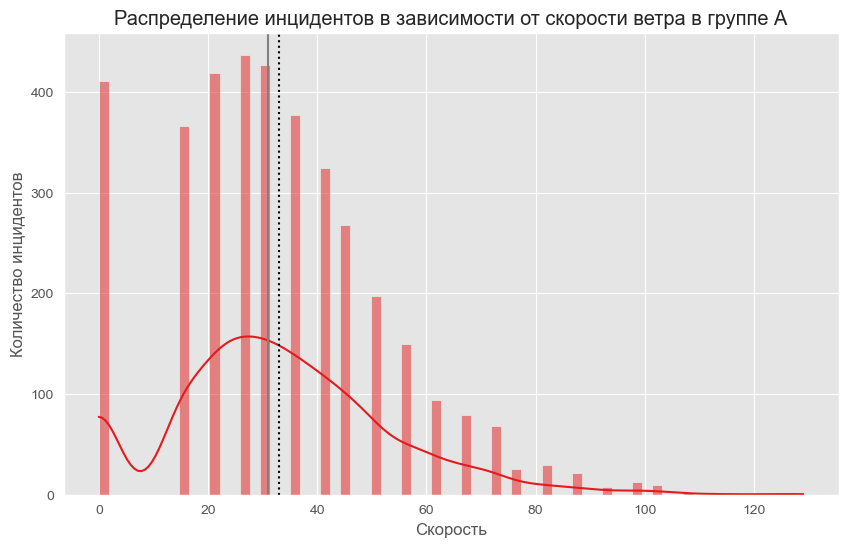

In [268]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_a.query('wnd_speed != 9999').wnd_speed, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от скорости ветра в группе А')
plt.xlabel('Скорость')
plt.ylabel('Количество инцидентов')
plt.axvline(group_a.query('wnd_speed != 9999').wnd_speed.mean(), color='black', linestyle=':')
plt.axvline(group_a.query('wnd_speed != 9999').wnd_speed.median(), color='grey')
plt.show();

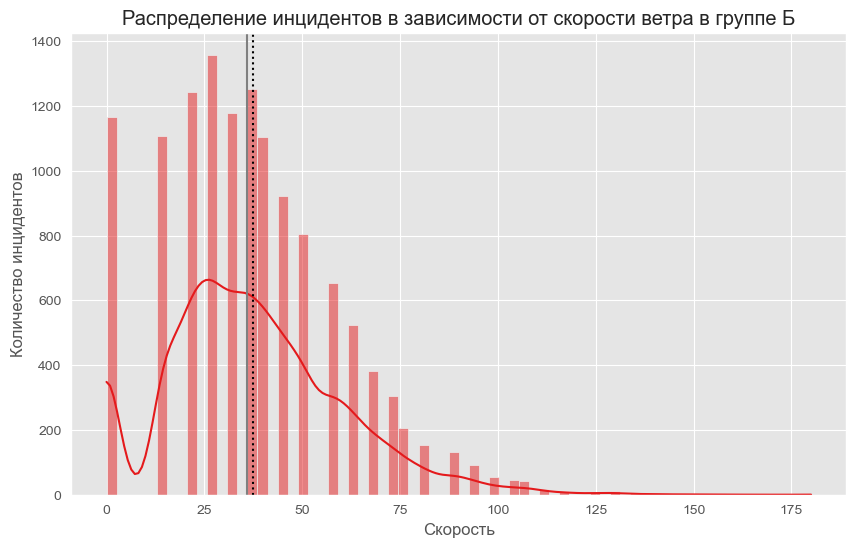

In [269]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_b.query('wnd_speed != 9999').wnd_speed, kde=True, common_norm=True, bins=70)
plt.title('Распределение инцидентов в зависимости от скорости ветра в группе Б')
plt.xlabel('Скорость')
plt.ylabel('Количество инцидентов')

plt.axvline(group_b.query('wnd_speed != 9999').wnd_speed.mean(), color='black', linestyle=':')
plt.axvline(group_b.query('wnd_speed != 9999').wnd_speed.median(), color='grey')
plt.show();

In [270]:
print(f'Средняя скорость ветра, группа А: {group_a.query("wnd_speed != 9999").wnd_speed.mean()}')
print(f'Средняя скорость ветра, группа Б: {group_b.query("wnd_speed != 9999").wnd_speed.mean()}')

Средняя скорость ветра, группа А: 32.984738955823296
Средняя скорость ветра, группа Б: 37.30383803642617


In [271]:
t_stat, p_value = st.ttest_ind(group_a.query('wnd_speed != 9999').wnd_speed, 
                               group_b.query('wnd_speed != 9999').wnd_speed, equal_var = False )
if p_value > alpha:
    print(f'P_value = {p_value}.\nГипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.\
          \nНе существует статистически значимой разницы в средних значениях.')
else:
    print(f'P_value = {p_value}.\nГипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.\
          \nСуществует статистически значимая разница в средних значениях.')

P_value = 1.4547064131601928e-28.
Гипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.          
Существует статистически значимая разница в средних значениях.


### Точка росы

Гипотеза H<sub>0</sub>: Средняя температура точки росы одинакова в двух группах.

Гипотеза H<sub>1</sub>: Средняя температура точки росы отличается.

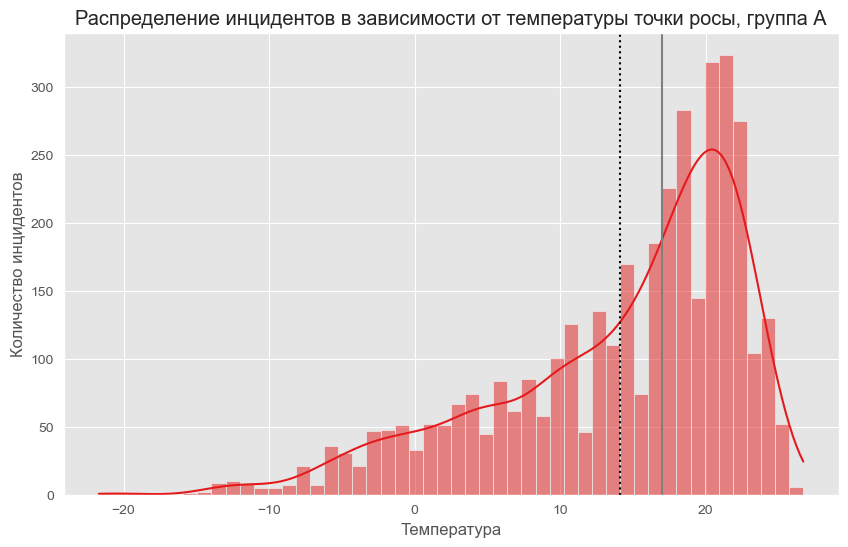

In [272]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_a.query('dew < 9999').dew, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от температуры точки росы, группа А')
plt.xlabel('Температура')
plt.ylabel('Количество инцидентов')
plt.axvline(group_a.query('dew < 9999').dew.mean(), color='black', linestyle=':')
plt.axvline(group_a.query('dew < 9999').dew.median(), color='grey')
plt.show();

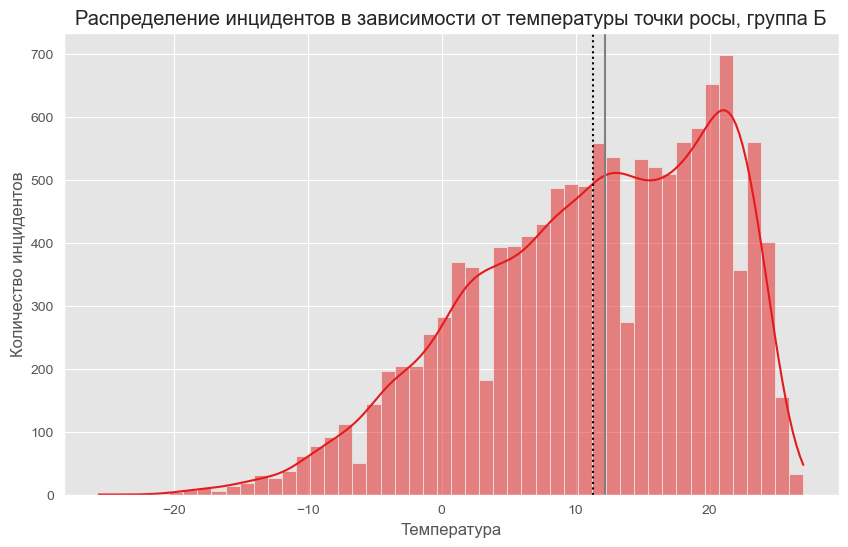

In [273]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_b.query('dew < 9999').dew, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от температуры точки росы, группа Б')
plt.xlabel('Температура')
plt.ylabel('Количество инцидентов')
plt.axvline(group_b.query('dew < 9999').dew.mean(), color='black', linestyle=':')
plt.axvline(group_b.query('dew < 9999').dew.median(), color='grey')
plt.show();

In [274]:
print(f'Средняя температура точки росы, группа А: {group_a.query("dew < 9999").dew.mean()}')
print(f'Средняя температура точки росы, группа Б: {group_b.query("dew < 9999").dew.mean()}')

Средняя температура точки росы, группа А: 14.138650963597412
Средняя температура точки росы, группа Б: 11.316479137365192


In [275]:
t_stat, p_value = st.ttest_ind(group_a.query('dew < 9999').dew, 
                               group_b.query('dew < 9999').dew, equal_var = False )
if p_value > alpha:
    print(f'P_value = {p_value}.\nГипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.\
          \nНе существует статистически значимой разницы в средних значениях.')
else:
    print(f'P_value = {p_value}.\nГипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.\
          \nСуществует статистически значимая разница в средних значениях.')

P_value = 2.964289720957759e-67.
Гипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.          
Существует статистически значимая разница в средних значениях.


### Расстояние до самого низкого облака

Гипотеза H<sub>0</sub>: Среднее расстояние до самого низкого облака одинаково в двух группах.

Гипотеза H<sub>1</sub>: Среднее расстояние отличается.

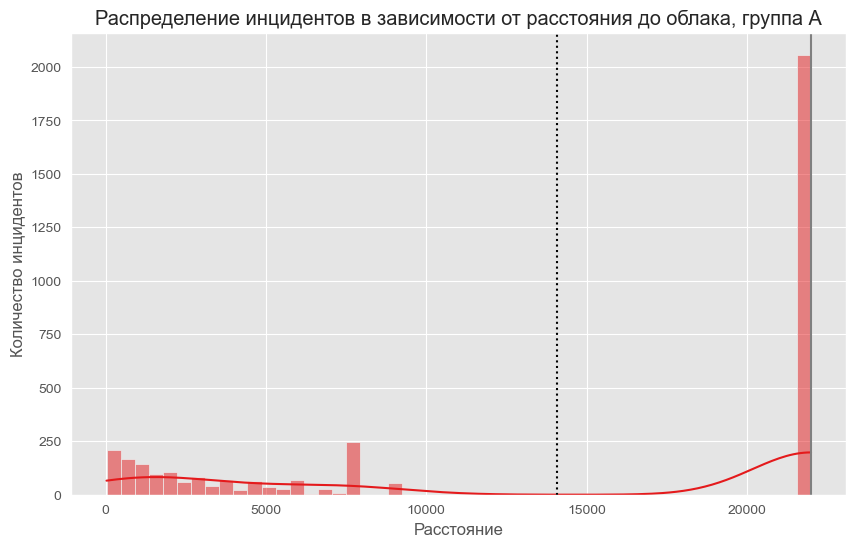

In [276]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_a.query('cig <= 22000').cig, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от расстояния до облака, группа А')
plt.xlabel('Расстояние')
plt.ylabel('Количество инцидентов')
plt.axvline(group_a.query('cig <= 22000').cig.mean(), color='black', linestyle=':')
plt.axvline(group_a.query('cig <= 22000').cig.median(), color='grey')
plt.show();

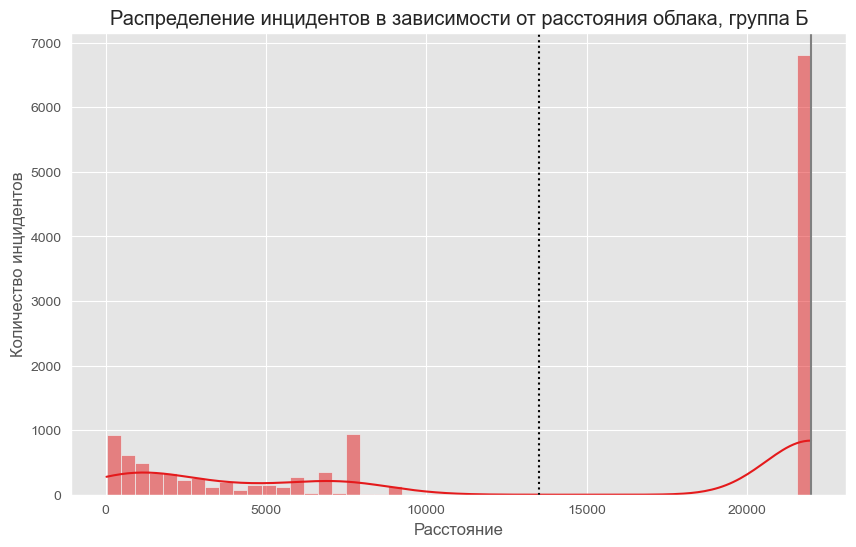

In [277]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_b.query('cig <= 22000').cig, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от расстояния облака, группа Б')
plt.xlabel('Расстояние')
plt.ylabel('Количество инцидентов')
plt.axvline(group_b.query('cig <= 22000').cig.mean(), color='black', linestyle=':')
plt.axvline(group_b.query('cig <= 22000').cig.median(), color='grey')
plt.show();

In [278]:
print(f'Среднее расстояние, группа А: {group_a.query("cig <= 22000").cig.mean()}')
print(f'Среднее расстояние, группа Б: {group_b.query("cig <= 22000").cig.mean()}')

Среднее расстояние, группа А: 14070.93426183844
Среднее расстояние, группа Б: 13510.571507936507


In [279]:
t_stat, p_value = st.ttest_ind(group_a.query('cig <= 22000').cig, 
                               group_b.query('cig <= 22000').cig, equal_var = False )
if p_value > alpha:
    print(f'P_value = {p_value}.\nГипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.\
          \nНе существует статистически значимой разницы в средних значениях.')
else:
    print(f'P_value = {p_value}.\nГипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.\
          \nСуществует статистически значимая разница в средних значениях.')

P_value = 0.0015990980742666232.
Гипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.          
Существует статистически значимая разница в средних значениях.


### Атмосферное давление

Гипотеза H<sub>0</sub>: Среднее атмосферное давление одинаково в двух группах.

Гипотеза H<sub>1</sub>: Среднее давление отличается.

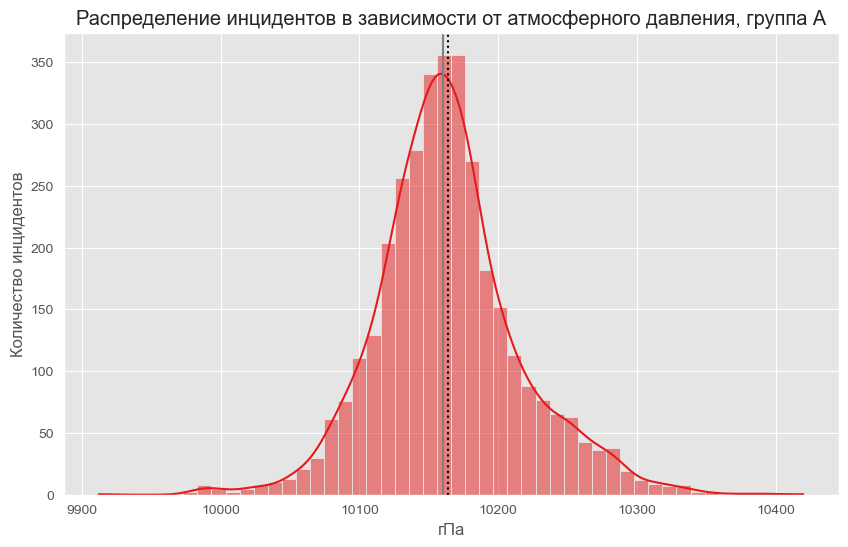

In [280]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_a.query('slp <= 10900').slp, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от атмосферного давления, группа А')
plt.xlabel('гПа')
plt.ylabel('Количество инцидентов')
plt.axvline(group_a.query('slp <= 10900').slp.mean(), color='black', linestyle=':')
plt.axvline(group_a.query('slp <= 10900').slp.median(), color='grey')
plt.show();

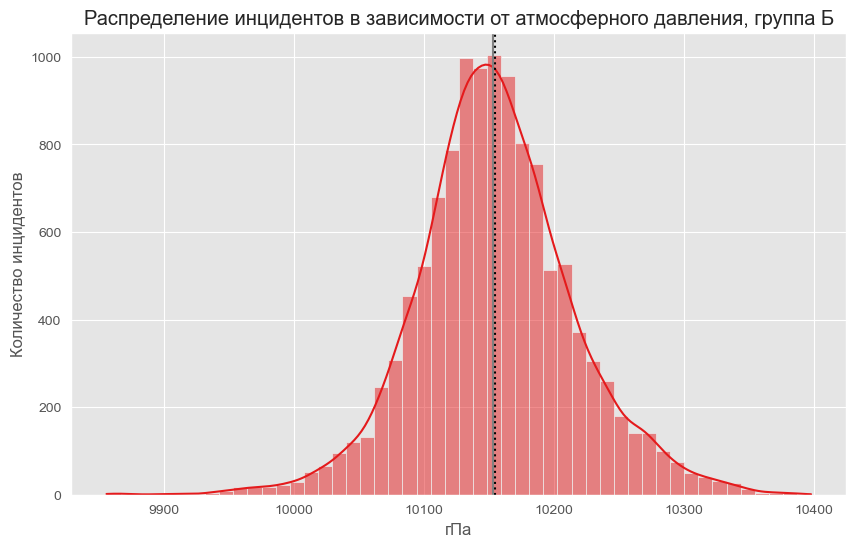

In [281]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_b.query('slp <= 10900').slp, kde=True, common_norm=True, bins=50)
plt.title('Распределение инцидентов в зависимости от атмосферного давления, группа Б')
plt.xlabel('гПа')
plt.ylabel('Количество инцидентов')
plt.axvline(group_b.query('slp <= 10900').slp.mean(), color='black', linestyle=':')
plt.axvline(group_b.query('slp <= 10900').slp.median(), color='grey')
plt.show();

In [282]:
print(f'Среднее давление, группа А: {group_a.query("slp <= 10900").slp.mean()}')
print(f'Среднее давление, группа Б: {group_b.query("slp <= 10900").slp.mean()}')

Среднее давление, группа А: 10163.697660987584
Среднее давление, группа Б: 10154.888916961429


In [283]:
t_stat, p_value = st.ttest_ind(group_a.query('slp <= 10900').slp, 
                               group_b.query('slp <= 10900').slp, equal_var = False )
if p_value > alpha:
    print(f'P_value = {p_value}.\nГипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.\
          \nНе существует статистически значимой разницы в средних значениях.')
else:
    print(f'P_value = {p_value}.\nГипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.\
          \nСуществует статистически значимая разница в средних значениях.')

P_value = 3.126755556162691e-17.
Гипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.          
Существует статистически значимая разница в средних значениях.


### Видимость

Гипотеза H<sub>0</sub>: Средняя видимость одинакова в двух группах.

Гипотеза H<sub>1</sub>: Средняя видимость отличается.

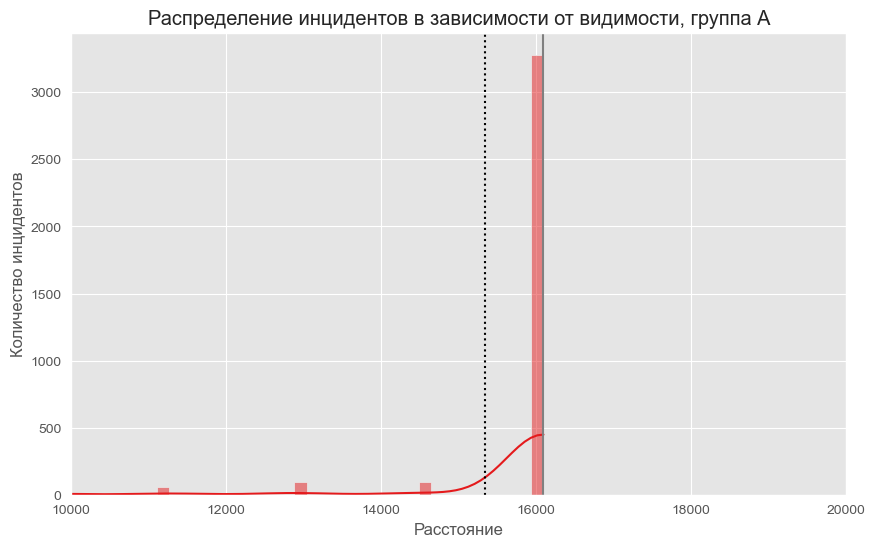

In [284]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_a.query('vis <= 160000').vis, kde=True, common_norm=True, bins=100)
plt.title('Распределение инцидентов в зависимости от видимости, группа А')
plt.xlabel('Расстояние')
plt.ylabel('Количество инцидентов')
plt.xlim(10000, 20000)
plt.axvline(group_a.query('vis <= 160000').vis.mean(), color='black', linestyle=':')
plt.axvline(group_a.query('vis <= 160000').vis.median(), color='grey')
plt.show();

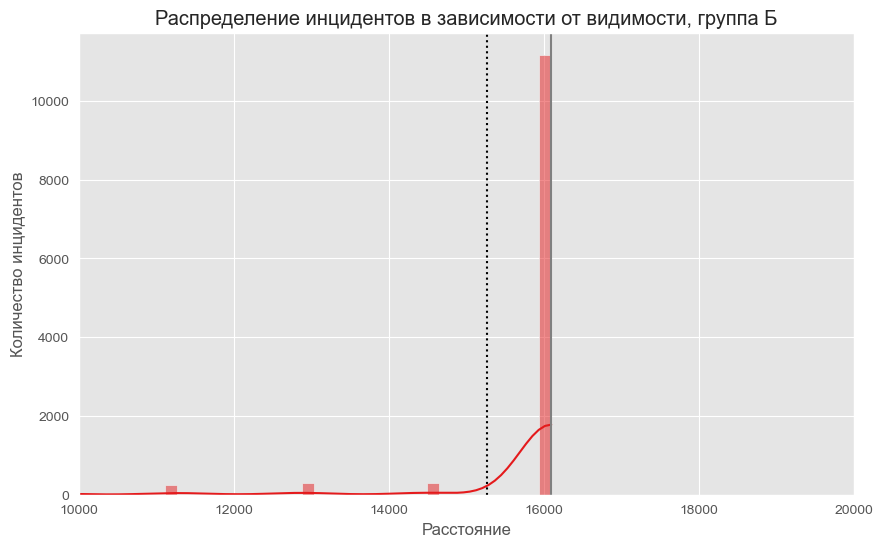

In [285]:
plt.figure(figsize=(10, 6))
sns.histplot(data=group_b.query('vis <= 160000').vis, kde=True, common_norm=True, bins=100)
plt.title('Распределение инцидентов в зависимости от видимости, группа Б')
plt.xlabel('Расстояние')
plt.ylabel('Количество инцидентов')
plt.xlim(10000, 20000)
plt.axvline(group_b.query('vis <= 160000').vis.mean(), color='black', linestyle=':')
plt.axvline(group_b.query('vis <= 160000').vis.median(), color='grey')
plt.show();

In [286]:
print(f'Средняя видимость, группа А: {group_a.query("vis <= 160000").vis.mean()}')
print(f'Средняя видимость, группа Б: {group_b.query("vis <= 160000").vis.mean()}')

Средняя видимость, группа А: 15344.218833600857
Средняя видимость, группа Б: 15258.005234375


In [287]:
t_stat, p_value = st.ttest_ind(group_a.query('vis <= 160000').vis, 
                               group_b.query('vis <= 160000').vis, equal_var = False )
if p_value > alpha:
    print(f'P_value = {p_value}.\nГипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.\
          \nНе существует статистически значимой разницы в средних значениях.')
else:
    print(f'P_value = {p_value}.\nГипотезу следует отвергнуть, так как P_value ниже уровня пороговой значимости.\
          \nСуществует статистически значимая разница в средних значениях.')

P_value = 0.06229087415249323.
Гипотезу нельзя отвергнуть, так как P_value выше уровня пороговой значимости.          
Не существует статистически значимой разницы в средних значениях.


### Промежуточный вывод

<div class="alert alert-info">
В результате проверки ряда гипотез можно сделать вывод о том, что только один признак не оказывает влияния на столкновения птиц с самолетами, это видимость. 
Все остальные признаки (температура, температура точки росы, направление и скорость ветра, состояние неба, атмосферное давление, а также широта) имеют существенное значение.    
    
</div> 

## Выводы

<div class="alert alert-info">
Проведенное исследование позволяет предположить, что погодные условия влияют на столкновения птиц с самолетами опосредованно.
    
Гораздо более значимыми являются географическое положение, климатические условия (жаркий и влажный климат, наличие водных пространств рядом), время года (летние месяцы) и время дня (пик приходится на 8 часов утра).
    
</div>